In [1]:
import numpy as np
import astropy
import astroquery
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

In [2]:
from astroquery.vizier import Vizier
catalog_list = Vizier.find_catalogs('GCNS')
print({k:v.description for k,v in catalog_list.items()})

{'J/A+A/649/A6': 'Gaia Catalogue of Nearby Stars - GCNS (Gaia collaboration, 2021)'}


In [3]:
Vizier.ROW_LIMIT = -1
catalogs = Vizier.get_catalogs(catalog_list.keys())
print(catalogs)

TableList with 8 tables:
	'0:J/A+A/649/A6/table1c' with 31 column(s) and 331312 row(s) 
	'1:J/A+A/649/A6/table1r' with 31 column(s) and 880428 row(s) 
	'2:J/A+A/649/A6/progwd' with 3 column(s) and 45 row(s) 
	'3:J/A+A/649/A6/table3' with 9 column(s) and 19176 row(s) 
	'4:J/A+A/649/A6/maglim' with 13 column(s) and 12288 row(s) 
	'5:J/A+A/649/A6/missing' with 9 column(s) and 1259 row(s) 
	'6:J/A+A/649/A6/hyacomb' with 4 column(s) and 1132 row(s) 
	'7:J/A+A/649/A6/distpdf' with 15 column(s) and 1211740 row(s) 


In [4]:
stellardata=catalogs['J/A+A/649/A6/table1c']

In [5]:
#stellardata

In [6]:
tangential_velocity=4.74*np.sqrt((stellardata['pmDE']/1000)**2+(stellardata['pmRA']/1000)**2)*(1000/stellardata['Plx'])
#Gives tangential velocity in km/s
#tangential_velocity

In [7]:
abs_Gmag=stellardata['Gmag']-5*np.log((stellardata['Dist50']*1000)/10)
#abs_Gmag

In [8]:
stellardata["Tangential Velocity"]=tangential_velocity
stellardata["Abs G Magnitude"]=abs_Gmag

In [9]:
#stellardata

In [10]:
#Color Indices
stellardata["G-RP"]=stellardata['Gmag']-stellardata['RPmag']
stellardata["G-J"]=stellardata['Gmag']-stellardata['Jmag']

In [11]:
stellardata

GaiaEDR3,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,RV,Dist50,xcoord50,ycoord50,zcoord50,Uvel50,Vvel50,Wvel50,gmag,rmag,imag,zmag,Jmag,Hmag,Ksmag,W1mag,W2mag,W3mag,W4mag,GAIAEDR3Cat,_RA.icrs,_DE.icrs,Tangential Velocity,Abs G Magnitude,G-RP,G-J
,deg,deg,mas,mas / yr,mas / yr,mag,mag,mag,km / s,kpc,pc,pc,pc,km / s,km / s,km / s,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,deg,deg,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,bytes11,float64,float64,float64,float64,float64,float64
2334666126716440064,0.0025650,-26.3653495,14.697,23.497,-62.339,15.7779,17.4299,14.5407,--,0.06803,11.27021,7.54892,-66.66381,--,--,--,17.796,16.549,15.059,14.396,12.833,12.267,11.977,11.799,11.606,11.100,9.074,GAIAEDR3Cat,0.0024484,-26.3650724,21.486021907447356,6.191081543185383,1.2372000000000014,2.944899816894532
2341871673090078592,0.0051210,-19.4988406,26.798,179.805,-1.041,8.9429,9.4761,8.2513,--,0.03739,4.10140,8.09092,-36.27160,--,--,--,9.979,8.946,8.662,9.726,7.402,6.975,6.807,6.868,6.800,6.722,6.704,GAIAEDR3Cat,0.0042732,-19.4988360,31.80423851858622,2.348809020025116,0.6915999999999993,1.5409000495910643
530861741656374272,0.0056369,70.8873639,10.282,-52.864,17.787,10.8521,11.3022,10.2396,-26.204,0.09726,-46.21263,84.37781,14.27200,32.872,-13.707,8.930,--,--,--,--,9.523,9.079,9.007,8.965,9.024,8.937,8.649,GAIAEDR3Cat,0.0063545,70.8872848,25.712798252208,-0.5219135599079721,0.6125000000000007,1.3291002365112305
2745400068346761216,0.0093361,6.5110167,16.260,117.495,9.521,16.2772,18.2886,14.9456,--,0.06152,-6.73827,35.40890,-49.85672,--,--,--,18.661,17.399,15.571,14.717,12.922,12.312,12.031,11.866,11.660,11.630,8.881,GAIAEDR3Cat,0.0088105,6.5109744,34.36357961146171,7.193313838983288,1.3316,3.3552000686645513
2855176271335676800,0.0135364,29.2778958,10.295,51.287,46.282,15.6236,17.0649,14.4501,--,0.09716,-27.65700,77.35709,-51.86940,--,--,--,17.406,16.202,14.932,14.344,12.876,12.282,12.081,11.907,11.743,11.589,9.077,GAIAEDR3Cat,0.0132751,29.2776901,31.806764574470662,4.2547299443003705,1.1734999999999989,2.7475995956420896
4616265759236854016,0.0148925,-86.5417045,8.276,15.239,14.097,20.7053,21.4042,19.0972,--,0.11751,56.35943,-84.11356,-59.63383,--,--,--,--,--,--,--,16.323,15.729,15.282,15.021,14.847,13.058,9.303,GAIAEDR3Cat,0.0137697,-86.5417672,11.88974600299726,8.38560828324098,1.6081000000000003,4.382300045776368
2875125810310195712,0.0157909,34.1883005,20.194,-227.366,-56.934,8.3483,8.6769,7.8431,-29.942,0.04952,-15.72239,41.02444,-22.85814,61.074,-5.584,12.826,12.388,12.293,12.445,9.007,7.249,6.940,6.885,7.249,6.922,6.883,6.824,GAIAEDR3Cat,0.0170125,34.1885535,55.015819108460086,0.34934232308852575,0.5052000000000003,1.099299927520752
2335003848584711040,0.0159102,-25.4988391,12.613,-25.099,-17.494,14.6687,16.1144,13.4936,--,0.07931,12.57312,9.85767,-77.68060,--,--,--,16.457,15.264,13.971,13.404,11.925,11.293,11.037,10.926,10.774,10.602,8.804,GAIAEDR3Cat,0.0160338,-25.4987613,11.49735212397058,4.314804344494085,1.1750999999999987,2.743699809265136


In [12]:
GRPsubset=stellardata[(stellardata['G-RP']>1.0) & (stellardata['G-RP']<3.0) & (stellardata['Abs G Magnitude']>14.0)]
#GRPsubset

/Applications/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/Applications/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


In [13]:
GJsubset=stellardata[(stellardata['G-J']>4.0) & (stellardata['G-J']<7.0) & (stellardata['Abs G Magnitude']>14.0)]
#GJsubset

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, '# of Objects')

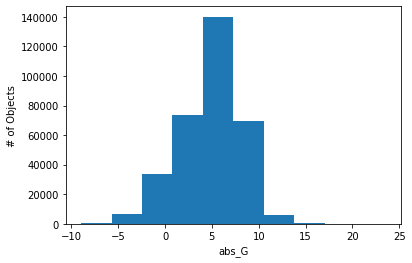

In [14]:
plt.hist(stellardata["Abs G Magnitude"])
plt.xlabel("abs_G")
plt.ylabel("# of Objects")

Text(0, 0.5, '# of Objects')

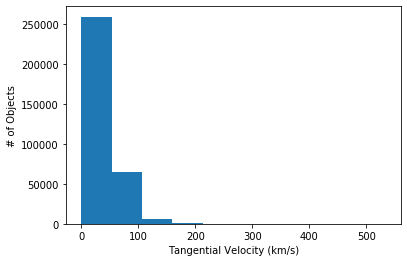

In [15]:
plt.hist(stellardata["Tangential Velocity"])
plt.xlabel("Tangential Velocity (km/s)")
plt.ylabel("# of Objects")

This is for an approximate G-RP subset of stars.


Text(0, 0.5, '# of Objects')

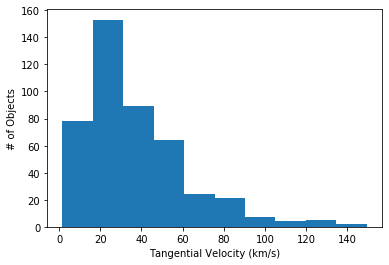

In [16]:
print("This is for an approximate G-RP subset of stars.")
plt.hist(GRPsubset['Tangential Velocity'])
plt.xlabel("Tangential Velocity (km/s)")
plt.ylabel("# of Objects")

This is for an approximate G-J subset of stars.


Text(0, 0.5, '# of Objects')

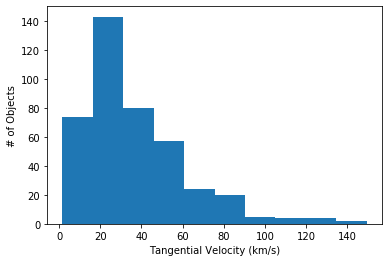

In [17]:
print("This is for an approximate G-J subset of stars.")
plt.hist(GJsubset['Tangential Velocity'])
plt.xlabel("Tangential Velocity (km/s)")
plt.ylabel("# of Objects")

Text(0, 0.5, 'Abs G Magnitude')

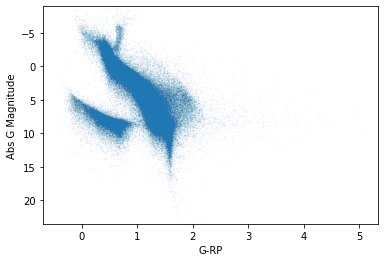

In [18]:
plt.scatter(stellardata['G-RP'],stellardata['Abs G Magnitude'],s=0.1,alpha=0.1)
plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlabel("G-RP")
plt.ylabel("Abs G Magnitude")

Text(0, 0.5, 'Abs G Magnitude')

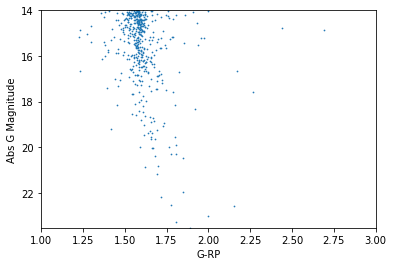

In [19]:
plt.scatter(stellardata['G-RP'],stellardata['Abs G Magnitude'],s=0.5)
#plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlim(1,3)
plt.ylim(max(stellardata['Abs G Magnitude']),14)
plt.xlabel("G-RP")
plt.ylabel("Abs G Magnitude")

Text(0, 0.5, 'Abs G Magnitude')

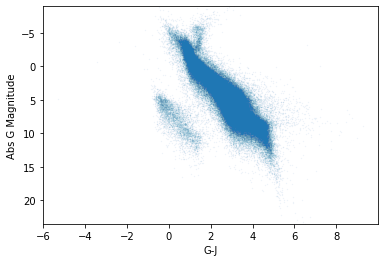

In [20]:
plt.scatter(stellardata['G-J'],stellardata['Abs G Magnitude'],s=0.1,alpha=0.1)
plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlabel("G-J")
plt.ylabel("Abs G Magnitude")

Text(0, 0.5, 'Abs G Magnitude')

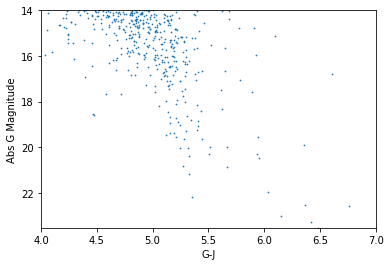

In [21]:
plt.scatter(stellardata['G-J'],stellardata['Abs G Magnitude'],s=0.5)
#plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlim(4,7)
plt.ylim(max(stellardata['Abs G Magnitude']),14)
plt.xlabel("G-J")
plt.ylabel("Abs G Magnitude")

In [22]:
RGBsubset=stellardata[(stellardata['G-RP']>0.5) & (stellardata['G-RP']<1.0) & (stellardata['Abs G Magnitude']<-4.0)]

This is for an approximate RGB subset of stars.


Text(0, 0.5, '# of Objects')

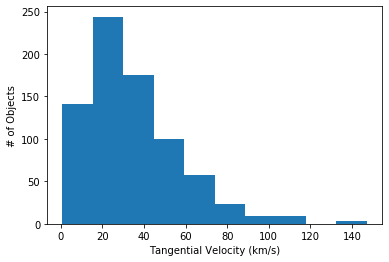

In [23]:
print("This is for an approximate RGB subset of stars.")
plt.hist(RGBsubset['Tangential Velocity'])
plt.xlabel("Tangential Velocity (km/s)")
plt.ylabel("# of Objects")

Text(0, 0.5, 'Abs G Magnitude')

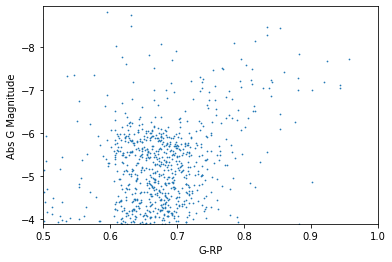

In [24]:
#RGB Set approx.
plt.scatter(stellardata['G-RP'],stellardata['Abs G Magnitude'],s=0.5)
#plt.ylim(max(stellardata['Abs G Magnitude']), min(stellardata['Abs G Magnitude']))
plt.xlim(0.5,1)
plt.ylim(-3.9,min(stellardata['Abs G Magnitude']))
plt.xlabel("G-RP")
plt.ylabel("Abs G Magnitude")

In [25]:
#RGBsubset

In [26]:
#Finding Vmax

In [27]:
c = SkyCoord(ra=stellardata["RA_ICRS"], dec=stellardata["DE_ICRS"], frame='icrs')
c

<SkyCoord (ICRS): (ra, dec) in deg
    [(2.56500000e-03, -26.3653495), (5.12100000e-03, -19.4988406),
     (5.63690000e-03,  70.8873639), ..., (3.59994771e+02, -53.1822876),
     (3.59995813e+02,  60.9183058), (3.59999926e+02, -30.0245287)]>

In [28]:
cgal=c.galactic
cgal

<SkyCoord (Galactic): (l, b) in deg
    [( 33.81465884, -78.49844234), ( 63.11894944, -75.9590265 ),
     (118.70895672,   8.43836494), ..., (319.58451356, -62.25059824),
     (116.71800813,  -1.33113716), ( 15.52038568, -78.34899003)]>

In [29]:
#cgal.b

In [30]:
#Convert to radians.....
gal_latitude=cgal.b
#gal_latitude
np.sin(np.abs(np.deg2rad(gal_latitude.value)))

array([0.97991928, 0.97012247, 0.14674541, ..., 0.8849925 , 0.02323064,
       0.97939584])

In [31]:
H=365*u.pc
dmax=100*u.pc
#dmax
sky_area=4*np.pi
#sky_area
ξ=(dmax*np.sin(np.abs(np.deg2rad(gal_latitude.value)))/H)
#sky_area
#np.min(ξ.value)
#gal_latitude.value

In [32]:
#gal_latitude.value

In [33]:
Vmax=sky_area*((H.value**3)/(np.sin(np.abs(np.deg2rad(gal_latitude.value))))**3)*(2-((ξ.value**2+(2*ξ.value)+2)*np.exp(-ξ.value)))
stellardata["Vmax"]=Vmax
stellardata
#stellardata['Vmax']

GaiaEDR3,RA_ICRS,DE_ICRS,Plx,pmRA,pmDE,Gmag,BPmag,RPmag,RV,Dist50,xcoord50,ycoord50,zcoord50,Uvel50,Vvel50,Wvel50,gmag,rmag,imag,zmag,Jmag,Hmag,Ksmag,W1mag,W2mag,W3mag,W4mag,GAIAEDR3Cat,_RA.icrs,_DE.icrs,Tangential Velocity,Abs G Magnitude,G-RP,G-J,Vmax
,deg,deg,mas,mas / yr,mas / yr,mag,mag,mag,km / s,kpc,pc,pc,pc,km / s,km / s,km / s,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,deg,deg,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float32,bytes11,float64,float64,float64,float64,float64,float64,float64
2334666126716440064,0.0025650,-26.3653495,14.697,23.497,-62.339,15.7779,17.4299,14.5407,--,0.06803,11.27021,7.54892,-66.66381,--,--,--,17.796,16.549,15.059,14.396,12.833,12.267,11.977,11.799,11.606,11.100,9.074,GAIAEDR3Cat,0.0024484,-26.3650724,21.486021907447356,6.191081543185383,1.2372000000000014,2.944899816894532,3429554.2505361154
2341871673090078592,0.0051210,-19.4988406,26.798,179.805,-1.041,8.9429,9.4761,8.2513,--,0.03739,4.10140,8.09092,-36.27160,--,--,--,9.979,8.946,8.662,9.726,7.402,6.975,6.807,6.868,6.800,6.722,6.704,GAIAEDR3Cat,0.0042732,-19.4988360,31.80423851858622,2.348809020025116,0.6915999999999993,1.5409000495910643,3436370.589872347
530861741656374272,0.0056369,70.8873639,10.282,-52.864,17.787,10.8521,11.3022,10.2396,-26.204,0.09726,-46.21263,84.37781,14.27200,32.872,-13.707,8.930,--,--,--,--,9.523,9.079,9.007,8.965,9.024,8.937,8.649,GAIAEDR3Cat,0.0063545,70.8872848,25.712798252208,-0.5219135599079721,0.6125000000000007,1.3291002365112305,4064493.6311802194
2745400068346761216,0.0093361,6.5110167,16.260,117.495,9.521,16.2772,18.2886,14.9456,--,0.06152,-6.73827,35.40890,-49.85672,--,--,--,18.661,17.399,15.571,14.717,12.922,12.312,12.031,11.866,11.660,11.630,8.881,GAIAEDR3Cat,0.0088105,6.5109744,34.36357961146171,7.193313838983288,1.3316,3.3552000686645513,3549575.3097005812
2855176271335676800,0.0135364,29.2778958,10.295,51.287,46.282,15.6236,17.0649,14.4501,--,0.09716,-27.65700,77.35709,-51.86940,--,--,--,17.406,16.202,14.932,14.344,12.876,12.282,12.081,11.907,11.743,11.589,9.077,GAIAEDR3Cat,0.0132751,29.2776901,31.806764574470662,4.2547299443003705,1.1734999999999989,2.7475995956420896,3755106.0602370803
4616265759236854016,0.0148925,-86.5417045,8.276,15.239,14.097,20.7053,21.4042,19.0972,--,0.11751,56.35943,-84.11356,-59.63383,--,--,--,--,--,--,--,16.323,15.729,15.282,15.021,14.847,13.058,9.303,GAIAEDR3Cat,0.0137697,-86.5417672,11.88974600299726,8.38560828324098,1.6081000000000003,4.382300045776368,3775365.7098269174
2875125810310195712,0.0157909,34.1883005,20.194,-227.366,-56.934,8.3483,8.6769,7.8431,-29.942,0.04952,-15.72239,41.02444,-22.85814,61.074,-5.584,12.826,12.388,12.293,12.445,9.007,7.249,6.940,6.885,7.249,6.922,6.883,6.824,GAIAEDR3Cat,0.0170125,34.1885535,55.015819108460086,0.34934232308852575,0.5052000000000003,1.099299927520752,3810935.5757315946
2335003848584711040,0.0159102,-25.4988391,12.613,-25.099,-17.494,14.6687,16.1144,13.4936,--,0.07931,12.57312,9.85767,-77.68060,--,--,--,16.457,15.264,13.971,13.404,11.925,11.293,11.037,10.926,10.774,10.602,8.804,GAIAEDR3Cat,0.0160338,-25.4987613,11.49735212397058,4.314804344494085,1.1750999999999987,2.743699809265136,3429847.331217874


In [34]:
#Calculating the Luminosity Function of the Set...

In [35]:
#lum_function=np.sum(1/stellardata['Vmax'])

In [36]:
#lum_function

In [37]:
dm=5.0*(np.log10(stellardata['Dist50']*1000/10))
absG=stellardata['Gmag']-dm
absG_rounded=np.rint(2*absG)
int_absG=(absG_rounded.astype(int))
i_close=(stellardata['Dist50']*1000<50)
#absG[i]

In [65]:
lf_count=np.zeros(60)
lf_values=np.arange(60)/2
lf_values1=np.arange(60)/2
lf_spacedensity=np.zeros(60)

In [39]:
#np.nditer(int_absG)

In [56]:
for i in np.nditer(int_absG):
    #discards things that were NaNs (now very large +/- integers) or lie outside range
    if ((i>=0)&(i<60)):        
        #lf_spacedensity=np.sum(1/stellardata['Vmax'])
        lf_count[i]+=1
        #do something more sophiscated with Vmax if limits vary

In [71]:
#for i in np.nditer(int_absG):
#    if ((i>=0)&(i<=60)):
#        lf_values1[i]=np.sum(1/stellardata['Vmax'])
#        lf_spacedensity[i]+=1

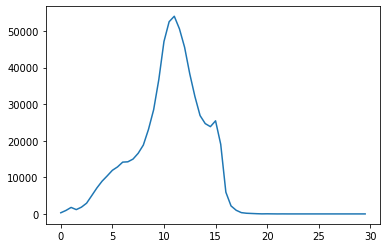

In [50]:
plt.plot(lf_values,lf_count)

<BarContainer object of 60 artists>

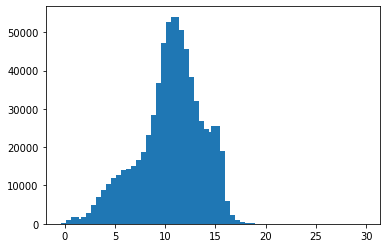

In [51]:
plt.bar(lf_values,lf_count)

In [120]:
bins=np.linspace(11.5,12.5,11)
bin_data=np.digitize(absG,bins,right=True)
bincount=np.bincount(bin_data)

In [155]:
for n in range(absG.size):
    if ((absG[n]>=11.5)and(absG[n]<=12.5)):
        print(bins[bin_data[n]-1], "<=", absG[n], "<", bins[bin_data[n]])
    

11.6 <= 11.614397645197165 < 11.7
12.3 <= 12.332118366033129 < 12.4
12.2 <= 12.21755137727244 < 12.3
11.8 <= 11.807445135378888 < 11.9
11.6 <= 11.687747898559188 < 11.7
12.0 <= 12.094482825855135 < 12.1
11.5 <= 11.515663085129713 < 11.6
11.7 <= 11.701554777511259 < 11.8
12.4 <= 12.496296353676513 < 12.5
11.7 <= 11.74932784382878 < 11.8
12.1 <= 12.114695334897911 < 12.2
11.5 <= 11.534447293563145 < 11.6
12.2 <= 12.283858847815468 < 12.3
12.0 <= 12.074347055963289 < 12.1
12.3 <= 12.332809849849383 < 12.4
11.9 <= 11.986583346982531 < 12.0
11.8 <= 11.888522923423444 < 11.9
12.1 <= 12.149494014331513 < 12.2
12.0 <= 12.078145077359295 < 12.1
11.5 <= 11.531222949611745 < 11.6
12.4 <= 12.436012956750972 < 12.5
11.8 <= 11.869095795319073 < 11.9
11.6 <= 11.678816234275528 < 11.7
12.1 <= 12.12953879726259 < 12.2
12.3 <= 12.34199509903939 < 12.4
12.1 <= 12.14313883367602 < 12.2
12.1 <= 12.136022486429631 < 12.2
11.9 <= 11.985400510693987 < 12.0
12.4 <= 12.455210610208226 < 12.5
12.1 <= 12.15154523

11.5 <= 11.551041047288262 < 11.6
11.8 <= 11.858383720831592 < 11.9
11.7 <= 11.79342409915865 < 11.8
12.1 <= 12.195895196585539 < 12.2
11.5 <= 11.542842191404546 < 11.6
11.6 <= 11.64092215833639 < 11.7
12.2 <= 12.278876136311055 < 12.3
11.9 <= 11.904147571029421 < 12.0
11.6 <= 11.617745622806133 < 11.7
11.8 <= 11.877935224005762 < 11.9
11.8 <= 11.860033139601999 < 11.9
11.8 <= 11.890810623867367 < 11.9
11.5 <= 11.552093230783154 < 11.6
11.8 <= 11.866417988702352 < 11.9
11.8 <= 11.808762295846417 < 11.9
11.7 <= 11.75151391446949 < 11.8
12.3 <= 12.392456603349224 < 12.4
11.6 <= 11.658075295719467 < 11.7
11.7 <= 11.761251882863716 < 11.8
11.9 <= 11.937853838454146 < 12.0
12.0 <= 12.062702838323249 < 12.1
11.6 <= 11.617912516266244 < 11.7
11.6 <= 11.606496905710578 < 11.7
11.8 <= 11.81056781845422 < 11.9
12.2 <= 12.243874608475647 < 12.3
12.0 <= 12.015939166192831 < 12.1
11.8 <= 11.813811412184513 < 11.9
12.3 <= 12.351015455199146 < 12.4
11.7 <= 11.775759806998085 < 11.8
11.7 <= 11.7343648

12.3 <= 12.36744140504264 < 12.4
12.4 <= 12.401601861183622 < 12.5
12.0 <= 12.069373147894375 < 12.1
12.2 <= 12.282911580793026 < 12.3
11.6 <= 11.648676602957163 < 11.7
11.9 <= 11.903566234700758 < 12.0
11.9 <= 11.961360010965471 < 12.0
12.2 <= 12.23057864251366 < 12.3
11.5 <= 11.506362064745261 < 11.6
11.7 <= 11.73298121478194 < 11.8
11.9 <= 11.978121117010508 < 12.0
11.6 <= 11.667222010165526 < 11.7
11.7 <= 11.721365424275088 < 11.8
12.0 <= 12.060939413929594 < 12.1
11.7 <= 11.750668199121456 < 11.8
11.9 <= 11.93041924766036 < 12.0
12.1 <= 12.164675728119384 < 12.2
12.2 <= 12.227031460260498 < 12.3
11.9 <= 11.919406125350012 < 12.0
12.0 <= 12.013550072530194 < 12.1
11.5 <= 11.511640804411892 < 11.6
11.9 <= 11.955525914172163 < 12.0
12.3 <= 12.347131103876633 < 12.4
12.3 <= 12.341778930080771 < 12.4
12.1 <= 12.174919123499842 < 12.2
11.9 <= 11.978875380864872 < 12.0
12.1 <= 12.149479368260044 < 12.2
12.4 <= 12.4158371037711 < 12.5
11.8 <= 11.834841536313359 < 11.9
12.3 <= 12.394151491

12.0 <= 12.090652004893204 < 12.1
11.7 <= 11.738431093066078 < 11.8
11.8 <= 11.846922432927183 < 11.9
12.3 <= 12.376878563206475 < 12.4
11.9 <= 11.96372402511707 < 12.0
12.1 <= 12.124392889523877 < 12.2
12.4 <= 12.428426380040698 < 12.5
11.6 <= 11.62191811266607 < 11.7
11.5 <= 11.578403908054913 < 11.6
12.2 <= 12.213213445957669 < 12.3
11.5 <= 11.555591273073015 < 11.6
11.6 <= 11.614531347666274 < 11.7
12.0 <= 12.026147480353213 < 12.1
11.7 <= 11.744220756309474 < 11.8
11.8 <= 11.85740082393865 < 11.9
11.5 <= 11.508970821349756 < 11.6
11.9 <= 11.906485236147278 < 12.0
12.0 <= 12.053721516057513 < 12.1
11.7 <= 11.775475295719467 < 11.8
12.2 <= 12.238317930779019 < 12.3
11.7 <= 11.736645597097539 < 11.8
11.8 <= 11.899836040361276 < 11.9
12.4 <= 12.470643755571693 < 12.5
11.8 <= 11.852843478360992 < 11.9
11.6 <= 11.670726931642939 < 11.7
11.6 <= 11.672088441602746 < 11.7
11.5 <= 11.519016314702247 < 11.6
12.3 <= 12.353999553168062 < 12.4
12.1 <= 12.132129755811102 < 12.2
12.0 <= 12.057055

12.0 <= 12.048206594382464 < 12.1
11.9 <= 11.901079469159598 < 12.0
12.2 <= 12.26174646441931 < 12.3
11.9 <= 11.966169119676847 < 12.0
12.1 <= 12.198720348004166 < 12.2
11.5 <= 11.506400216800941 < 11.6
12.0 <= 12.054476494740982 < 12.1
12.2 <= 12.250186805773879 < 12.3
11.9 <= 11.953516457676308 < 12.0
12.0 <= 12.066930025279758 < 12.1
11.6 <= 11.65702847954744 < 11.7
11.5 <= 11.550834595367224 < 11.6
11.5 <= 11.580463892789394 < 11.6
12.4 <= 12.447789616785698 < 12.5
12.0 <= 12.053457701675145 < 12.1
11.9 <= 11.906292559258766 < 12.0
12.2 <= 12.234386593993788 < 12.3
12.2 <= 12.216438956811125 < 12.3
12.0 <= 12.067704396587423 < 12.1
11.5 <= 11.54675723405455 < 11.6
12.2 <= 12.296240693699144 < 12.3
12.3 <= 12.307908770582596 < 12.4
12.3 <= 12.319940187259654 < 12.4
11.5 <= 11.561488826920918 < 11.6
11.7 <= 11.775509715017488 < 11.8
11.6 <= 11.617341041791537 < 11.7
12.0 <= 12.011373108109979 < 12.1
12.1 <= 12.166178947673817 < 12.2
12.3 <= 12.397038115313292 < 12.4
11.9 <= 11.950920

11.9 <= 11.990402162781313 < 12.0
11.6 <= 11.649758191364342 < 11.7
12.0 <= 12.070361559562642 < 12.1
11.5 <= 11.572439941789279 < 11.6
11.5 <= 11.530152023881014 < 11.6
12.0 <= 12.03567250283933 < 12.1
12.1 <= 12.197257428858812 < 12.2
12.0 <= 12.036091070826258 < 12.1
12.0 <= 12.014725162304021 < 12.1
11.8 <= 11.8040455792829 < 11.9
11.9 <= 11.949622180018936 < 12.0
12.3 <= 12.317901383014625 < 12.4
11.7 <= 11.782123354079364 < 11.8
12.2 <= 12.266658231014539 < 12.3
11.6 <= 11.61985711374494 < 11.7
11.9 <= 11.902794061133275 < 12.0
12.1 <= 12.128394398819648 < 12.2
12.2 <= 12.288790116185726 < 12.3
12.3 <= 12.390180155375173 < 12.4
12.4 <= 12.464975728119384 < 12.5
12.1 <= 12.130968295716077 < 12.2
11.7 <= 11.751784264580586 < 11.8
11.6 <= 11.639918677845202 < 11.7
11.8 <= 11.816974685713863 < 11.9
12.0 <= 12.012431676143278 < 12.1
12.4 <= 12.417287222057487 < 12.5
12.2 <= 12.217855931197125 < 12.3
11.7 <= 11.729875766701507 < 11.8
12.1 <= 12.143396177368789 < 12.2
11.5 <= 11.5072739

12.4 <= 12.433461538996394 < 12.5
11.9 <= 11.976298378236583 < 12.0
12.3 <= 12.356926624637257 < 12.4
12.3 <= 12.332870963873468 < 12.4
12.0 <= 12.025280847067492 < 12.1
12.1 <= 12.187616234275529 < 12.2
11.7 <= 11.791552091206782 < 11.8
11.8 <= 11.801862704372343 < 11.9
11.7 <= 11.715201820725909 < 11.8
12.1 <= 12.194494529667757 < 12.2
12.3 <= 12.30421389212891 < 12.4
11.8 <= 11.8326496604754 < 11.9
11.8 <= 11.831752763618793 < 11.9
11.7 <= 11.709013880162685 < 11.8
11.5 <= 11.580981149389402 < 11.6
11.7 <= 11.754456816042882 < 11.8
12.0 <= 12.091446562669944 < 12.1
12.0 <= 12.044554925537277 < 12.1
11.9 <= 11.94637204907475 < 12.0
11.6 <= 11.666542442727602 < 11.7
11.9 <= 11.971525219989873 < 12.0
11.8 <= 11.8728777787885 < 11.9
11.7 <= 11.745209576670492 < 11.8
11.6 <= 11.688447654881232 < 11.7
11.8 <= 11.81377941103686 < 11.9
11.6 <= 11.656967809980742 < 11.7
12.2 <= 12.265706086796698 < 12.3
12.3 <= 12.316679303619104 < 12.4
12.2 <= 12.218953952500202 < 12.3
11.6 <= 11.6903456155

11.9 <= 11.93307310810998 < 12.0
12.3 <= 12.334941254750564 < 12.4
12.0 <= 12.036108357462313 < 12.1
11.9 <= 11.9970991845506 < 12.0
12.4 <= 12.46753939399269 < 12.5
11.7 <= 11.7119925672026 < 11.8
11.7 <= 11.76847748550977 < 11.8
11.6 <= 11.606467050306318 < 11.7
11.5 <= 11.562668255761746 < 11.6
11.9 <= 11.964363517396285 < 12.0
11.8 <= 11.84661057899121 < 11.9
11.6 <= 11.628669508217047 < 11.7
11.5 <= 11.524235028025753 < 11.6
12.3 <= 12.31424982843837 < 12.4
11.8 <= 11.801743538355558 < 11.9
11.9 <= 11.924195135710136 < 12.0
12.4 <= 12.426233017884837 < 12.5
11.9 <= 11.919809394025249 < 12.0
12.0 <= 12.063105602951048 < 12.1
12.4 <= 12.444780813398111 < 12.5
11.8 <= 11.868181525300779 < 11.9
12.2 <= 12.245096482112158 < 12.3
12.0 <= 12.046993399049505 < 12.1
12.3 <= 12.374613323876591 < 12.4
11.8 <= 11.848949473166575 < 11.9
11.5 <= 11.533644461240371 < 11.6
11.5 <= 11.519821669518858 < 11.6
11.9 <= 11.940655205323434 < 12.0
11.5 <= 11.553207910743135 < 11.6
11.7 <= 11.747671079987

11.9 <= 11.956719588312962 < 12.0
12.4 <= 12.402931770794412 < 12.5
11.8 <= 11.820302238116565 < 11.9
12.1 <= 12.171989467854932 < 12.2
12.0 <= 12.098514117766042 < 12.1
12.0 <= 12.093333149913613 < 12.1
12.1 <= 12.145930492283007 < 12.2
12.3 <= 12.391514372261511 < 12.4
11.9 <= 11.93798035541544 < 12.0
11.8 <= 11.856446543044841 < 11.9
11.9 <= 11.924741260189213 < 12.0
11.6 <= 11.656872502839331 < 11.7
11.6 <= 11.650814117766041 < 11.7
12.3 <= 12.366491064408905 < 12.4
11.8 <= 11.812918603866342 < 11.9
11.7 <= 11.769249631012643 < 11.8
12.0 <= 12.047959705434135 < 12.1
12.4 <= 12.413887189162683 < 12.5
11.9 <= 11.974676602957162 < 12.0
12.2 <= 12.23420671513085 < 12.3
12.3 <= 12.384964755369708 < 12.4
12.2 <= 12.297745644432197 < 12.3
11.8 <= 11.880455227897407 < 11.9
12.4 <= 12.484506481399055 < 12.5
11.5 <= 11.549269353644743 < 11.6
12.4 <= 12.446540245711443 < 12.5
11.8 <= 11.828831727573624 < 11.9
11.7 <= 11.787307456978919 < 11.8
12.0 <= 12.023327907245477 < 12.1
11.6 <= 11.66544

12.1 <= 12.110750461639695 < 12.2
12.1 <= 12.119108659381547 < 12.2
12.2 <= 12.294827557606348 < 12.3
12.2 <= 12.23532953210485 < 12.3
12.1 <= 12.188061392343865 < 12.2
11.6 <= 11.630066611682356 < 11.7
12.2 <= 12.238404605216509 < 12.3
11.9 <= 11.919559787666907 < 12.0
11.8 <= 11.82938049119791 < 11.9
12.1 <= 12.133344461240371 < 12.2
11.8 <= 11.880696521280381 < 11.9
11.7 <= 11.73596579959332 < 11.8
12.2 <= 12.239003225459424 < 12.3
12.1 <= 12.145315277061858 < 12.2
12.2 <= 12.292907243593756 < 12.3
12.1 <= 12.170837635150905 < 12.2
11.6 <= 11.66500283823888 < 11.7
11.5 <= 11.535467551238254 < 11.6
11.9 <= 11.929533098040311 < 12.0
12.4 <= 12.462415258077627 < 12.5
11.6 <= 11.619820979232497 < 11.7
11.8 <= 11.887969748669862 < 11.9
11.8 <= 11.867686076789067 < 11.9
11.9 <= 11.948711022882646 < 12.0
11.8 <= 11.86270740462613 < 11.9
12.3 <= 12.361581089494166 < 12.4
11.7 <= 11.762614608588073 < 11.8
11.7 <= 11.732890093549937 < 11.8
11.6 <= 11.66893743991502 < 11.7
12.2 <= 12.293324987

12.1 <= 12.157953797311713 < 12.2
11.7 <= 11.710963497908061 < 11.8
11.8 <= 11.819225641187 < 11.9
12.3 <= 12.326816660868598 < 12.4
12.0 <= 12.021664214971722 < 12.1
11.6 <= 11.626792973723896 < 11.7
12.4 <= 12.40573865407721 < 12.5
12.4 <= 12.422354021973712 < 12.5
12.2 <= 12.268172926048852 < 12.3
12.1 <= 12.11371533435279 < 12.2
11.8 <= 11.885141314624743 < 11.9
11.6 <= 11.69084022967412 < 11.7
11.5 <= 11.582158876821907 < 11.6
11.5 <= 11.539115425293947 < 11.6
11.7 <= 11.74659513163061 < 11.8
12.2 <= 12.245944925292996 < 12.3
11.7 <= 11.726353071652909 < 11.8
11.8 <= 11.853837147901476 < 11.9
12.0 <= 12.04657490954925 < 12.1
12.1 <= 12.126664374310693 < 12.2
11.8 <= 11.861925997616492 < 11.9
11.8 <= 11.861527777650132 < 11.9
11.6 <= 11.626497250617621 < 11.7
11.8 <= 11.820954320187024 < 11.9
12.1 <= 12.10839206995622 < 12.2
11.7 <= 11.752022537189994 < 11.8
11.6 <= 11.685148689501945 < 11.7
11.8 <= 11.860721756228832 < 11.9
11.9 <= 11.995662669435038 < 12.0
12.4 <= 12.494424296553

12.4 <= 12.48355406888307 < 12.5
12.4 <= 12.436418098471822 < 12.5
12.1 <= 12.157749285846052 < 12.2
12.1 <= 12.171441250030021 < 12.2
12.2 <= 12.228324244874074 < 12.3
12.0 <= 12.01117174531587 < 12.1
11.9 <= 11.94579840982307 < 12.0
12.1 <= 12.106172502839328 < 12.2
12.2 <= 12.263381450937821 < 12.3
12.3 <= 12.324169053120041 < 12.4
11.5 <= 11.565383755789219 < 11.6
12.2 <= 12.248609719006675 < 12.3
11.7 <= 11.751354890872351 < 11.8
12.4 <= 12.465400429298878 < 12.5
11.8 <= 11.880986613990135 < 11.9
11.7 <= 11.764806418720912 < 11.8
11.8 <= 11.857213674467152 < 11.9
12.2 <= 12.294602060670284 < 12.3
11.8 <= 11.88873303997718 < 11.9
12.4 <= 12.429562384340318 < 12.5
11.8 <= 11.838818143053716 < 11.9
12.2 <= 12.25413841826531 < 12.3
12.4 <= 12.461926116576432 < 12.5
11.5 <= 11.548947846688574 < 11.6
11.5 <= 11.509496736787135 < 11.6
11.7 <= 11.737217575337166 < 11.8
11.7 <= 11.728211236217778 < 11.8
12.0 <= 12.071490232070927 < 12.1
11.7 <= 11.733022772259833 < 11.8
11.7 <= 11.72616735

12.3 <= 12.393047550708037 < 12.4
12.0 <= 12.05586209369941 < 12.1
11.8 <= 11.853994379576175 < 11.9
12.1 <= 12.144851377272438 < 12.2
12.1 <= 12.196812516266245 < 12.2
11.5 <= 11.589469757824759 < 11.6
12.2 <= 12.20420598339749 < 12.3
11.8 <= 11.830598453183256 < 11.9
12.0 <= 12.038575128183426 < 12.1
12.2 <= 12.228919482884795 < 12.3
12.4 <= 12.48139570990294 < 12.5
12.1 <= 12.19576177571626 < 12.2
12.0 <= 12.069317733828276 < 12.1
11.6 <= 11.660619686577808 < 11.7
11.5 <= 11.54293029349326 < 11.6
12.0 <= 12.028985062706525 < 12.1
12.4 <= 12.462027494562292 < 12.5
11.5 <= 11.556053324661121 < 11.6
12.1 <= 12.123116038987526 < 12.2
12.3 <= 12.36393719452137 < 12.4
12.1 <= 12.133885253517372 < 12.2
11.5 <= 11.58575901727832 < 11.6
11.6 <= 11.6331531632721 < 11.7
12.2 <= 12.290649921598858 < 12.3
11.9 <= 11.913961476162832 < 12.0
12.4 <= 12.434756017180701 < 12.5
12.0 <= 12.087100917784657 < 12.1
12.2 <= 12.291560379833326 < 12.3
12.1 <= 12.114864077192086 < 12.2
12.0 <= 12.038130781441

11.6 <= 11.69948578043957 < 11.7
11.7 <= 11.705029137977062 < 11.8
12.1 <= 12.145386833038144 < 12.2
11.9 <= 11.959838825728593 < 12.0
11.7 <= 11.784189269088314 < 11.8
11.6 <= 11.674599870815033 < 11.7
12.4 <= 12.481923879642743 < 12.5
11.5 <= 11.535508357462314 < 11.6
11.7 <= 11.773907787142349 < 11.8
11.6 <= 11.61265647413422 < 11.7
11.9 <= 11.98169809935835 < 12.0
11.9 <= 11.949566492583063 < 12.0
12.2 <= 12.231681900841366 < 12.3
11.8 <= 11.813378161286199 < 11.9
12.3 <= 12.318436442245146 < 12.4
12.1 <= 12.173726833122128 < 12.2
12.1 <= 12.103545213161699 < 12.2
11.7 <= 11.710150438018864 < 11.8
11.7 <= 11.738094061133275 < 11.8
12.3 <= 12.360427639986302 < 12.4
12.0 <= 12.096790607247822 < 12.1
12.0 <= 12.0907048395255 < 12.1
11.6 <= 11.697957196403278 < 11.7
12.0 <= 12.052579382439221 < 12.1
12.3 <= 12.347869746811309 < 12.4
12.0 <= 12.00224717346865 < 12.1
11.8 <= 11.81237842002193 < 11.9
12.2 <= 12.259336504671232 < 12.3
11.6 <= 11.60167715972604 < 11.7
12.0 <= 12.00110157716

12.4 <= 12.415011258378662 < 12.5
11.5 <= 11.583416635045026 < 11.6
12.2 <= 12.297531584707677 < 12.3
11.6 <= 11.629292512175262 < 11.7
12.4 <= 12.411229123328056 < 12.5
11.7 <= 11.720650994886606 < 11.8
11.6 <= 11.68111161382052 < 11.7
11.8 <= 11.863504390852611 < 11.9
11.8 <= 11.882168255761748 < 11.9
12.1 <= 12.166530492283009 < 12.2
12.3 <= 12.317967551238256 < 12.4
12.4 <= 12.446564847756147 < 12.5
12.4 <= 12.48240156689468 < 12.5
11.9 <= 11.9536049569877 < 12.0
12.2 <= 12.272372558870087 < 12.3
12.0 <= 12.033199501589003 < 12.1
12.2 <= 12.272754062825662 < 12.3
11.5 <= 11.584422103709727 < 11.6
12.1 <= 12.100368607054385 < 12.2
11.6 <= 11.641194644434497 < 11.7
12.1 <= 12.161802283289223 < 12.2
12.0 <= 12.099041427405528 < 12.1
11.5 <= 11.508610827704256 < 11.6
12.0 <= 12.05434646441931 < 12.1
12.2 <= 12.21192187950709 < 12.3
11.5 <= 11.58200362216779 < 11.6
11.9 <= 11.997327694731473 < 12.0
12.3 <= 12.36516770746292 < 12.4
12.2 <= 12.270349835360914 < 12.3
11.5 <= 11.54349739694

11.6 <= 11.650974608475646 < 11.7
11.6 <= 11.619808378349951 < 11.7
11.9 <= 11.999133978042167 < 12.0
12.2 <= 12.29251613631398 < 12.3
11.6 <= 11.698305830245687 < 11.7
11.7 <= 11.712473741443137 < 11.8
11.5 <= 11.523900782176694 < 11.6
11.7 <= 11.759677778788497 < 11.8
12.1 <= 12.14218971733792 < 12.2
12.4 <= 12.437935764438002 < 12.5
12.1 <= 12.139246504218157 < 12.2
11.6 <= 11.62143558920649 < 11.7
12.3 <= 12.331851263078228 < 12.4
12.4 <= 12.48724121032647 < 12.5
12.0 <= 12.00896354985775 < 12.1
12.2 <= 12.260283368546382 < 12.3
12.0 <= 12.06685314466761 < 12.1
11.7 <= 11.741974657200021 < 11.8
11.8 <= 11.85778569939772 < 11.9
11.8 <= 11.820569106297954 < 11.9
11.7 <= 11.785731435954997 < 11.8
11.9 <= 11.921778116971971 < 12.0
11.5 <= 11.572412813283497 < 11.6
11.6 <= 11.651987269802962 < 11.7
12.1 <= 12.182259704908377 < 12.2
11.5 <= 11.521287750566726 < 11.6
11.8 <= 11.8713060439282 < 11.9
12.0 <= 12.024603286984684 < 12.1
11.8 <= 11.866971964910348 < 11.9
12.3 <= 12.359923947505

12.2 <= 12.214568469208247 < 12.3
12.1 <= 12.135735171106996 < 12.2
11.8 <= 11.87834897954873 < 11.9
11.5 <= 11.557342842270295 < 11.6
12.4 <= 12.454984145932713 < 12.5
11.9 <= 11.926211480689068 < 12.0
11.9 <= 11.978783846238535 < 12.0
11.6 <= 11.603851161700515 < 11.7
11.8 <= 11.855481875441154 < 11.9
12.1 <= 12.10386011890569 < 12.2
12.0 <= 12.058230191834642 < 12.1
12.2 <= 12.29740757517041 < 12.3
12.0 <= 12.033134532878664 < 12.1
11.6 <= 11.645809786742873 < 11.7
12.0 <= 12.04925091166654 < 12.1
11.6 <= 11.607493533159964 < 11.7
11.8 <= 11.826919404679042 < 11.9
12.3 <= 12.382068426961897 < 12.4
11.7 <= 11.765731965881653 < 11.8
11.9 <= 11.93735658737518 < 12.0
11.5 <= 11.563441271522036 < 11.6
12.0 <= 12.05681349832132 < 12.1
11.5 <= 11.524589353840707 < 11.6
11.9 <= 11.914978702821337 < 12.0
12.2 <= 12.213897271883049 < 12.3
12.2 <= 12.224045404008127 < 12.3
12.4 <= 12.498507459332707 < 12.5
12.4 <= 12.437356661472563 < 12.5
12.1 <= 12.13541450847831 < 12.2
11.6 <= 11.6187272064

12.1 <= 12.128851491398041 < 12.2
11.8 <= 11.844988102504063 < 11.9
11.6 <= 11.625486243722262 < 11.7
11.7 <= 11.789426770065376 < 11.8
11.7 <= 11.714174061815807 < 11.8
12.2 <= 12.256776083446189 < 12.3
12.3 <= 12.305470086050722 < 12.4
12.1 <= 12.104113557849992 < 12.2
11.6 <= 11.618728388574514 < 11.7
12.1 <= 12.153359713663324 < 12.2
11.8 <= 11.889615844148132 < 11.9
12.4 <= 12.40925508822397 < 12.5
11.5 <= 11.551671495072073 < 11.6
11.6 <= 11.640913759637073 < 11.7
12.4 <= 12.482873470805151 < 12.5
11.9 <= 11.960119896329171 < 12.0
11.7 <= 11.777752649626699 < 11.8
11.5 <= 11.533704127865946 < 11.6
12.0 <= 12.047368607054384 < 12.1
12.1 <= 12.114517575337164 < 12.2
11.6 <= 11.6716424427276 < 11.7
12.4 <= 12.427164617099232 < 12.5
11.8 <= 11.887931205985097 < 11.9
11.6 <= 11.68534703598111 < 11.7
11.9 <= 11.970769781330425 < 12.0
12.3 <= 12.35701151948981 < 12.4
12.4 <= 12.407755427154338 < 12.5
12.2 <= 12.263774399442822 < 12.3
11.6 <= 11.678461248432471 < 11.7
12.0 <= 12.06875088

11.9 <= 11.991675113202284 < 12.0
12.2 <= 12.297334941305378 < 12.3
12.2 <= 12.25584770695105 < 12.3
11.9 <= 11.938277486508623 < 12.0
11.5 <= 11.584223126737655 < 11.6
12.2 <= 12.28923159832895 < 12.3
12.3 <= 12.345213505628225 < 12.4
11.5 <= 11.580331405677658 < 11.6
12.1 <= 12.126394061133276 < 12.2
12.0 <= 12.041061854869266 < 12.1
12.2 <= 12.20551518067731 < 12.3
11.6 <= 11.698286483002487 < 11.7
12.4 <= 12.459411572413668 < 12.5
11.9 <= 11.937673205069956 < 12.0
11.7 <= 11.711432711760459 < 11.8
12.2 <= 12.28185828322063 < 12.3
12.4 <= 12.410183594387185 < 12.5
11.8 <= 11.834204985789768 < 11.9
11.6 <= 11.672113783082843 < 11.7
11.8 <= 11.801497734016756 < 11.9
12.3 <= 12.309841925245136 < 12.4
11.5 <= 11.526559011615936 < 11.6
12.3 <= 12.324708069496829 < 12.4
11.5 <= 11.557191704269389 < 11.6
11.8 <= 11.852669091627371 < 11.9
11.6 <= 11.69484140134512 < 11.7
11.5 <= 11.558841682589295 < 11.6
12.3 <= 12.397330196601242 < 12.4
12.4 <= 12.474829634485443 < 12.5
12.1 <= 12.14206581

11.9 <= 11.992050939694778 < 12.0
11.7 <= 11.78293001386863 < 11.8
11.8 <= 11.823611999704976 < 11.9
12.2 <= 12.249374608475648 < 12.3
11.5 <= 11.581568302442417 < 11.6
11.7 <= 11.748465371934623 < 11.8
11.9 <= 11.940475171543614 < 12.0
11.7 <= 11.74996209369941 < 11.8
12.0 <= 12.028536965888946 < 12.1
11.6 <= 11.666969731775517 < 11.7
12.0 <= 12.093380925119796 < 12.1
11.8 <= 11.816907910743135 < 11.9
12.3 <= 12.389016927166725 < 12.4
12.1 <= 12.154172326130693 < 12.2
11.6 <= 11.618621007287926 < 11.7
12.0 <= 12.064341843575457 < 12.1
12.4 <= 12.493956603349226 < 12.5
11.9 <= 11.971178208221158 < 12.0
12.3 <= 12.377146543044843 < 12.4
12.1 <= 12.166487460126815 < 12.2
12.3 <= 12.360014790933297 < 12.4
12.4 <= 12.450106685893104 < 12.5
12.3 <= 12.32874084777208 < 12.4
12.1 <= 12.14265076616039 < 12.2
12.3 <= 12.328177648659874 < 12.4
11.6 <= 11.684831189340688 < 11.7
11.5 <= 11.577250048397099 < 11.6
12.2 <= 12.234045445613603 < 12.3
11.9 <= 11.970276487436852 < 12.0
11.6 <= 11.6152981

11.7 <= 11.761042399134991 < 11.8
11.7 <= 11.764786174550235 < 11.8
12.2 <= 12.2110299718889 < 12.3
12.0 <= 12.065995067385058 < 12.1
11.6 <= 11.637067227089604 < 11.7
11.5 <= 11.530841529730072 < 11.6
11.7 <= 11.704303441846411 < 11.8
11.8 <= 11.839051148950624 < 11.9
12.0 <= 12.05712113018689 < 12.1
11.5 <= 11.56246489552613 < 11.6
11.5 <= 11.556229840130896 < 11.6
12.0 <= 12.076992251789154 < 12.1
11.7 <= 11.762846700097313 < 11.8
11.6 <= 11.638817651539673 < 11.7
12.0 <= 12.005821516057514 < 12.1
12.1 <= 12.119006045027083 < 12.2
11.8 <= 11.880967750823107 < 11.9
12.1 <= 12.14711083004766 < 12.2
11.9 <= 11.99442211745523 < 12.0
11.7 <= 11.755922602392399 < 11.8
11.9 <= 11.982894644434497 < 12.0
11.8 <= 11.818013488839958 < 11.9
12.0 <= 12.023240868939562 < 12.1
11.8 <= 11.894985043222636 < 11.9
12.2 <= 12.21084010053928 < 12.3
11.6 <= 11.600857077535448 < 11.7
11.7 <= 11.729196244116297 < 11.8
11.9 <= 11.958916950016972 < 12.0
11.6 <= 11.61062519587693 < 11.7
11.7 <= 11.71096779459

11.9 <= 11.937163564699524 < 12.0
11.9 <= 11.906638218701431 < 12.0
12.1 <= 12.182099763398089 < 12.2
11.9 <= 11.907713470181523 < 12.0
11.5 <= 11.57041584414813 < 11.6
12.3 <= 12.369745218265631 < 12.4
11.9 <= 11.926988671496087 < 12.0
11.6 <= 11.603394924439634 < 11.7
12.4 <= 12.43507938243922 < 12.5
11.6 <= 11.631492901868267 < 11.7
12.0 <= 12.001531330965722 < 12.1
12.4 <= 12.489930705861461 < 12.5
12.2 <= 12.22030036129587 < 12.3
12.2 <= 12.2751942549998 < 12.3
12.2 <= 12.224154517697123 < 12.3
11.9 <= 11.976967853053853 < 12.0
11.7 <= 11.731773358444434 < 11.8
11.7 <= 11.73264133352332 < 11.8
12.3 <= 12.355781663229493 < 12.4
12.3 <= 12.399379844860007 < 12.4
11.5 <= 11.500750866788408 < 11.6
11.8 <= 11.889660117841782 < 11.9
12.2 <= 12.249418410743385 < 12.3
11.6 <= 11.60893742626464 < 11.7
11.9 <= 11.950307739222712 < 12.0
11.8 <= 11.824643834802158 < 11.9
11.7 <= 11.782748893149716 < 11.8
11.6 <= 11.62175746435867 < 11.7
12.1 <= 12.124259864968998 < 12.2
11.8 <= 11.88607946482

12.1 <= 12.158685163470935 < 12.2
11.7 <= 11.787892070781357 < 11.8
12.2 <= 12.275659017278318 < 12.3
12.1 <= 12.123300938776143 < 12.2
12.1 <= 12.169553198483522 < 12.2
11.5 <= 11.511861974589792 < 11.6
11.6 <= 11.671108069496828 < 11.7
12.0 <= 12.011228159086297 < 12.1
12.2 <= 12.233525808357918 < 12.3
11.7 <= 11.728769403088627 < 11.8
12.1 <= 12.12389534317507 < 12.2
12.2 <= 12.235490291126624 < 12.3
11.6 <= 11.6881542178089 < 11.7
12.4 <= 12.401791189710282 < 12.5
12.0 <= 12.079511421035264 < 12.1
11.8 <= 11.806390502981191 < 11.9
12.0 <= 12.008596819939692 < 12.1
11.5 <= 11.52945076616039 < 11.6
12.0 <= 12.054877882503737 < 12.1
12.4 <= 12.499359766704153 < 12.5
11.9 <= 11.99716786181441 < 12.0
11.8 <= 11.80472159527373 < 11.9
11.5 <= 11.58033585115838 < 11.6
11.6 <= 11.686638421891839 < 11.7
11.9 <= 11.963662912413554 < 12.0
12.0 <= 12.047550826741595 < 12.1
12.0 <= 12.026106125350012 < 12.1
11.5 <= 11.57332704014609 < 11.6
12.1 <= 12.145990372106597 < 12.2
12.1 <= 12.15764336589

12.1 <= 12.112106045027081 < 12.2
12.4 <= 12.47836169320537 < 12.5
11.8 <= 11.832217733828278 < 11.9
11.7 <= 11.738941576715675 < 11.8
11.7 <= 11.704318847511942 < 11.8
12.1 <= 12.150109890602423 < 12.2
11.6 <= 11.67295965781532 < 11.7
11.5 <= 11.559280325948155 < 11.6
12.2 <= 12.24199100577678 < 12.3
12.2 <= 12.271764529114382 < 12.3
11.5 <= 11.561851448037853 < 11.6
12.2 <= 12.230155185606538 < 12.3
12.0 <= 12.0447068391402 < 12.1
11.8 <= 11.89661134821103 < 11.9
11.9 <= 11.947431205985097 < 12.0
12.2 <= 12.218410583273455 < 12.3
11.9 <= 11.965155896638166 < 12.0
11.8 <= 11.866263096766602 < 11.9
12.3 <= 12.35656398487461 < 12.4
12.2 <= 12.221300515723296 < 12.3
12.4 <= 12.47696025061173 < 12.5
11.8 <= 11.846293262443135 < 11.9
11.9 <= 11.910816635045023 < 12.0
11.6 <= 11.656550223405215 < 11.7
12.1 <= 12.138606166790684 < 12.2
11.8 <= 11.805510754042666 < 11.9
12.0 <= 12.094047393632835 < 12.1
11.7 <= 11.738307869303277 < 11.8
12.4 <= 12.423951846354301 < 12.5
12.0 <= 12.05348384574

11.9 <= 11.991744222044993 < 12.0
11.6 <= 11.648883902469569 < 11.7
11.5 <= 11.584132053844673 < 11.6
12.3 <= 12.38781771005375 < 12.4
11.7 <= 11.742888441602746 < 11.8
11.9 <= 11.96660579559585 < 12.0
12.0 <= 12.055486546023978 < 12.1
12.1 <= 12.182220691613207 < 12.2
12.1 <= 12.108788834365054 < 12.2
11.5 <= 11.533159205869625 < 11.6
12.3 <= 12.301668439912858 < 12.4
12.2 <= 12.24970199467183 < 12.3
12.0 <= 12.004899995785214 < 12.1
11.9 <= 11.917143421499787 < 12.0
11.6 <= 11.630669740427486 < 11.7
11.7 <= 11.782163433281035 < 11.8
12.1 <= 12.139922537189994 < 12.2
12.0 <= 12.012894762914184 < 12.1
12.2 <= 12.207890376156065 < 12.3
11.7 <= 11.74244401501766 < 11.8
12.2 <= 12.223515369694397 < 12.3
11.5 <= 11.541770637620857 < 11.6
12.1 <= 12.158506418720911 < 12.2
11.8 <= 11.892870586955771 < 11.9
11.9 <= 11.914559931303234 < 12.0
12.0 <= 12.02841862941761 < 12.1
11.8 <= 11.850943085699019 < 11.9
12.0 <= 12.03781831027003 < 12.1
12.1 <= 12.125540628927919 < 12.2
11.9 <= 11.940426225

11.6 <= 11.622210928312505 < 11.7
11.6 <= 11.698608209334443 < 11.7
11.5 <= 11.523946337337883 < 11.6
11.9 <= 11.936038607378674 < 12.0
12.4 <= 12.471642730718813 < 12.5
12.1 <= 12.153267926408239 < 12.2
12.2 <= 12.224522400028537 < 12.3
12.2 <= 12.28557891917312 < 12.3
12.0 <= 12.048880501075937 < 12.1
12.4 <= 12.425118475050244 < 12.5
12.0 <= 12.099056303201145 < 12.1
12.4 <= 12.431367315164643 < 12.5
11.8 <= 11.840981234854864 < 11.9
12.3 <= 12.325854286701283 < 12.4
12.4 <= 12.463219863642696 < 12.5
11.7 <= 11.797438716726699 < 11.8
11.8 <= 11.830720728241221 < 11.9
12.4 <= 12.417575560317223 < 12.5
12.2 <= 12.269376142508115 < 12.3
11.7 <= 11.712928388574515 < 11.8
12.1 <= 12.121560601221125 < 12.2
12.4 <= 12.46361771005375 < 12.5
12.3 <= 12.397410474363436 < 12.4
11.6 <= 11.689668335136156 < 11.7
12.3 <= 12.361785043222635 < 12.4
12.2 <= 12.263786829569119 < 12.3
12.0 <= 12.078931077867827 < 12.1
12.1 <= 12.124459373821242 < 12.2
12.3 <= 12.330424262044886 < 12.4
12.1 <= 12.13738

11.6 <= 11.666859704908378 < 11.7
11.7 <= 11.753079857591734 < 11.8
11.6 <= 11.68047926964804 < 11.7
11.7 <= 11.775429448056439 < 11.8
12.1 <= 12.142693335691414 < 12.2
11.5 <= 11.569353502267784 < 11.6
11.8 <= 11.883203102287967 < 11.9
11.9 <= 11.91940015697029 < 12.0
11.5 <= 11.564663497908061 < 11.6
11.9 <= 11.974328116592194 < 12.0
11.7 <= 11.707702864735335 < 11.8
11.7 <= 11.71278240990937 < 11.8
11.5 <= 11.541879070352387 < 11.6
11.5 <= 11.536631631367916 < 11.6
12.0 <= 12.043041042728813 < 12.1
11.9 <= 11.995602415780954 < 12.0
12.1 <= 12.173922010165525 < 12.2
11.7 <= 11.706821841620682 < 11.8
11.5 <= 11.557341047288261 < 11.6
12.1 <= 12.167323168202664 < 12.2
12.2 <= 12.285659704908378 < 12.3
12.1 <= 12.102193205610849 < 12.2
12.2 <= 12.245083290583533 < 12.3
12.1 <= 12.156565748941755 < 12.2
12.3 <= 12.390967964773623 < 12.4
12.0 <= 12.074210561630029 < 12.1
11.6 <= 11.617117988702354 < 11.7
12.4 <= 12.42772227016447 < 12.5
12.1 <= 12.191973580673237 < 12.2
12.2 <= 12.2362331

12.2 <= 12.258118310270032 < 12.3
12.1 <= 12.149440385799988 < 12.2
11.5 <= 11.505131598328951 < 11.6
11.5 <= 11.599782366549181 < 11.6
12.2 <= 12.29256893218501 < 12.3
11.9 <= 11.961710011835587 < 12.0
11.6 <= 11.6797448306135 < 11.7
11.5 <= 11.55403144464478 < 11.6
11.8 <= 11.873203840965452 < 11.9
12.1 <= 12.105010225013414 < 12.2
11.8 <= 11.846131205985099 < 11.9
12.3 <= 12.31889449684448 < 12.4
11.6 <= 11.666639410291367 < 11.7
11.9 <= 11.971030196601241 < 12.0
11.8 <= 11.821454985242735 < 11.9
12.2 <= 12.293735915530206 < 12.3
11.9 <= 11.978405072699408 < 12.0
12.2 <= 12.2016208169406 < 12.3
11.7 <= 11.743984660381528 < 11.8
12.2 <= 12.23312124064785 < 12.3
12.3 <= 12.322420648490397 < 12.4
12.0 <= 12.0320148125674 < 12.1
12.4 <= 12.43983585115838 < 12.5
11.9 <= 11.999718394622182 < 12.0
11.7 <= 11.73848654699189 < 11.8
12.2 <= 12.247585043222635 < 12.3
11.5 <= 11.511524639810933 < 11.6
11.8 <= 11.877157808822444 < 11.9
11.7 <= 11.792888855356114 < 11.8
12.3 <= 12.323618347043677

12.2 <= 12.242081982471133 < 12.3
11.9 <= 11.98495006504028 < 12.0
11.9 <= 11.983000134965346 < 12.0
12.3 <= 12.370764301692098 < 12.4
11.5 <= 11.543208165752663 < 11.6
12.3 <= 12.374513305781498 < 12.4
12.2 <= 12.282421633647164 < 12.3
11.7 <= 11.751440955659936 < 11.8
12.0 <= 12.064162595593723 < 12.1
11.5 <= 11.51699098925188 < 11.6
12.4 <= 12.463842754905352 < 12.5
11.8 <= 11.850639732371903 < 11.9
12.2 <= 12.242473860828452 < 12.3
11.9 <= 11.94563416508532 < 12.0
11.8 <= 11.824433362643788 < 11.9
11.7 <= 11.733998932619002 < 11.8
11.5 <= 11.524360605004471 < 11.6
11.8 <= 11.828487188625454 < 11.9
12.2 <= 12.298472705121888 < 12.3
11.7 <= 11.794835090546473 < 11.8
12.2 <= 12.22800482248229 < 12.3
11.8 <= 11.827382629976265 < 11.9
11.8 <= 11.827131983691386 < 11.9
12.2 <= 12.294803822563377 < 12.3
12.2 <= 12.297137091532278 < 12.3
11.6 <= 11.66159505715904 < 11.7
12.0 <= 12.031905726061993 < 12.1
12.0 <= 12.003887460126814 < 12.1
11.6 <= 11.687286262173572 < 11.7
11.8 <= 11.80196145

11.5 <= 11.542994634166194 < 11.6
12.2 <= 12.295362161144599 < 12.3
11.6 <= 11.639607559515639 < 11.7
12.4 <= 12.408641559910722 < 12.5
11.5 <= 11.579172066750193 < 11.6
11.9 <= 11.957244967228315 < 12.0
12.0 <= 12.014582629976266 < 12.1
12.3 <= 12.386485543246351 < 12.4
11.8 <= 11.839666010295893 < 11.9
11.5 <= 11.59987446617072 < 11.6
11.7 <= 11.78272515463482 < 11.8
12.0 <= 12.075892069956218 < 12.1
12.2 <= 12.299374005332155 < 12.3
12.4 <= 12.458774961478369 < 12.5
12.1 <= 12.149086643054861 < 12.2
12.1 <= 12.108738556627772 < 12.2
11.8 <= 11.894792064157382 < 11.9
12.4 <= 12.430570821349754 < 12.5
12.3 <= 12.375366761485546 < 12.4
12.0 <= 12.002708679310043 < 12.1
12.4 <= 12.452056926435048 < 12.5
11.8 <= 11.886000842816316 < 11.9
11.7 <= 11.70295229803724 < 11.8
11.6 <= 11.618232975533944 < 11.7
11.9 <= 11.971167672953483 < 12.0
12.2 <= 12.276091070826256 < 12.3
12.2 <= 12.258991642384004 < 12.3
11.7 <= 11.750859345251222 < 11.8
12.2 <= 12.256278847941996 < 12.3
12.1 <= 12.162682

11.7 <= 11.76161355784999 < 11.8
12.2 <= 12.291545799170558 < 12.3
11.9 <= 11.908484398420736 < 12.0
12.1 <= 12.199027459591374 < 12.2
11.6 <= 11.647298248378299 < 11.7
11.6 <= 11.683004485337072 < 11.7
12.1 <= 12.173943365899628 < 12.2
12.2 <= 12.252137106007243 < 12.3
11.6 <= 11.622663515722698 < 11.7
11.6 <= 11.61095905285942 < 11.7
12.0 <= 12.026401433530433 < 12.1
11.7 <= 11.796219458770759 < 11.8
12.2 <= 12.21583034207557 < 12.3
12.4 <= 12.43634670009731 < 12.5
12.3 <= 12.393273205069956 < 12.4
11.8 <= 11.863675127949694 < 11.9
12.1 <= 12.11839831528654 < 12.2
11.5 <= 11.536273676610495 < 11.6
12.0 <= 12.00749141837126 < 12.1
11.6 <= 11.678853865723257 < 11.7
11.8 <= 11.863728373844705 < 11.9
12.1 <= 12.100493813122064 < 12.2
11.8 <= 11.844867144333527 < 11.9
11.5 <= 11.578832357976136 < 11.6
12.0 <= 12.085332454199511 < 12.1
12.2 <= 12.278382688189655 < 12.3
12.4 <= 12.459424110851732 < 12.5
11.8 <= 11.813074046797162 < 11.9
12.2 <= 12.219938001032535 < 12.3
11.8 <= 11.840980892

12.3 <= 12.39440598536976 < 12.4
11.9 <= 11.968240847772082 < 12.0
12.1 <= 12.197119700419648 < 12.2
11.5 <= 11.5316802333345 < 11.6
12.3 <= 12.383994762914186 < 12.4
12.0 <= 12.054133126697556 < 12.1
12.1 <= 12.151701465624402 < 12.2
11.8 <= 11.879566368804277 < 11.9
11.7 <= 11.788460162265878 < 11.8
12.1 <= 12.190334724833036 < 12.2
12.4 <= 12.421463107387563 < 12.5
11.7 <= 11.788664468908415 < 11.8
11.7 <= 11.760125648923148 < 11.8
12.2 <= 12.25351369941646 < 12.3
11.7 <= 11.742745799170558 < 11.8
12.1 <= 12.101114743765471 < 12.2
11.7 <= 11.710701175242672 < 11.8
12.4 <= 12.403069525598536 < 12.5
12.4 <= 12.47372440851679 < 12.5
12.4 <= 12.423419294610799 < 12.5
11.7 <= 11.77121796590297 < 11.8
12.4 <= 12.429756428003 < 12.5
11.9 <= 11.941117847352078 < 12.0
11.6 <= 11.664526833122128 < 11.7
11.7 <= 11.736630554489686 < 11.8
12.4 <= 12.495520822434859 < 12.5
11.7 <= 11.740187842055402 < 11.8
12.3 <= 12.384263712070682 < 12.4
12.3 <= 12.368767288614523 < 12.4
11.5 <= 11.511100395710

11.9 <= 11.974007306597498 < 12.0
11.7 <= 11.768381455605029 < 11.8
12.4 <= 12.427474072727353 < 12.5
11.8 <= 11.83383924307505 < 11.9
12.1 <= 12.1645631284899 < 12.2
12.3 <= 12.376882005371478 < 12.4
12.0 <= 12.022411956300115 < 12.1
12.2 <= 12.277155925408334 < 12.3
11.5 <= 11.596600249345308 < 11.6
12.3 <= 12.343325648923148 < 12.4
12.1 <= 12.135557277702453 < 12.2
12.3 <= 12.338644709456652 < 12.4
12.2 <= 12.296668383601709 < 12.3
11.9 <= 11.948682595632826 < 12.0
12.0 <= 12.019136659034071 < 12.1
12.1 <= 12.14596700297163 < 12.2
12.0 <= 12.021578737792254 < 12.1
11.7 <= 11.797124872382188 < 11.8
12.1 <= 12.172064168950513 < 12.2
12.4 <= 12.409464847756148 < 12.5
11.8 <= 11.876826581038436 < 11.9
11.7 <= 11.705108345629295 < 11.8
12.2 <= 12.293710646554974 < 12.3
11.5 <= 11.565836840321655 < 11.6
12.3 <= 12.39635902514364 < 12.4
11.9 <= 11.940797760333513 < 12.0
12.2 <= 12.263551893239452 < 12.3
12.3 <= 12.395612916131224 < 12.4
11.6 <= 11.646969790484729 < 11.7
11.7 <= 11.77332869

11.8 <= 11.86212325326058 < 11.9
11.7 <= 11.70489725061762 < 11.8
12.1 <= 12.167553865723255 < 12.2
12.2 <= 12.207787849819823 < 12.3
11.8 <= 11.887219424768723 < 11.9
11.8 <= 11.800721227469577 < 11.9
11.5 <= 11.566743477312231 < 11.6
12.0 <= 12.058590251354213 < 12.1
12.3 <= 12.302081982471135 < 12.4
12.4 <= 12.440080315173354 < 12.5
12.2 <= 12.259326672339936 < 12.3
12.1 <= 12.110045077813407 < 12.2
11.7 <= 11.78684393435067 < 11.8
12.2 <= 12.249984333649511 < 12.3
11.8 <= 11.801744614555554 < 11.9
11.6 <= 11.689345087736221 < 11.7
12.1 <= 12.102570912766666 < 12.2
12.2 <= 12.25810087486895 < 12.3
11.8 <= 11.88230965648729 < 11.9
11.5 <= 11.532586354787496 < 11.6
11.5 <= 11.533967872572845 < 11.6
12.1 <= 12.19228260412693 < 12.2
11.6 <= 11.69545320377933 < 11.7
11.8 <= 11.825358604941028 < 11.9
12.2 <= 12.275915220173966 < 12.3
12.1 <= 12.17704086983338 < 12.2
11.7 <= 11.726250072530195 < 11.8
11.7 <= 11.763306317954294 < 11.8
11.9 <= 11.919473500781486 < 12.0
11.7 <= 11.73926111615

11.5 <= 11.54650206139145 < 11.6
11.7 <= 11.703145076456607 < 11.8
11.9 <= 11.963783347673303 < 12.0
12.3 <= 12.369743077434517 < 12.4
12.4 <= 12.493410081660862 < 12.5
11.6 <= 11.659363739507434 < 11.7
11.5 <= 11.56546143386461 < 11.6
12.0 <= 12.060506045027081 < 12.1
11.7 <= 11.751016038987526 < 11.8
11.9 <= 11.968022270164472 < 12.0
11.5 <= 11.525216043368474 < 11.6
11.8 <= 11.83101784735208 < 11.9
12.4 <= 12.476512041078767 < 12.5
11.9 <= 11.9919711770632 < 12.0
12.3 <= 12.328779128849826 < 12.4
11.5 <= 11.534208944905107 < 11.6
11.7 <= 11.770040133015371 < 11.8
11.6 <= 11.67041441875598 < 11.7
12.0 <= 12.004487174215278 < 12.1
11.8 <= 11.826867672953481 < 11.9
11.5 <= 11.519453372921788 < 11.6
11.8 <= 11.824689520821657 < 11.9
12.3 <= 12.336367949595669 < 12.4
12.2 <= 12.223049758757636 < 12.3
11.6 <= 11.601440999368624 < 11.7
12.0 <= 12.041639505224378 < 12.1
11.5 <= 11.512352457624313 < 11.6
12.4 <= 12.445853290499704 < 12.5
11.9 <= 11.946205888751937 < 12.0
11.7 <= 11.779516445

11.9 <= 11.983926696428247 < 12.0
12.2 <= 12.293891491834266 < 12.3
12.3 <= 12.345606365203473 < 12.4
11.8 <= 11.892627769357807 < 11.9
12.0 <= 12.034961623178106 < 12.1
11.7 <= 11.73015528596433 < 11.8
12.4 <= 12.467455296058901 < 12.5
12.1 <= 12.122136637605658 < 12.2
11.6 <= 11.641326300782657 < 11.7
11.6 <= 11.630066368804275 < 11.7
11.9 <= 11.986976327329973 < 12.0
11.8 <= 11.85726257447145 < 11.9
11.8 <= 11.896653470708408 < 11.9
12.0 <= 12.033886643054863 < 12.1
11.7 <= 11.71572637592917 < 11.8
11.5 <= 11.513209026446141 < 11.6
12.2 <= 12.212587128927689 < 12.3
12.4 <= 12.413551939764634 < 12.5
11.9 <= 11.94413698133485 < 12.0
11.8 <= 11.836583922258185 < 11.9
12.2 <= 12.229811418446786 < 12.3
11.6 <= 11.666301660133566 < 11.7
12.2 <= 12.263344475164384 < 12.3
11.5 <= 11.523937696869012 < 11.6
12.0 <= 12.00267326090805 < 12.1
11.7 <= 11.70860153032336 < 11.8
11.8 <= 11.859654286701282 < 11.9
12.1 <= 12.109559203281592 < 12.2
11.7 <= 11.701493813122063 < 11.8
12.4 <= 12.445181464

11.8 <= 11.893406594382466 < 11.9
11.5 <= 11.543468891383778 < 11.6
12.3 <= 12.346618246412188 < 12.4
11.8 <= 11.85869313830026 < 11.9
11.9 <= 11.931184792894777 < 12.0
12.1 <= 12.146581973555762 < 12.2
12.0 <= 12.063657428858814 < 12.1
12.2 <= 12.20074845744218 < 12.3
12.2 <= 12.243572327254393 < 12.3
11.8 <= 11.849536831689033 < 11.9
12.2 <= 12.262250495643306 < 12.3
11.8 <= 11.811767944001284 < 11.9
12.3 <= 12.312018777115632 < 12.4
12.1 <= 12.144771920663757 < 12.2
12.2 <= 12.249136083894028 < 12.3
11.6 <= 11.617872624072493 < 11.7
12.2 <= 12.215012131683492 < 12.3
11.9 <= 11.965355006460445 < 12.0
12.3 <= 12.308794609129588 < 12.4
12.4 <= 12.445714236651817 < 12.5
11.7 <= 11.726679047111581 < 11.8
12.4 <= 12.450822400028535 < 12.5
11.8 <= 11.848758742368823 < 11.9
12.2 <= 12.22656973457765 < 12.3
11.7 <= 11.714352582685443 < 11.8
12.4 <= 12.422839410291367 < 12.5
11.7 <= 11.742445670042294 < 11.8
12.4 <= 12.49477841097982 < 12.5
11.9 <= 11.940720701550788 < 12.0
11.5 <= 11.5598902

11.5 <= 11.58636845547574 < 11.6
11.9 <= 11.920261228855729 < 12.0
12.3 <= 12.34035436331331 < 12.4
11.7 <= 11.76975522789741 < 11.8
12.1 <= 12.134552719969264 < 12.2
12.3 <= 12.304515370336887 < 12.4
11.7 <= 11.7931739350659 < 11.8
11.5 <= 11.502600867298838 < 11.6
11.5 <= 11.55424613849926 < 11.6
11.5 <= 11.515215015535638 < 11.6
11.6 <= 11.623556603349225 < 11.7
11.6 <= 11.677148208256522 < 11.7
12.3 <= 12.306941954344381 < 12.4
11.8 <= 11.802029634485445 < 11.9
11.9 <= 11.98146265993206 < 12.0
12.1 <= 12.141360566738076 < 12.2
11.5 <= 11.545862995984457 < 11.6
12.2 <= 12.295917332090447 < 12.3
12.4 <= 12.494673822331741 < 12.5
12.4 <= 12.467986584909765 < 12.5
11.5 <= 11.566794621968194 < 11.6
11.5 <= 11.515605274827136 < 11.6
11.9 <= 11.986457241557215 < 12.0
12.4 <= 12.409571344707896 < 12.5
11.9 <= 11.986546191494364 < 12.0
12.0 <= 12.090949285846055 < 12.1
11.9 <= 11.916148655973863 < 12.0
11.9 <= 11.922291163882786 < 12.0
12.2 <= 12.230533978255176 < 12.3
12.0 <= 12.0544660216

12.1 <= 12.165822010165526 < 12.2
12.4 <= 12.451280114232729 < 12.5
11.5 <= 11.57813645065358 < 11.6
11.9 <= 11.922117816214021 < 12.0
11.5 <= 11.56484912651926 < 11.6
12.4 <= 12.419214787584448 < 12.5
11.7 <= 11.74247344944197 < 11.8
12.0 <= 12.061573231580484 < 12.1
11.6 <= 11.66127105804741 < 11.7
11.6 <= 11.611725143301996 < 11.7
11.9 <= 11.933665654911579 < 12.0
12.3 <= 12.347171658595494 < 12.4
12.4 <= 12.423788674463214 < 12.5
12.0 <= 12.041571099314247 < 12.1
12.0 <= 12.06881221363561 < 12.1
12.4 <= 12.493834367063307 < 12.5
12.1 <= 12.182513418851897 < 12.2
12.2 <= 12.256166921962972 < 12.3
11.7 <= 11.709008693408606 < 11.8
11.6 <= 11.636031983691385 < 11.7
12.3 <= 12.395855131584158 < 12.4
11.6 <= 11.65092755760635 < 11.7
12.4 <= 12.497646278490159 < 12.5
12.1 <= 12.17196652029182 < 12.2
11.5 <= 11.558589729756504 < 11.6
12.4 <= 12.451248474863348 < 12.5
11.7 <= 11.787606481399056 < 11.8
11.8 <= 11.832411088316206 < 11.9
11.5 <= 11.581524586795553 < 11.6
11.8 <= 11.8272247507

11.7 <= 11.741618143053715 < 11.8
11.7 <= 11.729220602499637 < 11.8
12.0 <= 12.022084041731887 < 12.1
12.0 <= 12.082762752624314 < 12.1
11.8 <= 11.812504113039195 < 11.9
11.5 <= 11.559970552296363 < 11.6
12.0 <= 12.082441814078507 < 12.1
12.0 <= 12.019167002971628 < 12.1
11.7 <= 11.706636889188033 < 11.8
11.9 <= 11.935955159204333 < 12.0
11.6 <= 11.682229705270824 < 11.7
12.2 <= 12.290351595093288 < 12.3
11.9 <= 11.958888883460672 < 12.0
12.4 <= 12.437790195856497 < 12.5
12.0 <= 12.03151057899121 < 12.1
11.9 <= 11.974453429058087 < 12.0
12.3 <= 12.378561707573683 < 12.4
12.0 <= 12.070447968185189 < 12.1
11.5 <= 11.50114646441931 < 11.6
11.9 <= 11.958746155811713 < 12.0
12.1 <= 12.186432926116552 < 12.2
11.9 <= 11.981091189710282 < 12.0
11.7 <= 11.76230503795243 < 11.8
12.1 <= 12.119870803756713 < 12.2
12.4 <= 12.473592732227745 < 12.5
11.8 <= 11.82580829976481 < 11.9
11.5 <= 11.597057726749613 < 11.6
12.2 <= 12.290704480083289 < 12.3
12.0 <= 12.029987669604314 < 12.1
11.6 <= 11.6186247

12.3 <= 12.327930554489683 < 12.4
11.7 <= 11.765584681264542 < 11.8
11.9 <= 11.93363217533313 < 12.0
11.6 <= 11.631437499511247 < 11.7
11.8 <= 11.832112596105375 < 11.9
11.9 <= 11.958539732371904 < 12.0
12.0 <= 12.072807891033467 < 12.1
11.7 <= 11.766972326130693 < 11.8
12.0 <= 12.002228531584953 < 12.1
11.7 <= 11.753034530813581 < 11.8
11.5 <= 11.595249811213503 < 11.6
12.2 <= 12.225012406020412 < 12.3
11.7 <= 11.701011418446786 < 11.8
11.6 <= 11.648736709050937 < 11.7
11.9 <= 11.99796755365707 < 12.0
11.7 <= 11.780780501075936 < 11.8
11.9 <= 11.991286639249155 < 12.0
12.0 <= 12.042924341080598 < 12.1
11.8 <= 11.851713985982064 < 11.9
12.0 <= 12.042927645354489 < 12.1
12.3 <= 12.358252058405727 < 12.4
11.6 <= 11.622373496075962 < 11.7
11.9 <= 11.975046841619786 < 12.0
11.8 <= 11.823330224757303 < 11.9
11.5 <= 11.587695796038624 < 11.6
11.5 <= 11.59731302194923 < 11.6
12.0 <= 12.073762595593722 < 12.1
12.4 <= 12.489900576972707 < 12.5
12.2 <= 12.201991336304836 < 12.3
12.2 <= 12.252253

12.1 <= 12.161166479795575 < 12.2
11.9 <= 11.948689142813635 < 12.0
11.6 <= 11.665116541971914 < 11.7
11.6 <= 11.690697423402185 < 11.7
11.7 <= 11.758714367922531 < 11.8
12.3 <= 12.309755774675217 < 12.4
11.7 <= 11.778045231852026 < 11.8
12.3 <= 12.309828485854215 < 12.4
12.2 <= 12.238166990623075 < 12.3
12.0 <= 12.082487750566727 < 12.1
11.5 <= 11.528767227089604 < 11.6
11.7 <= 11.744007639854386 < 11.8
12.0 <= 12.098289234117395 < 12.1
12.3 <= 12.39492341459377 < 12.4
11.5 <= 11.530208599727908 < 11.6
12.4 <= 12.472322397436564 < 12.5
11.7 <= 11.753763297478088 < 11.8
11.5 <= 11.571268929944253 < 11.6
11.8 <= 11.804492334094707 < 11.9
11.8 <= 11.853390885863428 < 11.9
11.9 <= 11.970818117037158 < 12.0
11.6 <= 11.641356023175447 < 11.7
12.2 <= 12.233510016729657 < 12.3
11.8 <= 11.803059907410656 < 11.9
11.7 <= 11.756541332129519 < 11.8
11.9 <= 11.905507459332707 < 12.0
12.2 <= 12.260020107966554 < 12.3
12.0 <= 12.012432598805779 < 12.1
12.2 <= 12.208915540414928 < 12.3
11.6 <= 11.6736

11.7 <= 11.737928182283845 < 11.8
12.0 <= 12.048300315964642 < 12.1
11.7 <= 11.772888276742025 < 11.8
11.5 <= 11.59083827774954 < 11.6
12.1 <= 12.170216457676307 < 12.2
11.8 <= 11.897459705434137 < 11.9
12.3 <= 12.347528711067252 < 12.4
12.3 <= 12.379483270281535 < 12.4
11.7 <= 11.73205854724332 < 11.8
11.8 <= 11.883649585593357 < 11.9
12.0 <= 12.032315015535639 < 12.1
12.0 <= 12.097641639229108 < 12.1
11.8 <= 11.816790116185729 < 11.9
12.0 <= 12.034171365951682 < 12.1
12.4 <= 12.475176045104686 < 12.5
12.1 <= 12.196212243777921 < 12.2
12.4 <= 12.497181039564836 < 12.5
12.1 <= 12.163908742827562 < 12.2
11.7 <= 11.727038716726696 < 11.8
11.9 <= 11.946997822641347 < 12.0
11.9 <= 11.93175406888307 < 12.0
11.7 <= 11.707664701420303 < 11.8
11.7 <= 11.785 < 11.8
11.5 <= 11.538754596204535 < 11.6
12.4 <= 12.448958742368823 < 12.5
12.2 <= 12.254903736906908 < 12.3
12.4 <= 12.435365663426822 < 12.5
11.9 <= 11.984596177368786 < 12.0
12.3 <= 12.387873500781485 < 12.4
12.1 <= 12.147383705468831 < 

11.9 <= 11.916908357462313 < 12.0
12.1 <= 12.163967920959433 < 12.2
12.2 <= 12.244721094878434 < 12.3
12.0 <= 12.017593315440031 < 12.1
11.5 <= 11.559781114746173 < 11.6
11.5 <= 11.596291718969777 < 11.6
11.9 <= 11.911233126697555 < 12.0
12.3 <= 12.3890914808024 < 12.4
11.8 <= 11.865762912413555 < 11.9
12.0 <= 12.001593205610849 < 12.1
11.8 <= 11.842520464228919 < 11.9
11.8 <= 11.872268295716076 < 11.9
12.4 <= 12.46146318025098 < 12.5
12.3 <= 12.35558022203308 < 12.4
11.9 <= 11.955078295624858 < 12.0
12.2 <= 12.293980146260477 < 12.3
12.0 <= 12.049031103876631 < 12.1
12.3 <= 12.348057077535447 < 12.4
11.5 <= 11.539948184804881 < 11.6
12.1 <= 12.112310666261406 < 12.2
11.9 <= 11.90694600863688 < 12.0
12.0 <= 12.095106327351136 < 12.1
11.7 <= 11.772356390666912 < 11.8
12.0 <= 12.061627763919159 < 12.1
11.7 <= 11.79861583335695 < 11.8
11.5 <= 11.542003263523803 < 11.6
12.0 <= 12.092913456339684 < 12.1
12.4 <= 12.400209852405911 < 12.5
11.7 <= 11.723881449913225 < 11.8
11.7 <= 11.729791189

11.9 <= 11.967114006554704 < 12.0
12.3 <= 12.387182357504713 < 12.4
12.1 <= 12.184056259075234 < 12.2
12.4 <= 12.43842516968283 < 12.5
12.0 <= 12.056755061017238 < 12.1
12.0 <= 12.003913557849991 < 12.1
12.2 <= 12.265727215791685 < 12.3
12.1 <= 12.168216077817277 < 12.2
12.1 <= 12.198971095330414 < 12.2
11.9 <= 11.943770041626626 < 12.0
11.9 <= 11.9978149839529 < 12.0
11.7 <= 11.702493090871728 < 11.8
11.7 <= 11.781466221999143 < 11.8
12.0 <= 12.032741004008418 < 12.1
12.0 <= 12.063731480204304 < 12.1
11.7 <= 11.715355227897408 < 11.8
12.1 <= 12.186517047813739 < 12.2
12.0 <= 12.040065390174053 < 12.1
11.9 <= 11.907648047271568 < 12.0
12.3 <= 12.306888632397117 < 12.4
12.3 <= 12.331508436379627 < 12.4
11.8 <= 11.899821227469577 < 11.9
12.1 <= 12.108320201914381 < 12.2
11.6 <= 11.601282794789178 < 11.7
11.8 <= 11.833183409033026 < 11.9
11.7 <= 11.76680189215435 < 11.8
11.9 <= 11.955596908500924 < 12.0
12.1 <= 12.169384747450405 < 12.2
12.1 <= 12.140057277702454 < 12.2
11.9 <= 11.9896982

12.2 <= 12.265600938776142 < 12.3
12.2 <= 12.262799186281212 < 12.3
12.2 <= 12.2498833476733 < 12.3
12.3 <= 12.314791835758601 < 12.4
11.7 <= 11.728219686577807 < 11.8
12.2 <= 12.237613985982064 < 12.3
12.2 <= 12.271058876821908 < 12.3
11.5 <= 11.511449107965849 < 11.6
12.0 <= 12.028436009234746 < 12.1
12.1 <= 12.101601136233555 < 12.2
12.2 <= 12.210469731775515 < 12.3
12.3 <= 12.348740098644097 < 12.4
12.1 <= 12.194377310225597 < 12.2
12.1 <= 12.18034140504264 < 12.2
12.1 <= 12.193581500995279 < 12.2
12.4 <= 12.456262204504785 < 12.5
11.9 <= 11.907784895215057 < 12.0
12.2 <= 12.220416043368473 < 12.3
11.6 <= 11.690111504537864 < 11.7
12.1 <= 12.195163179118346 < 12.2
11.9 <= 11.982097627407924 < 12.0
11.5 <= 11.572531078349389 < 11.6
11.5 <= 11.58677344944197 < 11.6
12.3 <= 12.371657624555919 < 12.4
12.0 <= 12.01619486323252 < 12.1
11.5 <= 11.553822944407635 < 11.6
12.4 <= 12.418262217012634 < 12.5
11.7 <= 11.749647969742782 < 11.8
11.9 <= 11.935821094878433 < 12.0
11.9 <= 11.99861679

11.9 <= 11.93534184357546 < 12.0
12.2 <= 12.278181099547922 < 12.3
12.1 <= 12.106326429700701 < 12.2
12.3 <= 12.358271891720358 < 12.4
12.4 <= 12.466808753714773 < 12.5
11.8 <= 11.887612540442802 < 11.9
12.3 <= 12.366902576514164 < 12.4
12.1 <= 12.163126349391426 < 12.2
11.9 <= 11.918079368260043 < 12.0
11.7 <= 11.76228456922317 < 11.8
12.2 <= 12.279258116004314 < 12.3
11.5 <= 11.59294327065113 < 11.6
12.0 <= 12.090589498364485 < 12.1
11.8 <= 11.859352201141729 < 11.9
11.5 <= 11.561691311843227 < 11.6
12.1 <= 12.112495772653418 < 12.2
12.0 <= 12.076877832883767 < 12.1
11.7 <= 11.795683158922968 < 11.8
11.8 <= 11.853008015645475 < 11.9
11.9 <= 11.998602669206418 < 12.0
11.5 <= 11.584043678696187 < 11.6
12.3 <= 12.382138326539234 < 12.4
11.8 <= 11.846189188151047 < 11.9
11.8 <= 11.86624214048368 < 11.9
11.8 <= 11.808563560756472 < 11.9
11.5 <= 11.578958321444905 < 11.6
11.7 <= 11.71891989198548 < 11.8
11.6 <= 11.650895407357917 < 11.7
11.8 <= 11.83727967764369 < 11.9
11.5 <= 11.594186354

11.6 <= 11.600107405480795 < 11.7
12.2 <= 12.23122184294921 < 12.3
12.4 <= 12.468869918834404 < 12.5
11.5 <= 11.500050857944617 < 11.6
11.8 <= 11.827504869192259 < 11.9
11.8 <= 11.845668302442418 < 11.9
11.7 <= 11.700207800098456 < 11.8
12.1 <= 12.127401360854089 < 12.2
12.0 <= 12.09880255809862 < 12.1
12.4 <= 12.433295890384008 < 12.5
11.6 <= 11.647810633058471 < 11.7
12.4 <= 12.435961898229454 < 12.5
11.8 <= 11.851809895872819 < 11.9
11.7 <= 11.742929612603408 < 11.8
12.0 <= 12.059320587241233 < 12.1
11.7 <= 11.764757856596658 < 11.8
12.0 <= 12.012884573687131 < 12.1
11.8 <= 11.846281035799832 < 11.9
12.0 <= 12.009094795349954 < 12.1
12.0 <= 12.084284199462237 < 12.1
12.2 <= 12.29550204721627 < 12.3
11.5 <= 11.564413445957667 < 11.6
11.8 <= 11.840473278498314 < 11.9
11.8 <= 11.868581234854863 < 11.9
11.7 <= 11.702683965618377 < 11.8
12.4 <= 12.424598404650016 < 12.5
12.3 <= 12.397252111666532 < 12.4
12.1 <= 12.166913409510759 < 12.2
11.6 <= 11.633011479815627 < 11.7
12.4 <= 12.413485

12.4 <= 12.404007405480796 < 12.5
12.3 <= 12.302481142554932 < 12.4
11.8 <= 11.828251080152464 < 11.9
11.6 <= 11.676635171106996 < 11.7
11.7 <= 11.737880268695067 < 11.8
12.2 <= 12.272143281572099 < 12.3
11.5 <= 11.557920816940602 < 11.6
11.7 <= 11.781470055852258 < 11.8
11.5 <= 11.539832016605779 < 11.6
12.3 <= 12.301829349325022 < 12.4
11.7 <= 11.777047550708037 < 11.8
11.5 <= 11.577474725934263 < 11.6
12.0 <= 12.089666921962973 < 12.1
12.4 <= 12.48564153631336 < 12.5
11.6 <= 11.647862636550851 < 11.7
12.0 <= 12.08930608906191 < 12.1
12.3 <= 12.363021132912964 < 12.4
12.4 <= 12.488263712070681 < 12.5
12.3 <= 12.39855264723191 < 12.4
12.4 <= 12.46188398092264 < 12.5
12.0 <= 12.089959017278318 < 12.1
12.0 <= 12.06576059834023 < 12.1
11.9 <= 11.951471896479482 < 12.0
11.8 <= 11.863994905995426 < 11.9
11.8 <= 11.806635234816985 < 11.9
12.3 <= 12.386458720257231 < 12.4
11.9 <= 11.929956330466618 < 12.0
12.3 <= 12.365468564377327 < 12.4
11.9 <= 11.95738588619154 < 12.0
11.8 <= 11.875870273

11.5 <= 11.5926060439282 < 11.6
12.3 <= 12.363619198646353 < 12.4
12.1 <= 12.183618322852432 < 12.2
11.8 <= 11.805398385218059 < 11.9
11.8 <= 11.88763376907877 < 11.9
12.2 <= 12.249702677638918 < 12.3
11.7 <= 11.776083655703424 < 11.8
11.8 <= 11.895417694625275 < 11.9
11.5 <= 11.584917144662754 < 11.6
12.0 <= 12.06896380591854 < 12.1
12.2 <= 12.296844497603614 < 12.3
12.2 <= 12.264456631344089 < 12.3
12.4 <= 12.478184726351937 < 12.5
12.1 <= 12.176596341478295 < 12.2
12.1 <= 12.136004437375377 < 12.2
11.9 <= 11.950292620110737 < 12.0
11.6 <= 11.638642646730204 < 11.7
11.7 <= 11.760904875201721 < 11.8
11.6 <= 11.645088104873556 < 11.7
12.4 <= 12.451064440436076 < 12.5
11.8 <= 11.847734724833035 < 11.9
12.2 <= 12.247506964146684 < 12.3
12.3 <= 12.350003688911244 < 12.4
12.4 <= 12.450656174066305 < 12.5
11.9 <= 11.980868294923674 < 12.0
11.7 <= 11.745347571709065 < 11.8
11.8 <= 11.877546553750449 < 11.9
12.1 <= 12.178828116592193 < 12.2
11.8 <= 11.895608050964032 < 11.9
11.8 <= 11.8120236

12.2 <= 12.252044279875324 < 12.3
11.7 <= 11.71738507422991 < 11.8
12.0 <= 12.077498552189086 < 12.1
12.4 <= 12.406588416823295 < 12.5
12.0 <= 12.004994396200088 < 12.1
11.9 <= 11.94826231347405 < 12.0
12.1 <= 12.175667629584991 < 12.2
12.0 <= 12.072522417202535 < 12.1
12.3 <= 12.339526591294103 < 12.4
12.4 <= 12.449255797596374 < 12.5
12.1 <= 12.109214436407974 < 12.2
11.8 <= 11.899544177084703 < 11.9
11.5 <= 11.527042042477287 < 11.6
12.2 <= 12.264450051569195 < 12.3
11.8 <= 11.807111504537865 < 11.9
11.6 <= 11.632319863642696 < 11.7
11.9 <= 11.941438607378672 < 12.0
12.4 <= 12.481299930614403 < 12.5
11.5 <= 11.565938481863578 < 11.6
12.4 <= 12.463674343476507 < 12.5
11.6 <= 11.62280726259717 < 11.7
11.5 <= 11.565515369694396 < 11.6
11.7 <= 11.780232047511417 < 11.8
11.7 <= 11.738699878787902 < 11.8
11.6 <= 11.663026803547183 < 11.7
11.9 <= 11.981578010745093 < 12.0
12.2 <= 12.276720338548214 < 12.3
11.9 <= 11.907079461553703 < 12.0
12.3 <= 12.35036992107516 < 12.4
12.3 <= 12.3173461

11.6 <= 11.687286540984312 < 11.7
12.2 <= 12.205470947327154 < 12.3
11.6 <= 11.685959747349285 < 11.7
11.5 <= 11.559872737740035 < 11.6
11.6 <= 11.667315597169438 < 11.7
11.7 <= 11.786698870055293 < 11.8
11.5 <= 11.528232047511416 < 11.6
11.9 <= 11.964217630431254 < 12.0
11.8 <= 11.872418322852432 < 11.9
11.9 <= 11.913411809968038 < 12.0
12.1 <= 12.157149700959 < 12.2
12.0 <= 12.066907873862727 < 12.1
12.0 <= 12.063332972672658 < 12.1
11.5 <= 11.564312382769753 < 11.6
11.8 <= 11.89359536399773 < 11.9
11.6 <= 11.606926062088768 < 11.7
11.7 <= 11.746238326539235 < 11.8
12.0 <= 12.095935931012875 < 12.1
11.6 <= 11.643350111044498 < 11.7
11.5 <= 11.515744757593708 < 11.6
11.5 <= 11.593302931015504 < 11.6
12.1 <= 12.126229448056442 < 12.2
12.3 <= 12.365890407480084 < 12.4
11.6 <= 11.647504995976956 < 11.7
11.5 <= 11.508549079498298 < 11.6
12.4 <= 12.458782708493004 < 12.5
12.0 <= 12.080623317120786 < 12.1
12.0 <= 12.076163527586635 < 12.1
11.7 <= 11.752626480955993 < 11.8
11.8 <= 11.8133989

11.7 <= 11.795097339452468 < 11.8
11.7 <= 11.758923947505938 < 11.8
12.4 <= 12.43661767190147 < 12.5
12.4 <= 12.436005690312724 < 12.5
11.8 <= 11.818617158099038 < 11.9
11.8 <= 11.838559951689376 < 11.9
12.1 <= 12.172753198483521 < 12.2
11.5 <= 11.53295549709659 < 11.6
11.6 <= 11.619053557127506 < 11.7
11.9 <= 11.93785351121079 < 12.0
11.9 <= 11.925878830484507 < 12.0
11.6 <= 11.650978642513659 < 11.7
12.0 <= 12.066173191228117 < 12.1
12.1 <= 12.147759734888435 < 12.2
11.5 <= 11.525539798132254 < 11.6
11.5 <= 11.53309047749525 < 11.6
11.6 <= 11.631085586606542 < 11.7
11.8 <= 11.832292889523876 < 11.9
11.6 <= 11.628910011835588 < 11.7
11.9 <= 11.98201912349984 < 12.0
11.7 <= 11.797069788753841 < 11.8
12.1 <= 12.175091295444211 < 12.2
12.0 <= 12.022632880422012 < 12.1
11.5 <= 11.58686290433368 < 11.6
12.0 <= 12.09850190454381 < 12.1
12.2 <= 12.276009592775038 < 12.3
12.1 <= 12.163950223405216 < 12.2
11.6 <= 11.629389756138663 < 11.7
12.0 <= 12.0566151646128 < 12.1
12.3 <= 12.359642604425

11.6 <= 11.690890649693582 < 11.7
12.2 <= 12.23334140703556 < 12.3
12.4 <= 12.470295373051759 < 12.5
12.3 <= 12.384694593700527 < 12.4
12.0 <= 12.027160673664575 < 12.1
11.8 <= 11.838416366232522 < 11.9
11.9 <= 11.951349899149019 < 12.0
12.0 <= 12.077684059197562 < 12.1
11.9 <= 11.900421516057515 < 12.0
12.0 <= 12.09894327065113 < 12.1
11.5 <= 11.595176217227689 < 11.6
11.8 <= 11.848118246412188 < 11.9
12.2 <= 12.22982935642596 < 12.3
12.3 <= 12.396739743748917 < 12.4
11.9 <= 11.956357187381025 < 12.0
12.0 <= 12.074368242481643 < 12.1
11.9 <= 11.921076116710628 < 12.0
12.4 <= 12.448637992939872 < 12.5
12.3 <= 12.343828219354373 < 12.4
11.9 <= 11.929008513527345 < 12.0
11.9 <= 11.99898646943899 < 12.0
11.5 <= 11.582655497096589 < 11.6
11.8 <= 11.856838760854906 < 11.9
12.4 <= 12.471193038394533 < 12.5
11.8 <= 11.821143290462562 < 11.9
11.6 <= 11.629349206230692 < 11.7
12.0 <= 12.027750755929105 < 12.1
11.8 <= 11.82188399972226 < 11.9
11.7 <= 11.708870713293303 < 11.8
12.0 <= 12.09104399

12.4 <= 12.47028576887419 < 12.5
12.0 <= 12.000699632398533 < 12.1
11.5 <= 11.584312876721153 < 11.6
11.5 <= 11.523695772653419 < 11.6
11.9 <= 11.918065910670721 < 12.0
12.1 <= 12.161502164545972 < 12.2
11.6 <= 11.603613910551204 < 11.7
12.1 <= 12.101303402048174 < 12.2
12.4 <= 12.422418475050243 < 12.5
11.5 <= 11.598973278498315 < 11.6
12.2 <= 12.211576048052205 < 12.3
11.6 <= 11.646791494870438 < 11.7
11.6 <= 11.657554134719284 < 11.7
12.1 <= 12.16362843107353 < 12.2
11.6 <= 11.686110610208226 < 11.7
12.3 <= 12.307411999704978 < 12.4
12.3 <= 12.304480325948152 < 12.4
12.4 <= 12.444301464955178 < 12.5
12.4 <= 12.417517320702533 < 12.5
11.7 <= 11.71988044604397 < 11.8
12.3 <= 12.324120107966554 < 12.4
11.9 <= 11.905338905140766 < 12.0
12.2 <= 12.247141086827824 < 12.3
12.0 <= 12.004783343187384 < 12.1
12.1 <= 12.119732918724905 < 12.2
12.4 <= 12.446162469334537 < 12.5
11.8 <= 11.880380058900489 < 11.9
11.5 <= 11.567063388916875 < 11.6
12.2 <= 12.251166137648777 < 12.3
11.8 <= 11.841874

11.6 <= 11.658546250337892 < 11.7
12.0 <= 12.098317560684691 < 12.1
11.5 <= 11.535620034172165 < 11.6
12.2 <= 12.235836442245146 < 12.3
12.3 <= 12.322311519489809 < 12.4
12.4 <= 12.437627899756983 < 12.5
11.9 <= 11.924311956300116 < 12.0
11.8 <= 11.834757749358339 < 11.9
12.1 <= 12.189901464955177 < 12.2
12.0 <= 12.042231947260635 < 12.1
11.9 <= 11.902337948326416 < 12.0
12.0 <= 12.016201816062933 < 12.1
11.9 <= 11.996992513469028 < 12.0
11.8 <= 11.855297425470631 < 11.9
12.2 <= 12.257428003089284 < 12.3
12.4 <= 12.400758763101763 < 12.5
12.0 <= 12.051297382106231 < 12.1
12.3 <= 12.347317816214021 < 12.4
11.8 <= 11.829282366549183 < 11.9
11.6 <= 11.621729201487033 < 11.7
11.5 <= 11.588641639229108 < 11.6
11.7 <= 11.778975078261716 < 11.8
12.4 <= 12.426648117320275 < 12.5
11.8 <= 11.80479755002897 < 11.9
12.2 <= 12.207431205985099 < 12.3
11.8 <= 11.882742730718814 < 11.9
11.9 <= 11.934714389702517 < 12.0
11.9 <= 11.936251176357851 < 12.0
12.4 <= 12.463657379188747 < 12.5
11.7 <= 11.7882

12.3 <= 12.349999133704461 < 12.4
11.8 <= 11.872893001012486 < 11.9
11.5 <= 11.536705819276468 < 11.6
12.2 <= 12.265896736787138 < 12.3
11.7 <= 11.743511061315603 < 11.8
11.6 <= 11.644755205142916 < 11.7
11.8 <= 11.878899870815033 < 11.9
12.0 <= 12.076295551075894 < 12.1
12.0 <= 12.09745949147282 < 12.1
12.4 <= 12.434340143899465 < 12.5
12.4 <= 12.411346543044841 < 12.5
11.6 <= 11.617845445613604 < 11.7
11.5 <= 11.512455622008073 < 11.6
12.1 <= 12.112088467988688 < 12.2
11.8 <= 11.800396395313692 < 11.9
12.4 <= 12.463407477871996 < 12.5
11.8 <= 11.81389881976638 < 11.9
11.7 <= 11.773286295356073 < 11.8
11.9 <= 11.929811040620653 < 12.0
11.5 <= 11.533137419578813 < 11.6
11.9 <= 11.968113154011439 < 12.0
11.5 <= 11.585129262604644 < 11.6
11.5 <= 11.598418347043676 < 11.6
12.1 <= 12.182770755052662 < 12.2
12.1 <= 12.169633433586661 < 12.2
11.9 <= 11.989853241843711 < 12.0
12.1 <= 12.176430162403083 < 12.2
12.3 <= 12.350402881683435 < 12.4
12.2 <= 12.233056863292479 < 12.3
11.9 <= 11.91211

11.6 <= 11.658039778398754 < 11.7
11.8 <= 11.830352677091124 < 11.9
11.8 <= 11.859920659924928 < 11.9
12.1 <= 12.100495334897909 < 12.2
11.8 <= 11.823846250337894 < 11.9
12.3 <= 12.30428089219991 < 12.4
12.0 <= 12.002630484809748 < 12.1
12.3 <= 12.317889878939994 < 12.4
11.5 <= 11.536501566894678 < 11.6
12.0 <= 12.01978758288394 < 12.1
11.6 <= 11.679725143301997 < 11.7
12.0 <= 12.077136709050937 < 12.1
12.2 <= 12.218031940331198 < 12.3
12.4 <= 12.482883272161832 < 12.5
12.1 <= 12.183665908883437 < 12.2
11.9 <= 11.949106613366695 < 12.0
12.1 <= 12.18870189215435 < 12.2
12.3 <= 12.370139778398757 < 12.4
11.5 <= 11.541839312754988 < 11.6
11.7 <= 11.759511558038344 < 11.8
11.7 <= 11.733481973555762 < 11.8
12.0 <= 12.07064035447597 < 12.1
12.4 <= 12.407183980922643 < 12.5
11.5 <= 11.529105994817478 < 11.6
11.6 <= 11.68266089461773 < 11.7
12.4 <= 12.467647571709065 < 12.5
12.1 <= 12.112519896329172 < 12.2
11.5 <= 11.596077575022749 < 11.6
11.8 <= 11.813003679928581 < 11.9
12.2 <= 12.25678827

12.4 <= 12.432099963796826 < 12.5
11.7 <= 11.7623216202563 < 11.8
11.8 <= 11.829461193338382 < 11.9
11.9 <= 11.96086320596573 < 12.0
12.1 <= 12.15741210899613 < 12.2
11.9 <= 11.942403679928582 < 12.0
11.6 <= 11.650300844333756 < 11.7
11.6 <= 11.680530304268057 < 11.7
11.7 <= 11.752175011950293 < 11.8
11.6 <= 11.619779831627906 < 11.7
12.4 <= 12.472440186313928 < 12.5
11.6 <= 11.684104574524442 < 11.7
11.7 <= 11.724252012740969 < 11.8
12.1 <= 12.166395203255563 < 12.2
11.7 <= 11.725284726351937 < 11.8
11.9 <= 11.958553409542128 < 12.0
11.6 <= 11.689819588312963 < 11.7
12.3 <= 12.318192334094707 < 12.4
11.7 <= 11.745818913063875 < 11.8
11.9 <= 11.964787669604316 < 12.0
12.3 <= 12.379600938776143 < 12.4
12.3 <= 12.33617446617072 < 12.4
12.4 <= 12.47968890547201 < 12.5
11.6 <= 11.614954963100256 < 11.7
12.1 <= 12.109908069496829 < 12.2
12.2 <= 12.281314549762868 < 12.3
12.2 <= 12.279293131086785 < 12.3
12.0 <= 12.0221851293647 < 12.1
12.2 <= 12.213031536948373 < 12.3
11.7 <= 11.78380567139

11.6 <= 11.618365390174052 < 11.7
12.0 <= 12.081774743920398 < 12.1
11.9 <= 11.923371821313788 < 12.0
11.5 <= 11.503537600397308 < 11.6
12.3 <= 12.341005486761098 < 12.4
12.4 <= 12.474279491146177 < 12.5
12.3 <= 12.316030738081418 < 12.4
11.6 <= 11.619948493847582 < 11.7
11.6 <= 11.626695966330722 < 11.7
12.2 <= 12.211169570304943 < 12.3
11.6 <= 11.613915683889815 < 11.7
12.3 <= 12.334434130882348 < 12.4
11.6 <= 11.679472695908997 < 11.7
12.4 <= 12.415108936313468 < 12.5
11.7 <= 11.762550294578661 < 11.8
12.4 <= 12.491757379188746 < 12.5
11.8 <= 11.809334724833036 < 11.9
11.8 <= 11.899714981029343 < 11.9
12.1 <= 12.120415933666166 < 12.2
12.0 <= 12.06777490560675 < 12.1
11.7 <= 11.767698505319103 < 11.8
11.7 <= 11.758853757523095 < 11.8
11.9 <= 11.953433621434552 < 12.0
11.5 <= 11.568416701003235 < 11.6
12.1 <= 12.190723251461616 < 12.2
11.5 <= 11.591605148778896 < 11.6
11.7 <= 11.770175078261715 < 11.8
11.8 <= 11.856893178865366 < 11.9
12.0 <= 12.058923612784866 < 12.1
12.1 <= 12.1543

12.2 <= 12.231076138256526 < 12.3
12.4 <= 12.426100874868949 < 12.5
11.6 <= 11.625561770139145 < 11.7
12.2 <= 12.253188276742028 < 12.3
11.9 <= 11.927170401149843 < 12.0
12.1 <= 12.147182871192545 < 12.2
12.2 <= 12.284200930926522 < 12.3
11.9 <= 11.91359416677832 < 12.0
11.8 <= 11.884957250617818 < 11.9
12.2 <= 12.27885836008772 < 12.3
11.7 <= 11.702244509783096 < 11.8
11.7 <= 11.740056661472565 < 11.8
11.6 <= 11.653887484619094 < 11.7
11.5 <= 11.583843834802158 < 11.6
11.5 <= 11.596240582013058 < 11.6
12.0 <= 12.042802344608809 < 12.1
11.7 <= 11.741538607378672 < 11.8
11.7 <= 11.766319588312962 < 11.8
12.3 <= 12.329654866519045 < 12.4
11.8 <= 11.81298825779606 < 11.9
11.6 <= 11.698715258077627 < 11.7
12.0 <= 12.097857241557215 < 12.1
11.5 <= 11.522970069551189 < 11.6
11.6 <= 11.64115873203468 < 11.7
11.7 <= 11.745399134913617 < 11.8
12.3 <= 12.369116437479136 < 12.4
11.6 <= 11.66826125308899 < 11.7
11.9 <= 11.949891271836806 < 12.0
12.1 <= 12.15925029457866 < 12.2
12.0 <= 12.041872049

11.8 <= 11.852350438018863 < 11.9
12.2 <= 12.246807287793235 < 12.3
11.9 <= 11.989758321851706 < 12.0
11.7 <= 11.70238839311103 < 11.8
12.1 <= 12.110173022117339 < 12.2
12.0 <= 12.001422995271554 < 12.1
11.8 <= 11.899597279375092 < 11.9
11.7 <= 11.76836978875384 < 11.8
12.4 <= 12.400420596970505 < 12.5
11.8 <= 11.83118815555666 < 11.9
12.4 <= 12.45434539993819 < 12.5
12.0 <= 12.012386317215407 < 12.1
11.6 <= 11.681122525981152 < 11.7
12.2 <= 12.271521338145208 < 12.3
11.6 <= 11.639518152121877 < 11.7
11.7 <= 11.708842415903636 < 11.8
11.6 <= 11.616482726958667 < 11.7
11.8 <= 11.822342085837473 < 11.9
11.8 <= 11.893929024488365 < 11.9
12.2 <= 12.25139521973988 < 12.3
12.2 <= 12.23206979048473 < 12.3
11.8 <= 11.8331192946108 < 11.9
12.2 <= 12.261652219469955 < 12.3
12.4 <= 12.476343097862223 < 12.5
11.7 <= 11.714119482884794 < 11.8
11.8 <= 11.869297714128301 < 11.9
11.6 <= 11.682388675757304 < 11.7
11.9 <= 11.998659954612954 < 12.0
11.7 <= 11.718918156026259 < 11.8
12.1 <= 12.19014468838

11.8 <= 11.810193118832586 < 11.9
12.0 <= 12.022206581260198 < 12.1
11.9 <= 11.948826672339935 < 12.0
11.6 <= 11.603467928714968 < 11.7
12.2 <= 12.279136840321655 < 12.3
11.8 <= 11.827152763618793 < 11.9
11.6 <= 11.601611479815626 < 11.7
12.2 <= 12.270668832407875 < 12.3
11.9 <= 11.982059352303233 < 12.0
11.8 <= 11.86494717346865 < 11.9
11.7 <= 11.744466810971671 < 11.8
12.0 <= 12.089588961787964 < 12.1
11.5 <= 11.562445644432195 < 11.6
12.4 <= 12.403974632174872 < 12.5
11.5 <= 11.5973563653556 < 11.6
11.7 <= 11.73337446910838 < 11.8
12.3 <= 12.308196905710577 < 12.4
12.4 <= 12.435204566803664 < 12.5
12.4 <= 12.41777250283933 < 12.5
11.6 <= 11.660183646510873 < 11.7
11.5 <= 11.515089101102472 < 11.6
12.0 <= 12.054043867661381 < 12.1
11.6 <= 11.602022010165525 < 11.7
12.4 <= 12.456793230783154 < 12.5
12.4 <= 12.43772381457877 < 12.5
11.5 <= 11.508811152231333 < 11.6
11.9 <= 11.954367945566112 < 12.0
11.5 <= 11.51304184357546 < 11.6
11.6 <= 11.682299545678156 < 11.7
12.4 <= 12.4491319403

11.9 <= 11.936293500041083 < 12.0
12.4 <= 12.411812813283499 < 12.5
11.6 <= 11.684659653966392 < 11.7
12.2 <= 12.24554798916413 < 12.3
11.9 <= 11.998926672339936 < 12.0
12.2 <= 12.299070734629378 < 12.3
12.3 <= 12.315283463510458 < 12.4
12.2 <= 12.262266776611007 < 12.3
11.8 <= 11.894901111271228 < 11.9
11.7 <= 11.749781141767667 < 11.8
11.6 <= 11.638161109005974 < 11.7
12.2 <= 12.22258680577388 < 12.3
12.3 <= 12.356107139381184 < 12.4
11.6 <= 11.694534008370438 < 11.7
11.5 <= 11.55387736531969 < 11.6
11.9 <= 11.947558112463646 < 12.0
11.6 <= 11.697036407293393 < 11.7
12.2 <= 12.27390206139145 < 12.3
11.5 <= 11.565762079497244 < 11.6
12.3 <= 12.315159766704152 < 12.4
12.4 <= 12.434801117756667 < 12.5
12.2 <= 12.202843743223141 < 12.3
11.6 <= 11.699492010677691 < 11.7
11.9 <= 11.940343604640356 < 12.0
12.0 <= 12.083758247733437 < 12.1
12.3 <= 12.33298126592544 < 12.4
12.1 <= 12.144660673664575 < 12.2
11.6 <= 11.652551164054302 < 11.7
12.4 <= 12.417211258378664 < 12.5
12.1 <= 12.10894414

12.4 <= 12.440081973555763 < 12.5
12.4 <= 12.429234028163046 < 12.5
11.9 <= 11.930920587241234 < 12.0
12.2 <= 12.208102015051555 < 12.3
11.5 <= 11.531472454607279 < 11.6
11.7 <= 11.7036319403312 < 11.8
12.4 <= 12.429872139426534 < 12.5
11.7 <= 11.7463501110445 < 11.8
11.6 <= 11.661368942526103 < 11.7
11.7 <= 11.763445478546645 < 11.8
11.8 <= 11.873533325993208 < 11.9
11.5 <= 11.521503850459975 < 11.6
11.9 <= 11.967025169682831 < 12.0
12.4 <= 12.493480419959887 < 12.5
11.6 <= 11.651131536948371 < 11.7
11.5 <= 11.503261498614826 < 11.6
11.9 <= 11.936127763919156 < 12.0
12.2 <= 12.24324447543778 < 12.3
12.4 <= 12.44802672551151 < 12.5
12.2 <= 12.230436788328847 < 12.3
11.8 <= 11.827302931015502 < 11.9
11.6 <= 11.672493362471336 < 11.7
12.4 <= 12.402969426359135 < 12.5
12.2 <= 12.231321928341057 < 12.3
11.8 <= 11.884270264502858 < 11.9
12.0 <= 12.042423189941658 < 12.1
11.6 <= 11.656311479815626 < 11.7
11.9 <= 11.97506573112584 < 12.0
11.7 <= 11.775021756228833 < 11.8
11.5 <= 11.5988602466

11.5 <= 11.590406187773532 < 11.6
11.8 <= 11.871706438038865 < 11.9
12.4 <= 12.424570179086569 < 12.5
11.8 <= 11.813590376156064 < 11.9
12.2 <= 12.202800627244294 < 12.3
12.0 <= 12.037175830038013 < 12.1
12.1 <= 12.160626509116947 < 12.2
12.1 <= 12.14152710074284 < 12.2
11.7 <= 11.797145404008127 < 11.8
11.6 <= 11.6116292211189 < 11.7
12.2 <= 12.283716981291535 < 12.3
11.5 <= 11.52018639497431 < 11.6
12.2 <= 12.25255645971896 < 12.3
11.8 <= 11.833597359737407 < 11.9
11.7 <= 11.72820791734593 < 11.8
11.5 <= 11.554017575337163 < 11.6
11.6 <= 11.620254201330807 < 11.7
12.3 <= 12.376331727573623 < 12.4
11.6 <= 11.67611601798351 < 11.7
12.1 <= 12.10462644301268 < 12.2
11.7 <= 11.704626107143017 < 11.8
11.5 <= 11.537402647725724 < 11.6
12.1 <= 12.12647751474729 < 12.2
12.0 <= 12.062152219469958 < 12.1
12.0 <= 12.026552634955811 < 12.1
11.8 <= 11.866714800052007 < 11.9
11.9 <= 11.941434456564606 < 12.0
12.1 <= 12.115436889188036 < 12.2
12.3 <= 12.37422135460573 < 12.4
11.8 <= 11.8694855866065

12.3 <= 12.333555548085588 < 12.4
11.5 <= 11.567815910048036 < 11.6
11.7 <= 11.751221838453777 < 11.8
12.0 <= 12.002410538619497 < 12.1
11.8 <= 11.867957074340904 < 11.9
12.4 <= 12.456141576715675 < 12.5
12.2 <= 12.20513678472781 < 12.3
11.9 <= 11.97713646091071 < 12.0
11.8 <= 11.840535518445535 < 11.9
11.6 <= 11.657234008370438 < 11.7
12.3 <= 12.39190142266727 < 12.4
11.8 <= 11.848282657337553 < 11.9
11.8 <= 11.897337992939871 < 11.9
12.3 <= 12.301768981223724 < 12.4
12.3 <= 12.383900653174484 < 12.4
12.1 <= 12.156182398047555 < 12.2
12.2 <= 12.283879480224542 < 12.3
11.5 <= 11.566477946237837 < 11.6
11.8 <= 11.881130987939466 < 11.9
11.8 <= 11.8172207810326 < 11.9
12.2 <= 12.260611959344136 < 12.3
11.9 <= 11.925029451920475 < 12.0
11.5 <= 11.582284330504727 < 11.6
11.6 <= 11.658466492583063 < 11.7
11.5 <= 11.561311688218389 < 11.6
12.3 <= 12.369300515723296 < 12.4
11.5 <= 11.502891390293033 < 11.6
11.8 <= 11.885945834059541 < 11.9
11.9 <= 11.983399169802599 < 12.0
11.9 <= 11.93107026

12.2 <= 12.209425808357917 < 12.3
12.2 <= 12.287855519701866 < 12.3
11.7 <= 11.774415369694395 < 11.8
11.8 <= 11.897641401345119 < 11.9
11.6 <= 11.686486986293696 < 11.7
12.4 <= 12.492843874082777 < 12.5
11.8 <= 11.828537464195321 < 11.9
12.1 <= 12.147103906799451 < 12.2
11.6 <= 11.622447010657641 < 11.7
11.8 <= 11.881750757382402 < 11.9
11.9 <= 11.996337010524915 < 12.0
12.1 <= 12.168597396944007 < 12.2
12.3 <= 12.363879335985253 < 12.4
12.1 <= 12.186191005776779 < 12.2
11.6 <= 11.670483343187385 < 11.7
12.3 <= 12.372642020008133 < 12.4
11.6 <= 11.60780138749141 < 11.7
11.7 <= 11.753617337971898 < 11.8
12.0 <= 12.02049566315922 < 12.1
11.9 <= 11.943705398293542 < 12.0
11.8 <= 11.8162626823141 < 11.9
11.6 <= 11.66633347633157 < 11.7
11.8 <= 11.852366769641842 < 11.9
12.1 <= 12.162762636550852 < 12.2
11.8 <= 11.809823550899484 < 11.9
11.9 <= 11.996713157438252 < 12.0
12.3 <= 12.364150148343821 < 12.4
12.3 <= 12.35264517398376 < 12.4
12.4 <= 12.46905519466057 < 12.5
11.6 <= 11.6915284166

11.6 <= 11.662949808913353 < 11.7
11.9 <= 11.900005588229478 < 12.0
12.4 <= 12.475798870055293 < 12.5
12.0 <= 12.070121578895783 < 12.1
12.2 <= 12.202562860973494 < 12.3
12.4 <= 12.442952004893204 < 12.5
11.6 <= 11.668527040146088 < 11.7
11.7 <= 11.726864847756147 < 11.8
12.1 <= 12.14237864795231 < 12.2
11.9 <= 11.968305983397489 < 12.0
12.4 <= 12.481012406020412 < 12.5
12.0 <= 12.066622267928068 < 12.1
12.2 <= 12.222031078349389 < 12.3
12.3 <= 12.329577509231083 < 12.4
12.0 <= 12.023045722752855 < 12.1
12.4 <= 12.405514508478308 < 12.5
11.5 <= 11.535160932926381 < 11.6
12.3 <= 12.369897294298529 < 12.4
12.0 <= 12.02079047749525 < 12.1
12.2 <= 12.284187399155039 < 12.3
12.3 <= 12.383907413618733 < 12.4
12.2 <= 12.273071911136975 < 12.3
11.5 <= 11.536805134826626 < 11.6
11.7 <= 11.799740143899466 < 11.8
12.1 <= 12.198809711526703 < 12.2
11.5 <= 11.574960117841782 < 11.6
11.9 <= 11.981541988997598 < 12.0
12.1 <= 12.123569821298023 < 12.2
12.0 <= 12.054614447228321 < 12.1
11.8 <= 11.82284

11.9 <= 11.940406327351134 < 12.0
11.6 <= 11.69053433998334 < 11.7
11.8 <= 11.820740957453687 < 11.9
12.3 <= 12.330647965732851 < 12.4
12.2 <= 12.290202344608808 < 12.3
11.5 <= 11.568797358603426 < 11.6
11.8 <= 11.850376718108341 < 11.9
11.6 <= 11.627035011710275 < 11.7
11.9 <= 11.914275104642549 < 12.0
12.4 <= 12.470980019523818 < 12.5
11.8 <= 11.892917904728145 < 11.9
11.6 <= 11.674104044786803 < 11.7
12.1 <= 12.110547750311236 < 12.2
12.2 <= 12.291515596441952 < 12.3
11.8 <= 11.883443327483414 < 11.9
12.4 <= 12.450311558038344 < 12.5
12.1 <= 12.150485236147277 < 12.2
11.7 <= 11.705618422154695 < 11.8
11.6 <= 11.621949980791678 < 11.7
11.5 <= 11.500403386690177 < 11.6
12.1 <= 12.198095893390088 < 12.2
11.8 <= 11.8322767385069 < 11.9
12.0 <= 12.044670270121138 < 12.1
12.2 <= 12.287560732001506 < 12.3
12.0 <= 12.065610084464124 < 12.1
11.6 <= 11.655228434578955 < 11.7
11.9 <= 11.99816033893221 < 12.0
12.1 <= 12.16305854724332 < 12.2
11.9 <= 11.994137106007244 < 12.0
11.7 <= 11.76364914

11.8 <= 11.819481449913223 < 11.9
11.7 <= 11.704004869192259 < 11.8
11.8 <= 11.803794444369387 < 11.9
11.7 <= 11.724714478507508 < 11.8
11.5 <= 11.53623347633157 < 11.6
11.7 <= 11.760075009024405 < 11.8
11.7 <= 11.722612302328258 < 11.8
12.1 <= 12.174488966347411 < 12.2
12.1 <= 12.100546490718607 < 12.2
12.1 <= 12.104335945395494 < 12.2
11.6 <= 11.685194421832056 < 11.7
11.8 <= 11.861663297478088 < 11.9
12.3 <= 12.358935814977958 < 12.4
11.8 <= 11.849703274467162 < 11.9
11.5 <= 11.56093648489907 < 11.6
11.5 <= 11.54966468837904 < 11.6
11.7 <= 11.742463699861666 < 11.8
11.6 <= 11.689543327483415 < 11.7
11.6 <= 11.626687592970711 < 11.7
11.8 <= 11.89122343169735 < 11.9
12.4 <= 12.49012045793976 < 12.5
11.8 <= 11.835562290779016 < 11.9
11.9 <= 11.946586469438987 < 12.0
11.6 <= 11.691013369619307 < 11.7
12.2 <= 12.217841473190346 < 12.3
11.7 <= 11.702485043222637 < 11.8
11.9 <= 11.97303288427035 < 12.0
11.7 <= 11.75444407932038 < 11.8
11.6 <= 11.61267061877149 < 11.7
12.3 <= 12.33918054504

11.5 <= 11.551950063041042 < 11.6
12.0 <= 12.041810011835585 < 12.1
12.1 <= 12.165910225013414 < 12.2
12.3 <= 12.378231244245345 < 12.4
11.9 <= 11.98385508238837 < 12.0
11.6 <= 11.62547828337605 < 11.7
11.6 <= 11.634502931015504 < 11.7
11.6 <= 11.664007873862726 < 11.7
11.7 <= 11.773813526019621 < 11.8
11.6 <= 11.67786436426506 < 11.7
11.6 <= 11.635004834626157 < 11.7
11.7 <= 11.710257856596657 < 11.8
11.8 <= 11.843850104983632 < 11.9
11.9 <= 11.903642188796686 < 12.0
12.4 <= 12.404007136869732 < 12.5
11.7 <= 11.70284968941957 < 11.8
12.4 <= 12.465299632398533 < 12.5
12.4 <= 12.460997396944007 < 12.5
11.6 <= 11.616774769294452 < 11.7
12.0 <= 12.007737873169605 < 12.1
11.7 <= 11.779096867993694 < 11.8
11.7 <= 11.798847678901893 < 11.8
11.8 <= 11.84675965396639 < 11.9
11.5 <= 11.567674725934264 < 11.6
12.4 <= 12.437333207121549 < 12.5
11.5 <= 11.553159853424527 < 11.6
11.6 <= 11.699886087829858 < 11.7
11.8 <= 11.813638607378675 < 11.9
12.1 <= 12.19045487876785 < 12.2
12.0 <= 12.015336442

11.9 <= 11.97904423140157 < 12.0
11.6 <= 11.646565618849534 < 11.7
12.0 <= 12.01902612881009 < 12.1
11.7 <= 11.718879279766142 < 11.8
11.8 <= 11.804018410743385 < 11.9
11.6 <= 11.640710539913265 < 11.7
12.4 <= 12.460185043222637 < 12.5
11.7 <= 11.750365618849534 < 11.8
11.8 <= 11.85485112859749 < 11.9
12.1 <= 12.196386643054861 < 12.2
11.6 <= 11.69186404326981 < 11.7
12.2 <= 12.233344361110968 < 12.3
11.9 <= 11.947419086371127 < 12.0
11.8 <= 11.886286538991577 < 11.9
11.9 <= 11.9262689027166 < 12.0
12.2 <= 12.20902843618725 < 12.3
11.8 <= 11.867622105457468 < 11.9
11.5 <= 11.548098701085163 < 11.6
12.4 <= 12.407070670674198 < 12.5
12.1 <= 12.180912876721152 < 12.2
11.7 <= 11.799124238122502 < 11.8
12.3 <= 12.318745231852024 < 12.4
12.2 <= 12.246412637216237 < 12.3
12.3 <= 12.39835252418061 < 12.4
12.0 <= 12.033630167940569 < 12.1
11.5 <= 11.577824421122916 < 11.6
12.1 <= 12.136287702806367 < 12.2
11.6 <= 11.604934724833036 < 11.7
12.2 <= 12.292250421664201 < 12.3
11.5 <= 11.59588580810

11.5 <= 11.50697189462729 < 11.6
11.8 <= 11.84578390246957 < 11.9
11.7 <= 11.743614552058949 < 11.8
11.5 <= 11.578970010431004 < 11.6
11.6 <= 11.617052219469954 < 11.7
12.0 <= 12.072190284800211 < 12.1
12.3 <= 12.368005215606923 < 12.4
11.9 <= 11.956462079497243 < 12.0
11.5 <= 11.525684109202253 < 11.6
12.1 <= 12.13096099533179 < 12.2
12.2 <= 12.281085693719193 < 12.3
11.9 <= 11.953759504895064 < 12.0
12.2 <= 12.222359504895064 < 12.3
11.7 <= 11.772594398819646 < 11.8
11.5 <= 11.534033325343552 < 11.6
12.0 <= 12.053578453614797 < 12.1
12.2 <= 12.263664790529752 < 12.3
12.3 <= 12.38006351657318 < 12.4
11.8 <= 11.81764140504264 < 11.9
11.5 <= 11.530747187691809 < 11.6
11.7 <= 11.779300823938652 < 11.8
11.6 <= 11.642420659924927 < 11.7
11.9 <= 11.95193133096572 < 12.0
12.2 <= 12.208886613990135 < 12.3
12.1 <= 12.17470867931004 < 12.2
11.5 <= 11.539137850448187 < 11.6
11.9 <= 11.904237542252694 < 12.0
12.0 <= 12.056149579679662 < 12.1
11.6 <= 11.656726105126282 < 11.7
12.1 <= 12.1006064813

12.1 <= 12.114150648924387 < 12.2
11.6 <= 11.627777677293011 < 11.7
11.6 <= 11.634846112328507 < 11.7
12.4 <= 12.401612213635609 < 12.5
11.9 <= 11.932609771644502 < 12.0
12.3 <= 12.387949835360917 < 12.4
11.8 <= 11.868605419855424 < 11.9
12.2 <= 12.203917575337165 < 12.3
12.0 <= 12.067627389702789 < 12.1
11.7 <= 11.728987383662696 < 11.8
11.7 <= 11.717409394025248 < 11.8
11.9 <= 11.92854276761208 < 12.0
11.9 <= 11.981941954344382 < 12.0
11.6 <= 11.612189498364485 < 11.7
12.4 <= 12.4815834870998 < 12.5
11.6 <= 11.649145174905442 < 11.7
11.5 <= 11.53529964804831 < 11.6
11.5 <= 11.522245445613603 < 11.6
11.6 <= 11.666855479829007 < 11.7
12.3 <= 12.3895269865476 < 12.4
12.3 <= 12.359110096400457 < 12.4
11.9 <= 11.993183805260873 < 12.0
12.0 <= 12.054374358988415 < 12.1
11.9 <= 11.915194543958531 < 12.0
12.4 <= 12.456384214402794 < 12.5
11.7 <= 11.708489374763886 < 11.8
11.9 <= 11.9748913971698 < 12.0
11.5 <= 11.56061257954596 < 11.6
11.8 <= 11.854641086827822 < 11.9
12.2 <= 12.222416164200

12.1 <= 12.133617710053752 < 12.2
12.0 <= 12.010698409823068 < 12.1
11.8 <= 11.859814119129197 < 11.9
12.2 <= 12.216717290610198 < 12.3
12.3 <= 12.389796693114565 < 12.4
11.5 <= 11.542619462675928 < 11.6
12.2 <= 12.264757821778552 < 12.3
11.5 <= 11.53891310781022 < 11.6
11.5 <= 11.522333434478096 < 11.6
12.2 <= 12.239883416603103 < 12.3
12.1 <= 12.171738556627771 < 12.2
11.8 <= 11.831065203343908 < 11.9
11.8 <= 11.826769584737818 < 11.9
12.2 <= 12.282705726061995 < 12.3
12.4 <= 12.403135496808368 < 12.5
12.3 <= 12.33960612535001 < 12.4
12.1 <= 12.108540797264668 < 12.2
11.6 <= 11.677797337069942 < 11.7
12.1 <= 12.153654963100255 < 12.2
11.8 <= 11.85081747766003 < 11.9
11.6 <= 11.66968070207513 < 11.7
12.2 <= 12.2666186850835 < 12.3
11.6 <= 11.611158481032414 < 11.7
12.1 <= 12.149998633733794 < 12.2
12.1 <= 12.16905934525122 < 12.2
12.0 <= 12.06403161911911 < 12.1
11.6 <= 11.62945174935394 < 11.7
12.3 <= 12.334246562669943 < 12.4
11.6 <= 11.656503307881508 < 11.7
11.6 <= 11.621727769357

12.0 <= 12.044341375489708 < 12.1
11.8 <= 11.860107174723186 < 11.9
11.6 <= 11.631172366418376 < 11.7
11.9 <= 11.99979533489791 < 12.0
12.3 <= 12.378701374117542 < 12.4
12.1 <= 12.198976515998154 < 12.2
11.8 <= 11.855556603349225 < 11.9
11.9 <= 11.941111479815627 < 12.0
12.3 <= 12.337502697236577 < 12.4
11.8 <= 11.824389895858769 < 11.9
11.9 <= 11.934796969376212 < 12.0
12.3 <= 12.361001112308456 < 12.4
11.9 <= 11.980751218894694 < 12.0
11.6 <= 11.67515719961468 < 11.7
12.2 <= 12.228246597106128 < 12.3
11.9 <= 11.998221916307385 < 12.0
11.5 <= 11.525423414593767 < 11.6
12.1 <= 12.191516043368473 < 12.2
11.5 <= 11.509079161314766 < 11.6
12.4 <= 12.467577329219294 < 12.5
11.7 <= 11.725921633647165 < 11.8
12.3 <= 12.302339798132252 < 12.4
11.9 <= 11.959001136233553 < 12.0
12.4 <= 12.49986980418936 < 12.5
11.6 <= 11.650498932619001 < 11.7
11.6 <= 11.664725836467056 < 11.7
11.7 <= 11.763903263523805 < 11.8
11.6 <= 11.65457241124709 < 11.7
11.6 <= 11.69877926964804 < 11.7
11.8 <= 11.87462305

12.3 <= 12.34042122746958 < 12.4
12.3 <= 12.397237345794027 < 12.4
12.4 <= 12.487888879627036 < 12.5
11.5 <= 11.543726042089713 < 11.6
11.9 <= 11.957775462667772 < 12.0
12.0 <= 12.011402329060576 < 12.1
11.6 <= 11.681318316663479 < 11.7
12.4 <= 12.451882881177506 < 12.5
12.1 <= 12.172328658222598 < 12.2
11.9 <= 11.93435542715434 < 12.0
12.4 <= 12.431890856931457 < 12.5
12.0 <= 12.080206764530306 < 12.1
11.6 <= 11.607909580482303 < 11.7
11.7 <= 11.759759504895065 < 11.8
12.2 <= 12.23509426001421 < 12.3
11.6 <= 11.641941264209084 < 11.7
11.9 <= 11.925818777115634 < 12.0
12.0 <= 12.05519524993618 < 12.1
12.1 <= 12.151759733206795 < 12.2
12.0 <= 12.079242889272196 < 12.1
12.0 <= 12.02528117835343 < 12.1
12.2 <= 12.21662536345983 < 12.3
12.0 <= 12.005379720058153 < 12.1
11.6 <= 11.60242381457877 < 11.7
11.8 <= 11.802609843288902 < 11.9
12.1 <= 12.17243385803042 < 12.2
11.5 <= 11.598395158375363 < 11.6
11.6 <= 11.644209715017489 < 11.7
12.2 <= 12.21393589024727 < 12.3
12.3 <= 12.373128410257

11.7 <= 11.740553372921788 < 11.8
12.0 <= 12.050120598160657 < 12.1
12.3 <= 12.305381234854861 < 12.4
11.5 <= 11.590270564465884 < 11.6
11.6 <= 11.62585296167332 < 11.7
11.9 <= 11.994021906829797 < 12.0
11.6 <= 11.69050114002042 < 11.7
11.8 <= 11.877603974180296 < 11.9
12.4 <= 12.420574410583058 < 12.5
11.9 <= 11.958035469001434 < 12.0
11.8 <= 11.894412003575598 < 11.9
11.6 <= 11.669266696791828 < 11.7
11.7 <= 11.754745140924168 < 11.8
11.8 <= 11.800293001012488 < 11.9
12.1 <= 12.182525118996498 < 12.2
11.8 <= 11.870391893183388 < 11.9
12.2 <= 12.25539349782645 < 12.3
11.7 <= 11.790226619899064 < 11.8
12.1 <= 12.167185955287552 < 12.2
11.9 <= 11.915986637353976 < 12.0
11.7 <= 11.730805187013793 < 11.8
11.8 <= 11.820898898648421 < 11.9
12.1 <= 12.171654320187024 < 12.2
11.7 <= 11.799093513634947 < 11.8
12.0 <= 12.003522114115029 < 12.1
12.2 <= 12.295517651539674 < 12.3
11.9 <= 11.942213197371625 < 12.0
12.1 <= 12.110798378236582 < 12.2
11.8 <= 11.838451809521024 < 11.9
11.7 <= 11.704340

12.0 <= 12.050710538619498 < 12.1
11.6 <= 11.674641639229106 < 11.7
11.5 <= 11.526963205965728 < 11.6
12.1 <= 12.181619173912043 < 12.2
11.7 <= 11.798727459591376 < 11.8
12.2 <= 12.235971971870082 < 12.3
11.6 <= 11.685524507843294 < 11.7
11.6 <= 11.673911470222755 < 11.7
11.8 <= 11.826125721637542 < 11.9
12.1 <= 12.108134595367225 < 12.2
11.7 <= 11.710036949057152 < 11.8
11.7 <= 11.717105595539717 < 11.8
12.4 <= 12.455156603349224 < 12.5
11.5 <= 11.559282595632828 < 11.6
12.2 <= 12.269295205993567 < 12.3
11.9 <= 11.909072973591458 < 12.0
11.6 <= 11.626836606024593 < 11.7
12.2 <= 12.293338355522895 < 12.3
11.8 <= 11.802969635379364 < 11.9
11.8 <= 11.881292236812346 < 11.9
11.5 <= 11.528789789794917 < 11.6
12.2 <= 12.233534207702785 < 12.3
11.9 <= 11.983431480204302 < 12.0
12.1 <= 12.115095535363018 < 12.2
12.4 <= 12.480540795869874 < 12.5
12.4 <= 12.400115419210076 < 12.5
12.4 <= 12.486393090871728 < 12.5
11.9 <= 11.978957032148633 < 12.0
11.8 <= 11.821547898559189 < 11.9
12.4 <= 12.491

11.5 <= 11.590905595539716 < 11.6
12.3 <= 12.339511821311348 < 12.4
11.6 <= 11.690958578567628 < 11.7
11.5 <= 11.538468422787863 < 11.6
11.6 <= 11.675998360663407 < 11.7
12.0 <= 12.009048340523321 < 12.1
11.8 <= 11.82255112859749 < 11.9
11.7 <= 11.712359249200482 < 11.8
12.2 <= 12.271742842270294 < 12.3
11.5 <= 11.561444317991036 < 11.6
12.4 <= 12.496249255291767 < 12.5
11.8 <= 11.809201136233552 < 11.9
11.7 <= 11.704796086464233 < 11.8
11.7 <= 11.709223844011834 < 11.8
12.0 <= 12.043592236812344 < 12.1
11.6 <= 11.659212876721153 < 11.7
11.8 <= 11.803476062697728 < 11.9
11.5 <= 11.567774266554167 < 11.6
11.9 <= 11.929320691613206 < 12.0
11.6 <= 11.615039778398755 < 11.7
12.0 <= 12.078925750680792 < 12.1
11.6 <= 11.671799648048308 < 11.7
11.6 <= 11.666130362764036 < 11.7
11.6 <= 11.630141559910722 < 11.7
12.4 <= 12.452591491834266 < 12.5
12.2 <= 12.244142705557268 < 12.3
12.4 <= 12.413664683954092 < 12.5
11.6 <= 11.62620390679945 < 11.7
12.1 <= 12.12837864795231 < 12.2
11.7 <= 11.760411

12.1 <= 12.12806684033639 < 12.2
11.9 <= 11.939357760233586 < 12.0
12.2 <= 12.210411774534933 < 12.3
12.4 <= 12.432915027313086 < 12.5
12.2 <= 12.284180229388824 < 12.3
11.8 <= 11.86288249771361 < 11.9
12.2 <= 12.23829251217526 < 12.3
12.0 <= 12.010689498706094 < 12.1
12.1 <= 12.153282475879603 < 12.2
12.1 <= 12.187473496075963 < 12.2
12.4 <= 12.43489723163339 < 12.5
11.5 <= 11.592865324832074 < 11.6
12.2 <= 12.221457353917936 < 12.3
12.4 <= 12.415702269084564 < 12.5
12.2 <= 12.23002461049478 < 12.3
11.7 <= 11.75702841025706 < 11.8
12.3 <= 12.313546431399226 < 12.4
11.9 <= 11.913070805464432 < 12.0
12.3 <= 12.339872705121888 < 12.4
11.5 <= 11.533931176614235 < 11.6
12.2 <= 12.283923562313328 < 12.3
12.1 <= 12.136666790107926 < 12.2
11.9 <= 11.935738986350803 < 12.0
12.0 <= 12.064696804041606 < 12.1
11.8 <= 11.8082496604754 < 11.9
11.8 <= 11.877700351022074 < 11.9
11.9 <= 11.970700315964642 < 12.0
11.6 <= 11.65546821736138 < 11.7
11.5 <= 11.58556978875384 < 11.6
11.9 <= 11.9653177798588

12.4 <= 12.45970112727053 < 12.5
12.4 <= 12.440767664102733 < 12.5
12.1 <= 12.125925058006342 < 12.2
12.2 <= 12.267243032462014 < 12.3
12.0 <= 12.000314367922533 < 12.1
11.9 <= 11.960465662209721 < 12.0
12.4 <= 12.415778563206473 < 12.5
11.9 <= 11.953814662716596 < 12.0
12.0 <= 12.025616234275526 < 12.1
12.1 <= 12.17369733549632 < 12.2
12.4 <= 12.417618394622181 < 12.5
12.0 <= 12.023124750754146 < 12.1
12.2 <= 12.263741250030023 < 12.3
12.2 <= 12.269924208441722 < 12.3
12.3 <= 12.329246553750448 < 12.4
11.5 <= 11.597473496075963 < 11.6
11.6 <= 11.677395363997729 < 11.7
12.3 <= 12.318347571029422 < 12.4
12.2 <= 12.292085257230323 < 12.3
12.4 <= 12.406019756257745 < 12.5
12.1 <= 12.172155131584159 < 12.2
12.3 <= 12.365504223010902 < 12.4
11.9 <= 11.983814204657069 < 12.0
12.0 <= 12.03105266499168 < 12.1
11.6 <= 11.68200778191368 < 11.7
11.6 <= 11.684160506148526 < 11.7
12.3 <= 12.377992069956218 < 12.4
12.4 <= 12.409203699771155 < 12.5
12.4 <= 12.448765979032448 < 12.5
12.1 <= 12.1526472

12.1 <= 12.172793983673397 < 12.2
12.4 <= 12.411740555449203 < 12.5
11.6 <= 11.61681695001697 < 11.7
11.9 <= 11.910627763919159 < 12.0
12.4 <= 12.446157217386045 < 12.5
12.0 <= 12.071451893239452 < 12.1
11.5 <= 11.538293446439589 < 11.6
11.7 <= 11.777847932493788 < 11.8
12.2 <= 12.270412447654442 < 12.3
11.5 <= 11.561332880422013 < 11.6
12.1 <= 12.158377882503737 < 12.2
12.1 <= 12.189953290499703 < 12.2
12.3 <= 12.366746841619786 < 12.4
12.0 <= 12.098945261625818 < 12.1
11.7 <= 11.769157164750318 < 11.8
11.7 <= 11.727362280648165 < 11.8
11.5 <= 11.518011845489823 < 11.6
12.0 <= 12.08085235074067 < 12.1
11.8 <= 11.842428522469795 < 11.9
12.1 <= 12.14169578481343 < 12.2
12.2 <= 12.2159744281761 < 12.3
11.6 <= 11.657678611517575 < 11.7
11.6 <= 11.646630353539031 < 11.7
12.0 <= 12.038766479795576 < 12.1
11.6 <= 11.69577524914351 < 11.7
12.2 <= 12.262489261764706 < 12.3
11.6 <= 11.615304986810248 < 11.7
12.2 <= 12.251787702806364 < 12.3
11.9 <= 11.987250072530195 < 12.0
12.0 <= 12.011671461

11.8 <= 11.895698990685922 < 11.9
11.9 <= 11.942019863642695 < 12.0
11.5 <= 11.524325219989873 < 11.6
12.3 <= 12.351531631367916 < 12.4
12.2 <= 12.264282530450185 < 12.3
12.3 <= 12.304619545491136 < 12.4
12.2 <= 12.297293038394534 < 12.3
12.4 <= 12.43455990504064 < 12.5
12.0 <= 12.015671911136975 < 12.1
11.7 <= 11.79984528434847 < 11.8
12.4 <= 12.473419162557526 < 12.5
12.1 <= 12.190960255255149 < 12.2
11.6 <= 11.63747826890757 < 11.7
11.8 <= 11.814016043368472 < 11.9
12.0 <= 12.072234918925211 < 12.1
12.1 <= 12.102034841166919 < 12.2
11.8 <= 11.810116701003237 < 11.9
11.9 <= 11.932460863272224 < 12.0
11.9 <= 11.918385808104677 < 12.0
11.8 <= 11.851119054636566 < 11.9
11.9 <= 11.975620629506164 < 12.0
11.7 <= 11.786410050368476 < 11.8
12.0 <= 12.06326119333838 < 12.1
12.4 <= 12.461855205142916 < 12.5
12.3 <= 12.373580268695068 < 12.4
12.1 <= 12.156439328278434 < 12.2
11.9 <= 11.921556151836981 < 12.0
11.5 <= 11.529535101891396 < 11.6
11.7 <= 11.721250097899503 < 11.8
11.8 <= 11.8868504

11.8 <= 11.865411631129835 < 11.9
11.5 <= 11.526660379833327 < 11.6
11.8 <= 11.87246838360171 < 11.9
11.8 <= 11.827119710095422 < 11.9
12.1 <= 12.122071695535102 < 12.2
11.8 <= 11.880235052549816 < 11.9
12.1 <= 12.170195407357916 < 12.2
12.0 <= 12.008019591985036 < 12.1
12.4 <= 12.497347832587538 < 12.5
12.3 <= 12.332561253088992 < 12.4
11.9 <= 11.990889625336196 < 12.0
12.1 <= 12.197724883075024 < 12.2
11.7 <= 11.76814479497934 < 11.8
11.7 <= 11.727182699207633 < 11.8
11.6 <= 11.682902165882284 < 11.7
12.1 <= 12.144534180843788 < 12.2
12.0 <= 12.094087222057487 < 12.1
12.2 <= 12.245937635150904 < 12.3
11.9 <= 11.955745459543596 < 12.0
12.4 <= 12.48895861903891 < 12.5
11.9 <= 11.993183181747597 < 12.0
11.9 <= 11.906032711760457 < 12.0
11.9 <= 11.989714520520977 < 12.0
12.1 <= 12.171520738716431 < 12.2
11.9 <= 11.994793001594825 < 12.0
11.9 <= 11.959231373540122 < 12.0
12.1 <= 12.176347688464189 < 12.2
12.3 <= 12.348740863021737 < 12.4
11.5 <= 11.537604367373131 < 11.6
12.2 <= 12.259134

12.0 <= 12.028355277819259 < 12.1
11.7 <= 11.777852171378314 < 11.8
11.7 <= 11.751984405023622 < 11.8
11.5 <= 11.566477187253046 < 11.6
11.5 <= 11.548261193338384 < 11.6
11.7 <= 11.700979689244775 < 11.8
12.1 <= 12.145270413044447 < 12.2
12.2 <= 12.299855338203972 < 12.3
11.6 <= 11.671807559515639 < 11.7
11.8 <= 11.816114352997372 < 11.9
11.7 <= 11.737341465788354 < 11.8
11.6 <= 11.646638600375375 < 11.7
11.9 <= 11.934934106957186 < 12.0
11.9 <= 11.957095094799064 < 12.0
12.3 <= 12.346961925523143 < 12.4
12.1 <= 12.125988782534998 < 12.2
11.6 <= 11.618452602508132 < 11.7
12.3 <= 12.324021267885355 < 12.4
11.5 <= 11.51552143003179 < 11.6
12.1 <= 12.136201939446122 < 12.2
11.5 <= 11.56195219957706 < 11.6
12.1 <= 12.1446974374811 < 12.2
11.9 <= 11.912151491398042 < 12.0
12.4 <= 12.430685776978146 < 12.5
12.0 <= 12.07852048725608 < 12.1
11.6 <= 11.652686639249156 < 11.7
12.3 <= 12.334787810231914 < 12.4
12.2 <= 12.242126507411832 < 12.3
11.6 <= 11.637456174066307 < 11.7
12.3 <= 12.35713760

11.9 <= 11.986612231325205 < 12.0
12.3 <= 12.352781040819854 < 12.4
12.2 <= 12.201402669206418 < 12.3
12.0 <= 12.056854777511258 < 12.1
12.1 <= 12.183511092562583 < 12.2
11.9 <= 11.961392519251605 < 12.0
11.5 <= 11.565839732371902 < 11.6
12.1 <= 12.18551230232826 < 12.2
12.1 <= 12.179724630414563 < 12.2
11.6 <= 11.691557032148635 < 11.7
12.4 <= 12.448348655973867 < 12.5
12.4 <= 12.464397294298529 < 12.5
11.7 <= 11.7658455792829 < 11.8
11.6 <= 11.621177798346224 < 11.7
11.7 <= 11.750187461595111 < 11.8
11.9 <= 11.941748198193904 < 12.0
11.7 <= 11.779095067385056 < 11.8
11.8 <= 11.854348047271568 < 11.9
12.4 <= 12.456824983158462 < 12.5
12.1 <= 12.130459657815319 < 12.2
11.9 <= 11.903587592970709 < 12.0
12.2 <= 12.269068294923674 < 12.3
11.6 <= 11.625065996542311 < 11.7
12.0 <= 12.047440538010132 < 12.1
12.0 <= 12.056710474363435 < 12.1
12.3 <= 12.373774794615453 < 12.4
11.7 <= 11.724396272017987 < 11.8
11.8 <= 11.824404329596474 < 11.9
12.0 <= 12.016805097762635 < 12.1
12.3 <= 12.378767

11.8 <= 11.896195744432951 < 11.9
12.1 <= 12.172649995654687 < 12.2
11.8 <= 11.8423398874167 < 11.9
11.5 <= 11.577027215791684 < 11.6
12.2 <= 12.207601660133566 < 12.3
11.9 <= 11.968810384745888 < 12.0
12.1 <= 12.19212124064785 < 12.2
11.6 <= 11.612946841619785 < 11.7
11.6 <= 11.665066307113994 < 11.7
11.5 <= 11.538693800413803 < 11.6
11.9 <= 11.985677318523763 < 12.0
11.7 <= 11.744904822482292 < 11.8
11.6 <= 11.659749473166576 < 11.7
11.7 <= 11.733596837813938 < 11.8
11.6 <= 11.661020895457538 < 11.7
11.7 <= 11.758682802690238 < 11.8
11.5 <= 11.541972446521669 < 11.6
11.8 <= 11.860184242731727 < 11.9
11.8 <= 11.808433826940966 < 11.9
11.9 <= 11.904813880162683 < 12.0
12.3 <= 12.381726291546796 < 12.4
11.9 <= 11.907199287694626 < 12.0
11.6 <= 11.682246060707417 < 11.7
12.0 <= 12.014074273482004 < 12.1
12.2 <= 12.275487592970709 < 12.3
12.0 <= 12.06531447850751 < 12.1
12.0 <= 12.037092228401656 < 12.1
12.2 <= 12.247028658222598 < 12.3
12.4 <= 12.433728436136454 < 12.5
12.0 <= 12.0941858

11.8 <= 11.878912360886698 < 11.9
11.7 <= 11.707068607054385 < 11.8
12.0 <= 12.093728740920687 < 12.1
11.6 <= 11.666502859293054 < 11.7
11.5 <= 11.572218542014104 < 11.6
11.8 <= 11.84738588619154 < 11.9
11.5 <= 11.575647592405293 < 11.6
11.8 <= 11.840710096400457 < 11.9
12.2 <= 12.222429087095584 < 12.3
12.2 <= 12.258076921507314 < 12.3
12.2 <= 12.26137136488126 < 12.3
12.0 <= 12.081881921350343 < 12.1
11.9 <= 11.91675350131588 < 12.0
11.9 <= 11.97052791051371 < 12.0
12.1 <= 12.172704974683477 < 12.2
11.6 <= 11.696926480955995 < 11.7
11.8 <= 11.804618832016438 < 11.9
11.5 <= 11.507043077434517 < 11.6
11.8 <= 11.802991491834266 < 11.9
12.3 <= 12.34139433511168 < 12.4
12.0 <= 12.013017158099036 < 12.1
12.2 <= 12.26958654602398 < 12.3
11.6 <= 11.63354209246145 < 11.7
12.0 <= 12.046302344608808 < 12.1
12.2 <= 12.265668534676434 < 12.3
11.6 <= 11.609700351022074 < 11.7
11.8 <= 11.801050886084415 < 11.9
12.4 <= 12.44185215101804 < 12.5
11.9 <= 11.999568295716077 < 12.0
12.1 <= 12.17755483438

11.5 <= 11.551921444786915 < 11.6
11.9 <= 11.905198633733793 < 12.0
11.5 <= 11.576392974877068 < 11.6
12.1 <= 12.19499578481343 < 12.2
12.1 <= 12.173167781660437 < 12.2
12.1 <= 12.112485129364703 < 12.2
11.7 <= 11.761023973363915 < 11.8
12.0 <= 12.050379382439221 < 12.1
11.7 <= 11.791635666173157 < 11.8
11.9 <= 11.90665717670851 < 12.0
12.4 <= 12.401950294284548 < 12.5
12.2 <= 12.284870803756712 < 12.3
11.5 <= 11.525039642302053 < 11.6
12.4 <= 12.466532972672656 < 12.5
12.0 <= 12.018828571502223 < 12.1
11.6 <= 11.619591390293035 < 11.7
12.1 <= 12.166840366130703 < 12.2
11.5 <= 11.522095071151007 < 11.6
11.6 <= 11.605102045561107 < 11.7
12.0 <= 12.003513456339682 < 12.1
11.6 <= 11.686320387889538 < 11.7
12.2 <= 12.249070237900282 < 12.3
12.4 <= 12.42592337490088 < 12.5
12.1 <= 12.196409284242574 < 12.2
11.7 <= 11.75062515463482 < 11.8
12.2 <= 12.283548655973863 < 12.3
11.6 <= 11.660747592405293 < 11.7
11.5 <= 11.501996383546949 < 11.6
11.7 <= 11.791579280379569 < 11.8
11.8 <= 11.8390352

11.8 <= 11.801234180843789 < 11.9
11.7 <= 11.728263984874609 < 11.8
11.7 <= 11.742861544855907 < 11.8
12.1 <= 12.170813158570887 < 12.2
11.9 <= 11.972923956745992 < 12.0
11.6 <= 11.649836484899069 < 11.7
11.9 <= 11.973846490718607 < 12.0
11.6 <= 11.607634941305376 < 11.7
11.8 <= 11.873126833122129 < 11.9
12.0 <= 12.01491079704179 < 12.1
12.0 <= 12.077392251789155 < 12.1
12.0 <= 12.046328658573362 < 12.1
11.9 <= 11.907868214628248 < 12.0
12.1 <= 12.188658720257234 < 12.2
11.7 <= 11.731173233209754 < 11.8
11.9 <= 11.97901202045568 < 12.0
11.8 <= 11.845484621281486 < 11.9
11.7 <= 11.722717907034873 < 11.8
11.5 <= 11.532718685083498 < 11.6
12.0 <= 12.011845066590327 < 12.1
12.1 <= 12.165401111271226 < 12.2
11.5 <= 11.598505690312724 < 11.6
12.3 <= 12.380748457442179 < 12.4
12.4 <= 12.426693001012488 < 12.5
11.7 <= 11.715652058405729 < 11.8
12.0 <= 12.083739090146018 < 12.1
11.6 <= 11.64076093292638 < 11.7
11.7 <= 11.784768824084667 < 11.8
12.3 <= 12.31272765662478 < 12.4
12.3 <= 12.3430117

11.7 <= 11.710418876265209 < 11.8
11.5 <= 11.523413021949231 < 11.6
12.1 <= 12.104493885020789 < 12.2
11.8 <= 11.86206556615898 < 11.9
11.5 <= 11.570083281826005 < 11.6
12.1 <= 12.172108944905107 < 12.2
11.7 <= 11.707555338203974 < 11.8
11.9 <= 11.933749966775437 < 12.0
12.1 <= 12.140824586795553 < 12.2
11.9 <= 11.972501947903996 < 12.0
12.1 <= 12.153736851249212 < 12.2
11.9 <= 11.958211661245096 < 12.0
12.2 <= 12.235753502267784 < 12.3
12.1 <= 12.144969312942958 < 12.2
12.4 <= 12.476088322772975 < 12.5
12.3 <= 12.335868607054387 < 12.4
11.8 <= 11.850463163492353 < 11.9
12.0 <= 12.074149335091633 < 12.1
11.7 <= 11.79502965372284 < 11.8
12.3 <= 12.378020888244922 < 12.4
11.6 <= 11.62296714433353 < 11.7
12.1 <= 12.169371896479483 < 12.2
11.8 <= 11.848083776591437 < 11.9
12.2 <= 12.228136786476313 < 12.3
11.5 <= 11.59976124843247 < 11.6
11.7 <= 11.78931112920623 < 11.8
12.4 <= 12.475945555421948 < 12.5
11.9 <= 11.971888333842802 < 12.0
11.5 <= 11.510045169676774 < 11.6
12.1 <= 12.19671796

11.8 <= 11.813533183691469 < 11.9
12.3 <= 12.391931940331197 < 12.4
11.5 <= 11.587033465419704 < 11.6
11.5 <= 11.59086634131749 < 11.6
12.4 <= 12.444224750618353 < 12.5
11.7 <= 11.730022544940372 < 11.8
11.9 <= 11.941854217808899 < 12.0
11.7 <= 11.743107237409815 < 11.8
12.1 <= 12.195695131630611 < 12.2
11.7 <= 11.714740538010131 < 11.8
11.5 <= 11.531291170843431 < 11.6
11.8 <= 11.855549479908909 < 11.9
12.0 <= 12.099337220398205 < 12.1
12.3 <= 12.364820438230094 < 12.4
12.3 <= 12.345626591294103 < 12.4
11.9 <= 11.914434385582439 < 12.0
12.3 <= 12.348653865723255 < 12.4
12.4 <= 12.427105143653606 < 12.5
12.4 <= 12.498545076456608 < 12.5
12.0 <= 12.007803903494429 < 12.1
12.1 <= 12.178220568448662 < 12.2
12.4 <= 12.453558226589292 < 12.5
11.5 <= 11.501646754899411 < 11.6
12.2 <= 12.230125106823056 < 12.3
12.4 <= 12.452569731775515 < 12.5
11.7 <= 11.729021267885354 < 11.8
12.1 <= 12.152751377272438 < 12.2
11.5 <= 11.59019429631094 < 11.6
11.8 <= 11.833196353676513 < 11.9
11.8 <= 11.88319

11.9 <= 11.963158742368822 < 12.0
12.3 <= 12.351876128823111 < 12.4
12.3 <= 12.330884398420736 < 12.4
11.8 <= 11.878808209112849 < 11.9
11.7 <= 11.7097149839529 < 11.8
11.6 <= 11.678927596702843 < 11.7
12.3 <= 12.348832053844674 < 12.4
12.2 <= 12.287542023564821 < 12.3
11.7 <= 11.765866221999143 < 11.8
12.1 <= 12.105435469001431 < 12.2
11.8 <= 11.802994421832059 < 11.9
12.1 <= 12.126715910048038 < 12.2
11.7 <= 11.789657856596657 < 11.8
12.1 <= 12.190902133346626 < 12.2
12.0 <= 12.025429979652985 < 12.1
11.6 <= 11.689717793088121 < 11.7
12.3 <= 12.321233805250696 < 12.4
11.5 <= 11.58142461049478 < 11.6
12.4 <= 12.43037891917312 < 12.5
11.6 <= 11.630823676402855 < 11.7
11.6 <= 11.639705037952432 < 11.7
11.7 <= 11.735970041626624 < 11.8
11.5 <= 11.53939177525117 < 11.6
12.2 <= 12.204722400028537 < 12.3
12.2 <= 12.249345065575685 < 12.3
11.6 <= 11.625092505405998 < 11.7
11.9 <= 11.924787767313621 < 12.0
11.8 <= 11.833414365540008 < 11.9
11.9 <= 11.936315980849542 < 12.0
12.3 <= 12.37998479

11.7 <= 11.767907456978921 < 11.8
11.9 <= 11.930747750311236 < 12.0
11.5 <= 11.56834519837864 < 11.6
11.5 <= 11.537202060670284 < 11.6
12.1 <= 12.112670264502858 < 12.2
12.1 <= 12.113687442515229 < 12.2
12.1 <= 12.125428170831672 < 12.2
12.4 <= 12.469139948403171 < 12.5
12.1 <= 12.12172796791793 < 12.2
12.3 <= 12.372247415801006 < 12.4
11.7 <= 11.71744013301537 < 11.8
11.5 <= 11.577425245128726 < 11.6
11.6 <= 11.675124019894945 < 11.7
12.0 <= 12.099224208441722 < 12.1
11.6 <= 11.6718424427276 < 11.7
12.4 <= 12.473982699207633 < 12.5
12.2 <= 12.210544925292997 < 12.3
12.3 <= 12.343466045985693 < 12.4
12.2 <= 12.295755075385365 < 12.3
11.8 <= 11.839788539859567 < 11.9
11.8 <= 11.8708029310155 < 11.9
12.4 <= 12.451510797041788 < 12.5
11.5 <= 11.555424982936646 < 11.6
12.0 <= 12.04174168999521 < 12.1
11.8 <= 11.86011437226151 < 11.9
12.4 <= 12.430679047111582 < 12.5
11.5 <= 11.527966784912707 < 11.6
11.7 <= 11.762269042304972 < 11.8
11.7 <= 11.735291336795283 < 11.8
11.8 <= 11.857120701550

11.5 <= 11.511038754745023 < 11.6
12.4 <= 12.47329088586343 < 12.5
12.1 <= 12.110101947903999 < 12.2
12.1 <= 12.170503259476256 < 12.2
12.1 <= 12.165189934355482 < 12.2
12.2 <= 12.207466049459875 < 12.3
11.5 <= 11.580817729143014 < 11.6
11.6 <= 11.65682341459377 < 11.7
12.2 <= 12.285901360854089 < 12.3
11.6 <= 11.67264828517235 < 11.7
11.7 <= 11.713779831627907 < 11.8
11.8 <= 11.865816569925695 < 11.9
12.4 <= 12.43995390303137 < 12.5
11.9 <= 11.943017965902971 < 12.0
12.2 <= 12.249304566803664 < 12.3
11.7 <= 11.726597645197163 < 11.8
12.1 <= 12.140128040594277 < 12.2
11.7 <= 11.72509047749525 < 11.8
11.8 <= 11.893018888758371 < 11.9
12.3 <= 12.365384823420442 < 12.4
12.1 <= 12.13984598923183 < 12.2
12.3 <= 12.372201052872112 < 12.4
11.6 <= 11.669175254079043 < 11.7
11.7 <= 11.788602845671981 < 11.8
12.0 <= 12.061041271522035 < 12.1
11.6 <= 11.601190760684883 < 11.7
11.5 <= 11.50154282816878 < 11.6
12.2 <= 12.229550929444601 < 12.3
11.7 <= 11.784414790933296 < 11.8
11.6 <= 11.6549740248

12.3 <= 12.397208693408608 < 12.4
11.6 <= 11.620750857944616 < 11.7
12.2 <= 12.226616481057494 < 12.3
11.7 <= 11.756581422964686 < 11.8
12.0 <= 12.039551870467026 < 12.1
11.9 <= 11.95931981185159 < 12.0
12.1 <= 12.166969804189362 < 12.2
11.7 <= 11.733067944001283 < 11.8
11.7 <= 11.74977787794215 < 11.8
12.4 <= 12.439071495072072 < 12.5
11.6 <= 11.64855191405604 < 11.7
12.1 <= 12.162103182099234 < 12.2
11.5 <= 11.519806045027083 < 11.6
11.6 <= 11.607121007287924 < 11.7
12.0 <= 12.018533481643384 < 12.1
12.4 <= 12.46185307165291 < 12.5
11.5 <= 11.59968654098431 < 11.6
11.6 <= 11.628878435051352 < 11.7
12.0 <= 12.054069119676848 < 12.1
11.6 <= 11.611491965422324 < 11.7
12.2 <= 12.29015091166654 < 12.3
12.2 <= 12.233040424668852 < 12.3
12.3 <= 12.341989856688405 < 12.4
12.3 <= 12.308241576715675 < 12.4
11.9 <= 11.95362973658514 < 12.0
11.7 <= 11.73063418084379 < 11.8
11.8 <= 11.873039312754987 < 11.9
12.2 <= 12.280403822563375 < 12.3
12.3 <= 12.300921879507092 < 12.4
11.6 <= 11.60611509754

12.3 <= 12.333461476162832 < 12.4
12.3 <= 12.384274572883573 < 12.4
11.6 <= 11.61196461709923 < 11.7
12.3 <= 12.32469119514893 < 12.4
12.1 <= 12.175708770582595 < 12.2
12.4 <= 12.487920602499639 < 12.5
12.0 <= 12.021760117841783 < 12.1
11.7 <= 11.744137204762678 < 11.8
11.9 <= 11.969831473414528 < 12.0
11.8 <= 11.838037786449227 < 11.9
11.5 <= 11.555117793893231 < 11.6
11.6 <= 11.66044969849607 < 11.7
11.6 <= 11.684847293563143 < 11.7
11.9 <= 11.929944696822941 < 12.0
11.9 <= 11.982781728438608 < 12.0
11.7 <= 11.79193347422733 < 11.8
11.8 <= 11.888582475879605 < 11.9
11.6 <= 11.665938629161227 < 11.7
11.6 <= 11.61243920404803 < 11.7
12.4 <= 12.48771509278968 < 12.5
12.2 <= 12.230904184894435 < 12.3
11.8 <= 11.829897199083756 < 11.9
12.0 <= 12.061210646554972 < 12.1
11.5 <= 11.509535689575959 < 11.6
11.9 <= 11.914896804041607 < 12.0
11.7 <= 11.755816532771245 < 11.8
11.6 <= 11.666482190356701 < 11.7
11.7 <= 11.701967499340123 < 11.8
11.8 <= 11.883387669604314 < 11.9
11.9 <= 11.919942764

11.8 <= 11.813872338646878 < 11.9
12.0 <= 12.069191491834268 < 12.1
11.7 <= 11.70308465075478 < 11.8
11.9 <= 11.992572066750192 < 12.0
11.8 <= 11.84526556615898 < 11.9
12.0 <= 12.097125710093072 < 12.1
11.6 <= 11.674957856596658 < 11.7
11.8 <= 11.89507512850315 < 11.9
11.8 <= 11.850799097830224 < 11.9
12.4 <= 12.420685768874192 < 12.5
11.7 <= 11.744910389929498 < 11.8
12.3 <= 12.313216512809246 < 12.4
12.0 <= 12.013110754042668 < 12.1
11.5 <= 11.59570390679945 < 11.6
11.7 <= 11.753883755789216 < 11.8
12.1 <= 12.110415683889814 < 12.2
12.3 <= 12.342075009024406 < 12.4
12.1 <= 12.182408158495196 < 12.2
11.9 <= 11.999417884555385 < 12.0
11.5 <= 11.530590546048607 < 11.6
11.5 <= 11.522278295624858 < 11.6
11.9 <= 11.915796908500921 < 12.0
11.7 <= 11.707511018621426 < 11.8
11.8 <= 11.894234682061622 < 11.9
12.3 <= 12.315007399666602 < 12.4
12.0 <= 12.055713790772316 < 12.1
12.1 <= 12.137936965888947 < 12.2
11.6 <= 11.636136083894026 < 11.7
11.9 <= 11.946215887203344 < 12.0
11.9 <= 11.9598409

11.8 <= 11.864651455210527 < 11.9
12.3 <= 12.367115370336887 < 12.4
11.7 <= 11.741415320422048 < 11.8
11.8 <= 11.817145213161702 < 11.9
11.6 <= 11.693835995655888 < 11.7
11.7 <= 11.76955397183973 < 11.8
12.1 <= 12.107818542014103 < 12.2
12.0 <= 12.065070122877039 < 12.1
12.1 <= 12.154955398175332 < 12.2
12.2 <= 12.288431283438808 < 12.3
11.8 <= 11.877922886884196 < 11.9
11.5 <= 11.545507174723186 < 11.6
11.9 <= 11.909141465788355 < 12.0
11.9 <= 11.93405149139804 < 12.0
11.5 <= 11.584299548892925 < 11.6
12.0 <= 12.025987702806365 < 12.1
12.1 <= 12.124012876721153 < 12.2
11.5 <= 11.545402026087949 < 11.6
12.0 <= 12.067206794362791 < 12.1
11.8 <= 11.894931373540121 < 11.9
11.6 <= 11.626315676591673 < 11.7
12.4 <= 12.406318335243046 < 12.5
12.0 <= 12.089725406820016 < 12.1
12.0 <= 12.011145131545254 < 12.1
12.0 <= 12.023094061133275 < 12.1
12.1 <= 12.13465085746415 < 12.2
11.5 <= 11.56424260442544 < 11.6
11.7 <= 11.712917907034873 < 11.8
12.0 <= 12.053482629976267 < 12.1
11.9 <= 11.9332520

12.3 <= 12.360344925292996 < 12.4
11.9 <= 11.948656330466617 < 12.0
12.3 <= 12.3981094261453 < 12.4
11.7 <= 11.788439204048029 < 11.8
11.5 <= 11.519940774453271 < 11.6
12.4 <= 12.460964869076125 < 12.5
11.6 <= 11.665017930779019 < 11.7
12.2 <= 12.266232711760455 < 12.3
11.6 <= 11.66470369066121 < 11.7
12.0 <= 12.077799452463681 < 12.1
12.4 <= 12.406034863391584 < 12.5
11.6 <= 11.641946120502547 < 11.7
12.1 <= 12.121469243358723 < 12.2
11.5 <= 11.589242782676328 < 11.6
12.0 <= 12.030320728241222 < 12.1
11.9 <= 11.981757701675145 < 12.0
12.3 <= 12.30309558582481 < 12.4
12.2 <= 12.235341264209087 < 12.3
11.9 <= 11.957631770794412 < 12.0
12.2 <= 12.266153838454148 < 12.3
11.5 <= 11.560574273482006 < 11.6
12.0 <= 12.050456065608294 < 12.1
11.9 <= 11.966647724372182 < 12.0
12.0 <= 12.007902579006691 < 12.1
11.8 <= 11.809067693581564 < 11.9
11.6 <= 11.69518315174544 < 11.7
12.0 <= 12.032695691722388 < 12.1
12.4 <= 12.46626958473782 < 12.5
11.5 <= 11.541438418265308 < 11.6
11.5 <= 11.588966763

12.1 <= 12.183328347693351 < 12.2
12.4 <= 12.444944378512382 < 12.5
11.5 <= 11.539130158360642 < 11.6
11.5 <= 11.556976489559025 < 11.6
12.3 <= 12.302214608588077 < 12.4
12.0 <= 12.048434590903263 < 12.1
11.6 <= 11.689407874539379 < 11.7
12.3 <= 12.343755165333699 < 12.4
11.5 <= 11.596025116966434 < 11.6
11.6 <= 11.664874038456944 < 11.7
11.9 <= 11.984445529395803 < 12.0
11.9 <= 11.92460057697271 < 12.0
11.7 <= 11.794775055310481 < 11.8
11.8 <= 11.876307291245212 < 11.9
11.5 <= 11.573169918834406 < 11.6
12.2 <= 12.278577229725167 < 12.3
12.4 <= 12.434320616903909 < 12.5
11.5 <= 11.58625239410086 < 11.6
11.6 <= 11.60975160637414 < 11.7
11.9 <= 11.92106838170376 < 12.0
12.2 <= 12.207453715226814 < 12.3
12.2 <= 12.269031394544054 < 12.3
12.4 <= 12.417618832016437 < 12.5
11.6 <= 11.665920601248713 < 11.7
11.5 <= 11.501456283095077 < 11.6
11.9 <= 11.919819591985036 < 12.0
12.4 <= 12.400790093549936 < 12.5
11.7 <= 11.76710632102018 < 11.8
12.0 <= 12.050466696791828 < 12.1
12.2 <= 12.21699733

11.9 <= 11.94813424290049 < 12.0
12.4 <= 12.407688834365057 < 12.5
12.2 <= 12.264776758974259 < 12.3
12.3 <= 12.371296525898249 < 12.4
12.2 <= 12.298023150713833 < 12.3
12.0 <= 12.025128673839207 < 12.1
12.1 <= 12.14579677530144 < 12.2
11.5 <= 11.598351595093288 < 11.6
11.6 <= 11.68528759297071 < 11.7
11.9 <= 11.964360444527046 < 12.0
12.2 <= 12.226060162837076 < 12.3
11.5 <= 11.548245066590328 < 11.6
12.4 <= 12.471769746811308 < 12.5
11.6 <= 11.642238674934635 < 11.7
12.0 <= 12.075611236217778 < 12.1
11.5 <= 11.532519891985482 < 11.6
11.7 <= 11.752993481980624 < 11.8
12.0 <= 12.094766307113995 < 12.1
12.1 <= 12.14568239142993 < 12.2
11.9 <= 11.938855931197125 < 12.0
12.2 <= 12.242575728119384 < 12.3
11.5 <= 11.5703065812602 < 11.6
11.7 <= 11.720664041587515 < 11.8
12.4 <= 12.433246578130163 < 12.5
11.9 <= 11.973614695308452 < 12.0
11.9 <= 11.906903286984685 < 12.0
12.4 <= 12.439635915530207 < 12.5
12.0 <= 12.04393559889751 < 12.1
11.8 <= 11.829197991422877 < 11.9
12.3 <= 12.3642371471

11.5 <= 11.540432711760456 < 11.6
12.4 <= 12.460932175333129 < 12.5
12.0 <= 12.016068675368627 < 12.1
12.3 <= 12.379245686692663 < 12.4
12.4 <= 12.48682113018689 < 12.5
11.6 <= 11.621098360663407 < 11.7
11.9 <= 11.940304698074382 < 12.0
12.3 <= 12.376177778788499 < 12.4
12.1 <= 12.10279070817714 < 12.2
11.9 <= 11.941633929066086 < 12.0
12.4 <= 12.422317737993765 < 12.5
12.4 <= 12.426466828575077 < 12.5
11.7 <= 11.770794718503037 < 11.8
11.7 <= 11.773630648930446 < 11.8
12.3 <= 12.302387344984298 < 12.4
12.1 <= 12.110507071811766 < 12.2
11.8 <= 11.803593168475096 < 11.9
11.5 <= 11.522381875441152 < 11.6
11.8 <= 11.806756595219312 < 11.9
11.8 <= 11.875617651539672 < 11.9
12.1 <= 12.177430648930446 < 12.2
11.7 <= 11.711531287605535 < 11.8
11.9 <= 11.934489185037247 < 12.0
11.9 <= 11.961743863340697 < 12.0
12.3 <= 12.34358815555666 < 12.4
12.3 <= 12.314826136640551 < 12.4
12.2 <= 12.245285756062994 < 12.3
12.0 <= 12.080917366160893 < 12.1
11.7 <= 11.772727406511276 < 11.8
12.2 <= 12.213227

12.3 <= 12.34846436426506 < 12.4
12.4 <= 12.45106792066807 < 12.5
11.6 <= 11.625440295000667 < 11.7
12.2 <= 12.201697087169581 < 12.3
12.1 <= 12.177025808357918 < 12.2
12.4 <= 12.410455269947521 < 12.5
11.6 <= 11.695027073267974 < 11.7
11.9 <= 11.975098765738831 < 12.0
11.7 <= 11.769657172369534 < 11.8
12.1 <= 12.133957470521077 < 12.2
11.7 <= 11.734347550708037 < 11.8
12.4 <= 12.457104437375374 < 12.5
11.7 <= 11.775555227897406 < 11.8
12.0 <= 12.017878161286202 < 12.1
11.5 <= 11.551956385104281 < 11.6
11.7 <= 11.78527008628646 < 11.8
12.1 <= 12.116361301783112 < 12.2
12.1 <= 12.170228158579182 < 12.2
12.0 <= 12.046199632398533 < 12.1
11.7 <= 11.759501771034033 < 11.8
11.8 <= 11.857871911136973 < 11.9
12.4 <= 12.48601437443542 < 12.5
11.7 <= 11.798725324566902 < 11.8
11.7 <= 11.787783183561157 < 11.8
12.0 <= 12.087346578130163 < 12.1
12.2 <= 12.271055159204332 < 12.3
12.0 <= 12.051103471425746 < 12.1
12.1 <= 12.141614012151805 < 12.2
11.5 <= 11.590002502500514 < 11.6
12.4 <= 12.4486278

11.6 <= 11.635308192330612 < 11.7
12.1 <= 12.135795950102994 < 12.2
11.8 <= 11.849501577164103 < 11.9
12.1 <= 12.146000515723298 < 12.2
11.7 <= 11.738902990512603 < 11.8
11.7 <= 11.721987189162682 < 11.8
12.3 <= 12.341952199577058 < 12.4
12.2 <= 12.239014389702518 < 12.3
11.9 <= 11.971024883926658 < 12.0
11.8 <= 11.82098603091484 < 11.9
12.2 <= 12.266004463273916 < 12.3
11.8 <= 11.837257002492894 < 11.9
11.7 <= 11.70015006504028 < 11.8
11.6 <= 11.623894041380847 < 11.7
12.3 <= 12.314494041380847 < 12.4
12.1 <= 12.19495647413422 < 12.2
12.1 <= 12.141511370663771 < 12.2
12.3 <= 12.34912973658514 < 12.4
12.2 <= 12.295296990923006 < 12.3
11.6 <= 11.640458112463644 < 11.7
12.1 <= 12.153940133015372 < 12.2
12.4 <= 12.482683083974678 < 12.5
11.7 <= 11.786407473813814 < 11.8
12.4 <= 12.427604857087756 < 12.5
12.2 <= 12.212447932493788 < 12.3
12.0 <= 12.051429113594033 < 12.1
12.0 <= 12.048120648490396 < 12.1
11.5 <= 11.500945793984503 < 11.6
12.2 <= 12.270082794789179 < 12.3
12.2 <= 12.2595983

12.1 <= 12.199135176562534 < 12.2
12.1 <= 12.187668534676432 < 12.2
11.9 <= 11.908882875709319 < 12.0
11.8 <= 11.879098958189998 < 11.9
12.4 <= 12.44181387647414 < 12.5
11.9 <= 11.939451283732994 < 12.0
11.9 <= 11.958406418720912 < 12.0
11.5 <= 11.516076136311057 < 11.6
12.1 <= 12.137893148632521 < 12.2
12.0 <= 12.044632975533945 < 12.1
11.8 <= 11.891938609422933 < 11.9
12.2 <= 12.281911625681026 < 12.3
11.7 <= 11.777908936313468 < 11.8
11.6 <= 11.609924341080598 < 11.7
12.2 <= 12.258749107965848 < 12.3
11.7 <= 11.750654156720492 < 11.8
11.7 <= 11.792280229388822 < 11.8
11.9 <= 11.962860598340232 < 12.0
11.5 <= 11.597328373844707 < 11.6
12.0 <= 12.092797250617622 < 12.1
11.7 <= 11.739472416118954 < 11.8
12.4 <= 12.468283755789217 < 12.5
11.5 <= 11.565443867661383 < 11.6
11.8 <= 11.800424872382187 < 11.9
11.9 <= 11.940122751833172 < 12.0
11.5 <= 11.539521397629315 < 11.6
11.5 <= 11.525681330162163 < 11.6
12.3 <= 12.359205288439622 < 12.4
11.8 <= 11.877005595539718 < 11.9
12.0 <= 12.0541

12.0 <= 12.042261770139143 < 12.1
12.0 <= 12.006737948326418 < 12.1
12.4 <= 12.459703645551054 < 12.5
12.3 <= 12.360769731775516 < 12.4
11.8 <= 11.89483413088235 < 11.9
12.1 <= 12.105254546313722 < 12.2
12.1 <= 12.119943281572102 < 12.2
12.2 <= 12.29164796573285 < 12.3
12.2 <= 12.240877286344041 < 12.3
11.5 <= 11.529289717337921 < 11.6
12.4 <= 12.440818347043674 < 12.5
11.9 <= 11.940737542252695 < 12.0
12.1 <= 12.10099987081503 < 12.2
12.4 <= 12.433662050267483 < 12.5
11.6 <= 11.610459007136058 < 11.7
12.1 <= 12.175596219787504 < 12.2
12.1 <= 12.153753634730876 < 12.2
12.3 <= 12.318279103176561 < 12.4
12.3 <= 12.367302045561107 < 12.4
12.3 <= 12.36060369066121 < 12.4
11.9 <= 11.938784862847015 < 12.0
11.6 <= 11.676001892375943 < 11.7
11.9 <= 11.9984155011187 < 12.0
11.8 <= 11.87271552599071 < 11.9
11.7 <= 11.714459975206989 < 11.8
12.0 <= 12.064590383818878 < 12.1
11.8 <= 11.881078417458308 < 11.9
11.8 <= 11.859076695388538 < 11.9
11.6 <= 11.692127639986301 < 11.7
11.6 <= 11.6299983782

11.9 <= 11.987080473604863 < 12.0
11.7 <= 11.797841958250636 < 11.8
12.0 <= 12.027656022248106 < 12.1
12.4 <= 12.40863842322463 < 12.5
11.8 <= 11.823762158825168 < 11.9
11.8 <= 11.884847114122142 < 11.9
12.4 <= 12.4070987427899 < 12.5
12.0 <= 12.06936987441031 < 12.1
11.8 <= 11.83861685692269 < 11.9
11.8 <= 11.827340366130702 < 11.9
11.7 <= 11.736927645354488 < 11.8
11.9 <= 11.985656365355599 < 12.0
12.4 <= 12.483440133015371 < 12.5
11.7 <= 11.703065908883438 < 11.8
11.8 <= 11.847379480224543 < 11.9
12.1 <= 12.109715734553038 < 12.2
11.6 <= 11.691243097862223 < 11.7
11.9 <= 11.950396867993692 < 12.0
11.5 <= 11.55960657650822 < 11.6
12.3 <= 12.307334474988325 < 12.4
12.2 <= 12.219375085142964 < 12.3
12.3 <= 12.387097339452467 < 12.4
12.3 <= 12.364877542255414 < 12.4
11.6 <= 11.683554068883069 < 11.7
12.0 <= 12.049260993352789 < 12.1
12.1 <= 12.101158083119337 < 12.2
12.1 <= 12.110519545491137 < 12.2
11.7 <= 11.752062204504785 < 11.8
11.5 <= 11.509373022117337 < 11.6
12.0 <= 12.074441697

12.4 <= 12.453814236651816 < 12.5
11.6 <= 11.625340100035286 < 11.7
11.8 <= 11.825974794615451 < 11.9
11.9 <= 11.970066103430044 < 12.0
11.7 <= 11.78326975161809 < 11.8
12.2 <= 12.201507386480092 < 12.3
11.8 <= 11.816016017983511 < 11.9
12.4 <= 12.418581709587762 < 12.5
12.0 <= 12.086216473511133 < 12.1
12.3 <= 12.315547208492521 < 12.4
12.3 <= 12.339164747162604 < 12.4
12.1 <= 12.19392226792807 < 12.2
12.1 <= 12.161594066471046 < 12.2
12.0 <= 12.057959290001964 < 12.1
11.7 <= 11.769704463273914 < 11.8
12.0 <= 12.025536109509954 < 12.1
12.2 <= 12.268115252815512 < 12.3
12.3 <= 12.324422949611744 < 12.4
11.7 <= 11.75760052683526 < 11.8
11.8 <= 11.845062981171509 < 11.9
11.6 <= 11.65020767451442 < 11.7
11.6 <= 11.668215587477448 < 11.7
11.8 <= 11.880113793448542 < 11.9
12.0 <= 12.01043007424996 < 12.1
11.9 <= 11.972195551075895 < 12.0
11.6 <= 11.636576327329973 < 11.7
11.8 <= 11.825093001012487 < 11.9
11.7 <= 11.783641041791537 < 11.8
11.5 <= 11.526061442715356 < 11.6
11.6 <= 11.69594544

11.5 <= 11.583671398795442 < 11.6
11.9 <= 11.945039390302796 < 12.0
12.4 <= 12.481971462669597 < 12.5
12.4 <= 12.420252889867207 < 12.5
11.7 <= 11.759931533946421 < 11.8
11.7 <= 11.709753667231148 < 11.8
12.0 <= 12.070533406861262 < 12.1
12.3 <= 12.337945281885698 < 12.4
11.8 <= 11.818412693127723 < 11.9
12.2 <= 12.246536606024595 < 12.3
12.2 <= 12.29616025061173 < 12.3
12.0 <= 12.034838711384833 < 12.1
12.2 <= 12.289602669206419 < 12.3
11.8 <= 11.86372866169678 < 11.9
11.6 <= 11.681145065575684 < 11.7
12.4 <= 12.41446170757368 < 12.5
12.4 <= 12.405368381703761 < 12.5
11.5 <= 11.511321409748177 < 11.6
12.2 <= 12.23259038381888 < 12.3
11.7 <= 11.798545320319413 < 11.8
11.9 <= 11.97406778166044 < 12.0
12.2 <= 12.210481414274904 < 12.3
12.4 <= 12.448805288439623 < 12.5
11.7 <= 11.721738520664317 < 11.8
11.7 <= 11.711111517316299 < 11.8
12.1 <= 12.17717174531587 < 12.2
11.9 <= 11.927232016605778 < 12.0
12.0 <= 12.009192350677827 < 12.1
11.7 <= 11.758458547243322 < 11.8
11.7 <= 11.725520438

11.8 <= 11.876947968185188 < 11.9
11.9 <= 11.955740773217425 < 12.0
12.4 <= 12.433318760032074 < 12.5
11.6 <= 11.60412800796771 < 11.7
11.6 <= 11.69978005890049 < 11.7
11.9 <= 11.978348359435786 < 12.0
12.4 <= 12.46529464418634 < 12.5
11.6 <= 11.645515676591675 < 11.7
12.1 <= 12.174145793984502 < 12.2
12.4 <= 12.46410451308916 < 12.5
12.0 <= 12.001637210305548 < 12.1
11.6 <= 11.673582163940765 < 11.7
12.0 <= 12.031915587477446 < 12.1
12.2 <= 12.207000735456162 < 12.3
11.7 <= 11.785510666261407 < 11.8
12.3 <= 12.39926144854266 < 12.4
12.1 <= 12.154322944407635 < 12.2
12.3 <= 12.398033565131879 < 12.4
12.4 <= 12.476070401149842 < 12.5
12.2 <= 12.204872038669446 < 12.3
12.1 <= 12.141043874082776 < 12.2
12.1 <= 12.162110011835585 < 12.2
11.6 <= 11.631738557015186 < 11.7
11.8 <= 11.82884934840976 < 11.9
12.4 <= 12.472517800698455 < 12.5
12.4 <= 12.438915147044515 < 12.5
12.4 <= 12.453995772653418 < 12.5
11.9 <= 11.95780631115184 < 12.0
11.6 <= 11.664485402011277 < 11.7
12.3 <= 12.3667710953

12.4 <= 12.434035456593172 < 12.5
11.8 <= 11.854398914808357 < 11.9
12.1 <= 12.139671168551269 < 12.2
11.5 <= 11.526190363041993 < 11.6
11.9 <= 11.943024883075024 < 12.0
11.6 <= 11.668367629584994 < 11.7
11.5 <= 11.508239732371901 < 11.6
11.8 <= 11.872726619899064 < 11.9
12.0 <= 12.06410068524118 < 12.1
11.9 <= 11.907322796565335 < 12.0
11.8 <= 11.825991325672202 < 11.9
11.5 <= 11.50871678316564 < 11.6
11.9 <= 11.909379974323668 < 12.0
12.4 <= 12.487239948837892 < 12.5
12.4 <= 12.451461523265518 < 12.5
12.3 <= 12.362988966347412 < 12.4
12.0 <= 12.013850766160392 < 12.1
12.0 <= 12.034719347975768 < 12.1
12.0 <= 12.083811243726192 < 12.1
12.1 <= 12.178375295719466 < 12.2
12.2 <= 12.258038315024084 < 12.3
12.3 <= 12.340771058047407 < 12.4
12.1 <= 12.1372102842627 < 12.2
11.7 <= 11.789616675111734 < 11.8
11.5 <= 11.55185657270237 < 11.6
11.6 <= 11.636583858739161 < 11.7
12.0 <= 12.068151914056038 < 12.1
12.0 <= 12.004244014776685 < 12.1
11.8 <= 11.843392710422378 < 11.9
11.5 <= 11.53839251

11.7 <= 11.764057847623182 < 11.8
12.3 <= 12.333168344353032 < 12.4
12.3 <= 12.30350503795243 < 12.4
11.5 <= 11.501075385139924 < 11.6
11.6 <= 11.611668937863538 < 11.7
11.5 <= 11.598852412097573 < 11.6
11.9 <= 11.940425628717788 < 12.0
12.4 <= 12.45861959985743 < 12.5
11.6 <= 11.633121476006211 < 11.7
12.0 <= 12.060885943225134 < 12.1
11.9 <= 11.95318022203308 < 12.0
12.0 <= 12.063608941119128 < 12.1
12.1 <= 12.121615911341802 < 12.2
11.6 <= 11.62758603091484 < 11.7
11.6 <= 11.614344855605754 < 11.7
12.0 <= 12.000898835635255 < 12.1
11.7 <= 11.754518560736422 < 11.8
12.0 <= 12.0230190248904 < 12.1
12.0 <= 12.014268607054387 < 12.1
12.3 <= 12.368261717510872 < 12.4
11.7 <= 11.748326312098573 < 11.8
12.0 <= 12.019278579949951 < 12.1
11.8 <= 11.831769874410309 < 11.9
11.5 <= 11.58940390679945 < 11.6
11.5 <= 11.557131473414527 < 11.6
11.9 <= 11.97958993435548 < 12.0
12.4 <= 12.440532918724903 < 12.5
11.9 <= 11.95606261609825 < 12.0
12.3 <= 12.317627420469487 < 12.4
12.4 <= 12.421374230121

11.8 <= 11.86882601294938 < 11.9
12.3 <= 12.38562325681822 < 12.4
11.6 <= 11.659722060349539 < 11.7
12.4 <= 12.426171392820876 < 12.5
11.5 <= 11.516094621968193 < 11.6
11.6 <= 11.665407459332705 < 11.7
12.1 <= 12.177697280450102 < 12.2
12.0 <= 12.059503886499167 < 12.1
12.2 <= 12.241086805773879 < 12.3
12.4 <= 12.406592699677113 < 12.5
12.4 <= 12.464284059197563 < 12.5
12.0 <= 12.040862518762708 < 12.1
11.5 <= 11.595714830485846 < 11.6
11.9 <= 11.997312693127725 < 12.0
11.9 <= 11.966777425465299 < 12.0
12.2 <= 12.296117930779019 < 12.3
12.1 <= 12.11640031596464 < 12.2
12.4 <= 12.48605586112355 < 12.5
11.5 <= 11.516325808357916 < 11.6
11.7 <= 11.708364886870559 < 11.8
11.8 <= 11.887894335111682 < 11.9
11.7 <= 11.749296988977548 < 11.8
11.9 <= 11.931313690390585 < 12.0
11.8 <= 11.856386711771862 < 11.9
12.4 <= 12.456760932926382 < 12.5
11.7 <= 11.713902433777667 < 11.8
12.4 <= 12.464777808025872 < 12.5
12.2 <= 12.286315409585946 < 12.3
12.1 <= 12.13904969849607 < 12.2
12.3 <= 12.33700084

12.4 <= 12.45987239552244 < 12.5
11.5 <= 11.530040100035288 < 11.6
11.5 <= 11.533798742789903 < 11.6
11.6 <= 11.604591325672203 < 11.7
11.6 <= 11.683121578895783 < 11.7
11.6 <= 11.657210091693505 < 11.7
12.3 <= 12.361264732788054 < 12.4
11.8 <= 11.880784665289479 < 11.9
12.1 <= 12.125041271522035 < 12.2
11.9 <= 11.928911156484002 < 12.0
11.8 <= 11.8929433840005 < 11.9
12.2 <= 12.225727420469488 < 12.3
11.6 <= 11.676172363294956 < 11.7
12.2 <= 12.249220598160655 < 12.3
11.9 <= 11.940936040361276 < 12.0
11.6 <= 11.697525793159667 < 11.7
11.9 <= 11.901949966775437 < 12.0
11.5 <= 11.5552858450334 < 11.6
12.3 <= 12.323846859494033 < 12.4
12.0 <= 12.091180384444131 < 12.1
11.6 <= 11.623427040146087 < 11.7
11.5 <= 11.562052973043468 < 11.6
12.0 <= 12.019476695388537 < 12.1
12.2 <= 12.251240295000667 < 12.3
11.6 <= 11.685032303153097 < 11.7
12.2 <= 12.252199930614404 < 12.3
12.2 <= 12.298463749277424 < 12.3
12.0 <= 12.023228373844706 < 12.1
12.0 <= 12.079656390666914 < 12.1
11.5 <= 11.55785386

11.9 <= 11.924389934355482 < 12.0
12.0 <= 12.021162382566793 < 12.1
11.7 <= 11.722194416950057 < 11.8
12.1 <= 12.181702845671982 < 12.2
12.4 <= 12.4974151646128 < 12.5
11.7 <= 11.78704654304484 < 11.8
11.8 <= 11.824586540984312 < 11.9
12.3 <= 12.345552781377812 < 12.4
11.8 <= 11.815394126385792 < 11.9
12.1 <= 12.104394881079447 < 12.2
12.2 <= 12.226111165182976 < 12.3
11.5 <= 11.579886046987006 < 11.6
12.4 <= 12.486447010657642 < 12.5
11.7 <= 11.748103736906906 < 11.8
11.5 <= 11.510091487468449 < 11.6
11.9 <= 11.98960819233061 < 12.0
11.7 <= 11.744933017884836 < 11.8
12.4 <= 12.461463495511975 < 12.5
11.7 <= 11.791602164545974 < 11.8
12.2 <= 12.26599725061762 < 12.3
12.2 <= 12.228111174046257 < 12.3
11.8 <= 11.871963365260175 < 11.9
11.9 <= 11.947896309097306 < 12.0
12.2 <= 12.26099787019211 < 12.3
11.9 <= 11.955167050306319 < 12.0
11.5 <= 11.583492340053535 < 11.6
11.6 <= 11.640424620641989 < 11.7
12.1 <= 12.195113261161296 < 12.2
11.8 <= 11.861474008996337 < 11.9
12.3 <= 12.373949001

12.1 <= 12.19302760062717 < 12.2
11.8 <= 11.802217797647568 < 11.9
12.4 <= 12.451107581577006 < 12.5
12.1 <= 12.120756036884803 < 12.2
12.1 <= 12.108278435051353 < 12.2
12.4 <= 12.477997677816788 < 12.5
11.5 <= 11.520868315734088 < 11.6
11.7 <= 11.723231536948374 < 11.8
12.2 <= 12.243073815263323 < 12.3
12.1 <= 12.193111479815625 < 12.2
11.8 <= 11.866791325672203 < 11.9
11.9 <= 11.986938115542733 < 12.0
12.4 <= 12.49708976483327 < 12.5
12.0 <= 12.026525193223708 < 12.1
11.9 <= 11.978250663561086 < 12.0
11.8 <= 11.839972821843913 < 11.9
11.5 <= 11.531078680253456 < 11.6
11.9 <= 11.956963947111523 < 12.0
11.8 <= 11.809910538619498 < 11.9
12.3 <= 12.38456261609825 < 12.4
11.7 <= 11.747701193637774 < 11.8
12.1 <= 12.192749255291767 < 12.2
12.1 <= 12.15701973081627 < 12.2
12.1 <= 12.100002576514164 < 12.2
11.7 <= 11.77286033893221 < 11.8
12.0 <= 12.073440551723753 < 12.1
11.8 <= 11.865218133119287 < 11.9
12.0 <= 12.005832303153095 < 12.1
11.8 <= 11.879819402375697 < 11.9
11.6 <= 11.69901765

12.4 <= 12.461531727573623 < 12.5
11.6 <= 11.63567863689327 < 11.7
11.6 <= 11.681285943225134 < 11.7
11.9 <= 11.934945955424293 < 12.0
12.2 <= 12.205975743317637 < 12.3
11.7 <= 11.79838653899158 < 11.8
11.7 <= 11.73799843383295 < 11.8
12.4 <= 12.404735637608258 < 12.5
11.9 <= 11.902274739746362 < 12.0
11.7 <= 11.726669426359138 < 11.8
12.4 <= 12.49735276618203 < 12.5
12.4 <= 12.43635410618585 < 12.5
11.7 <= 11.758110786687473 < 11.8
11.8 <= 11.870331176614233 < 11.9
11.6 <= 11.62979083177181 < 11.7
12.4 <= 12.457498472438326 < 12.5
12.2 <= 12.230321414500967 < 12.3
11.5 <= 11.582740090303876 < 11.6
11.7 <= 11.758254546313724 < 11.8
11.5 <= 11.513636487250917 < 11.6
12.0 <= 12.00287292272754 < 12.1
12.2 <= 12.26656524185406 < 12.3
11.5 <= 11.535128420668226 < 11.6
11.7 <= 11.70829442183206 < 11.8
11.9 <= 11.9919646440911 < 12.0
11.6 <= 11.622281040819855 < 11.7
12.1 <= 12.138852888911122 < 12.2
12.3 <= 12.381940469859186 < 12.4
11.6 <= 11.679811558038342 < 11.7
12.2 <= 12.23747001043100

11.6 <= 11.66190384096545 < 11.7
12.4 <= 12.469704437375373 < 12.5
11.9 <= 11.911147592405293 < 12.0
12.0 <= 12.036045969338938 < 12.1
11.8 <= 11.887930074249962 < 11.9
11.5 <= 11.551827596702841 < 11.6
11.8 <= 11.88874685949403 < 11.9
12.1 <= 12.142117988702353 < 12.2
12.2 <= 12.222983990009878 < 12.3
11.7 <= 11.783413759637074 < 11.8
12.4 <= 12.402501994671828 < 12.5
12.1 <= 12.10134952754848 < 12.2
11.5 <= 11.533479313008229 < 11.6
12.4 <= 12.411349834878479 < 12.5
11.6 <= 11.625303645551055 < 11.7
11.9 <= 11.913550096856 < 12.0
12.3 <= 12.310680545043247 < 12.4
12.1 <= 12.188091303263349 < 12.2
12.2 <= 12.297221397629315 < 12.3
12.1 <= 12.103818310270032 < 12.2
12.0 <= 12.098997396944005 < 12.1
11.7 <= 11.768431176614236 < 11.8
12.1 <= 12.109855205142916 < 12.2
11.9 <= 11.931433126697554 < 12.0
11.8 <= 11.844470337530318 < 11.9
12.2 <= 12.21283445975556 < 12.3
11.6 <= 11.661315455199148 < 11.7
12.0 <= 12.063339412532123 < 12.1
11.5 <= 11.572261796279884 < 11.6
11.8 <= 11.8220683729

11.6 <= 11.658185703838694 < 11.7
11.6 <= 11.672733711551155 < 11.7
12.2 <= 12.293248963688704 < 12.3
12.4 <= 12.464697359737407 < 12.5
12.2 <= 12.207659853424529 < 12.3
12.2 <= 12.20353559889751 < 12.3
11.9 <= 11.926879279766144 < 12.0
12.2 <= 12.26957611671063 < 12.3
12.2 <= 12.258168937863537 < 12.3
11.8 <= 11.842186833038143 < 11.9
11.7 <= 11.735736784093788 < 11.8
12.3 <= 12.322316512809246 < 12.4
12.4 <= 12.494537147901475 < 12.5
11.5 <= 11.578650380019441 < 11.6
11.5 <= 11.574305944892911 < 11.6
11.8 <= 11.864949966775434 < 11.9
11.5 <= 11.501642367185578 < 11.6
12.3 <= 12.332812637778343 < 12.4
11.7 <= 11.78322580965863 < 11.8
11.7 <= 11.79381180996804 < 11.8
11.8 <= 11.891183999722259 < 11.9
12.4 <= 12.499258116004317 < 12.5
11.7 <= 11.714043365899627 < 11.8
12.0 <= 12.078368242481645 < 12.1
12.1 <= 12.103767050306319 < 12.2
12.0 <= 12.090531674848371 < 12.1
12.3 <= 12.349590219698184 < 12.4
12.2 <= 12.298591751993163 < 12.3
11.6 <= 11.692496606394187 < 11.7
11.6 <= 11.6350081

11.6 <= 11.602985253517373 < 11.7
11.5 <= 11.590153345782351 < 11.6
11.7 <= 11.730805595539717 < 11.8
12.1 <= 12.190502502500514 < 12.2
11.6 <= 11.650779284546743 < 11.7
11.6 <= 11.649134532431905 < 11.7
11.7 <= 11.742168357114412 < 11.8
12.0 <= 12.012438786551403 < 12.1
12.2 <= 12.280525088719155 < 12.3
12.0 <= 12.067200995077645 < 12.1
11.6 <= 11.682497766823072 < 11.7
11.8 <= 11.85473778855182 < 11.9
11.5 <= 11.5122991845506 < 11.6
11.5 <= 11.507452647231911 < 11.6
12.3 <= 12.311662313474049 < 12.4
12.1 <= 12.146088570560044 < 12.2
12.4 <= 12.445674685713861 < 12.5
11.8 <= 11.88594406306094 < 11.9
12.3 <= 12.333362278675896 < 12.4
11.6 <= 11.636558126479526 < 11.7
12.2 <= 12.282807287793236 < 12.3
11.6 <= 11.607847447150721 < 11.7
11.5 <= 11.538406086796698 < 11.6
11.7 <= 11.735584500488926 < 11.8
11.7 <= 11.750487766871725 < 11.8
11.7 <= 11.76659486323252 < 11.8
11.6 <= 11.610569042304974 < 11.7
12.1 <= 12.111594666709344 < 12.2
12.0 <= 12.098367643489436 < 12.1
11.9 <= 11.98624098

12.0 <= 12.079453290499705 < 12.1
12.0 <= 12.085240797264666 < 12.1
11.9 <= 11.913653321649894 < 12.0
12.1 <= 12.102320021010438 < 12.2
12.2 <= 12.203380419959888 < 12.3
11.9 <= 11.921856390666912 < 12.0
12.1 <= 12.155749206230695 < 12.2
12.3 <= 12.384694061133274 < 12.4
11.8 <= 11.877315562548592 < 11.9
12.0 <= 12.052609796594286 < 12.1
12.3 <= 12.361417582511617 < 12.4
11.9 <= 11.910261693205372 < 12.0
12.3 <= 12.364689185037246 < 12.4
11.5 <= 11.558849660475403 < 11.6
12.2 <= 12.228546947696117 < 12.3
12.0 <= 12.01355431492982 < 12.1
12.1 <= 12.113051128597492 < 12.2
11.9 <= 11.957833180603064 < 12.0
11.9 <= 11.916535931012877 < 12.0
12.0 <= 12.009010307503612 < 12.1
11.7 <= 11.733573205069955 < 11.8
11.9 <= 11.91498978979492 < 12.0
11.8 <= 11.845942486562533 < 11.9
12.2 <= 12.276473833760615 < 12.3
12.0 <= 12.004636527668085 < 12.1
11.8 <= 11.864746337337884 < 11.9
12.0 <= 12.05423445975556 < 12.1
11.9 <= 11.963269746811307 < 12.0
12.2 <= 12.24647066320094 < 12.3
12.1 <= 12.1463480

11.5 <= 11.549538761880635 < 11.6
11.9 <= 11.924672821843911 < 12.0
12.2 <= 12.24824793069693 < 12.3
11.5 <= 11.563712172349481 < 11.6
11.8 <= 11.872196470267324 < 11.9
11.5 <= 11.598501222953928 < 11.6
11.8 <= 11.822995716621492 < 11.9
12.3 <= 12.300977532536002 < 12.4
11.7 <= 11.718045087736222 < 11.8
11.8 <= 11.85710809812155 < 11.9
12.0 <= 12.064564755369705 < 12.1
12.3 <= 12.340949296290892 < 12.4
12.3 <= 12.367562021385073 < 12.4
12.1 <= 12.124652647231912 < 12.2
12.2 <= 12.249308960103361 < 12.3
12.2 <= 12.254039104617252 < 12.3
12.3 <= 12.388415419210075 < 12.4
11.7 <= 11.708460037603654 < 11.8
11.5 <= 11.56227040114984 < 11.6
11.5 <= 11.504072038669445 < 11.6
11.6 <= 11.656232343330611 < 11.7
12.1 <= 12.187076138256526 < 12.2
11.5 <= 11.510154829315745 < 11.6
12.2 <= 12.273540795869874 < 12.3
11.5 <= 11.546839410291366 < 11.6
12.1 <= 12.155873237167272 < 12.2
11.7 <= 11.707110533296671 < 11.8
12.3 <= 12.383511843438846 < 12.4
11.5 <= 11.544279894242752 < 11.6
12.3 <= 12.332120

11.6 <= 11.694221879507092 < 11.7
11.6 <= 11.691780384444131 < 11.7
12.4 <= 12.406735562543922 < 12.5
12.3 <= 12.372156603349225 < 12.4
11.7 <= 11.7520229467657 < 11.8
12.4 <= 12.498405420622593 < 12.5
12.4 <= 12.484882509962418 < 12.5
12.1 <= 12.134390708177142 < 12.2
11.9 <= 11.944430492283008 < 12.0
12.2 <= 12.29797605153615 < 12.3
12.2 <= 12.203193038394533 < 12.3
11.6 <= 11.605716635045024 < 11.7
11.8 <= 11.830521117010507 < 11.9
11.5 <= 11.517389185037246 < 11.6
11.8 <= 11.877942042477287 < 11.9
11.8 <= 11.80191203166108 < 11.9
11.9 <= 11.962589585694449 < 12.0
11.7 <= 11.710508357462315 < 11.8
12.4 <= 12.441749206230693 < 12.5
11.8 <= 11.859099186281215 < 11.9
11.5 <= 11.563233978255175 < 11.6
12.4 <= 12.407022305574301 < 12.5
11.6 <= 11.673688696614729 < 11.7
12.3 <= 12.337576128823109 < 12.4
12.2 <= 12.23063579865824 < 12.3
11.8 <= 11.846694383031316 < 11.9
11.5 <= 11.526813650388691 < 11.6
12.4 <= 12.407702415780955 < 12.5
11.9 <= 11.95330515394255 < 12.0
11.9 <= 11.981451996

12.2 <= 12.209519591985035 < 12.3
12.2 <= 12.26993034207557 < 12.3
12.0 <= 12.009297655054167 < 12.1
12.3 <= 12.335898765738833 < 12.4
12.1 <= 12.188483964610853 < 12.2
12.2 <= 12.294228021051099 < 12.3
11.9 <= 11.92985414954604 < 12.0
12.1 <= 12.170820101196945 < 12.2
12.3 <= 12.382233474227329 < 12.4
11.6 <= 11.628251336242073 < 11.7
11.8 <= 11.806095850029902 < 11.9
11.6 <= 11.694291211660635 < 11.7
12.2 <= 12.239951993371461 < 12.3
11.6 <= 11.6550745974132 < 11.7
11.9 <= 11.949954963100257 < 12.0
12.2 <= 12.253955931197122 < 12.3
12.3 <= 12.313122856944304 < 12.4
11.9 <= 11.999144830613497 < 12.0
11.8 <= 11.869588609894352 < 11.9
12.1 <= 12.11455387214007 < 12.2
11.9 <= 11.95311161269127 < 12.0
12.1 <= 12.105211843438845 < 12.2
11.8 <= 11.861662557865866 < 11.9
11.8 <= 11.88235239010576 < 11.9
12.0 <= 12.019169411160885 < 12.1
11.7 <= 11.796631879161275 < 11.8
11.5 <= 11.561972508109726 < 11.6
12.3 <= 12.398948548704196 < 12.4
11.8 <= 11.824799080086997 < 11.9
12.4 <= 12.4303833291

12.4 <= 12.473517779858856 < 12.5
11.8 <= 11.871682501984187 < 11.9
12.3 <= 12.321488782535 < 12.4
11.7 <= 11.743584878363126 < 11.8
11.9 <= 11.987099656943062 < 12.0
11.7 <= 11.716019491399418 < 11.8
11.7 <= 11.799467315164643 < 11.8
12.4 <= 12.459785768874193 < 12.5
12.0 <= 12.081702502500516 < 12.1
11.7 <= 11.742216445587365 < 11.8
12.4 <= 12.41133145528832 < 12.5
11.8 <= 11.835719086371125 < 11.9
12.2 <= 12.206995663159223 < 12.3
12.4 <= 12.442173822331743 < 12.5
12.3 <= 12.376112075021268 < 12.4
12.1 <= 12.102190093549936 < 12.2
11.7 <= 11.774704329596474 < 11.8
12.4 <= 12.424918888758372 < 12.5
12.4 <= 12.455095116571933 < 12.5
11.9 <= 11.995865366308722 < 12.0
11.8 <= 11.83223347633157 < 11.9
12.3 <= 12.387777432539842 < 12.4
12.2 <= 12.252607082293888 < 12.3
12.1 <= 12.149079421466242 < 12.2
11.5 <= 11.557261405860768 < 11.6
11.6 <= 11.670363749277424 < 11.7
12.2 <= 12.258021556107654 < 12.3
12.4 <= 12.429770821349756 < 12.5
11.7 <= 11.724924750754145 < 11.8
11.8 <= 11.86513413

11.6 <= 11.644233216785722 < 11.7
12.4 <= 12.457079254340172 < 12.5
12.1 <= 12.142745938768009 < 12.2
12.1 <= 12.18049566315922 < 12.2
11.8 <= 11.823948567555604 < 11.9
12.1 <= 12.196169275267028 < 12.2
12.2 <= 12.212524750754147 < 12.3
12.0 <= 12.058174632174875 < 12.1
11.8 <= 11.864073514669409 < 11.9
11.8 <= 11.84104532031941 < 11.9
12.0 <= 12.079277432539843 < 12.1
11.9 <= 11.923899995785215 < 12.0
11.6 <= 11.618025477898485 < 11.7
11.8 <= 11.872296341478293 < 11.9
12.2 <= 12.219540555449203 < 12.3
11.8 <= 11.897281234854864 < 11.9
12.0 <= 12.044051430435712 < 12.1
12.0 <= 12.053567781660439 < 12.1
11.9 <= 11.961758621668682 < 12.0
11.6 <= 11.696559017278318 < 11.7
12.3 <= 12.31687751474729 < 12.4
11.6 <= 11.649664301692098 < 11.7
11.7 <= 11.79769524993618 < 11.8
11.8 <= 11.818200727082605 < 11.9
11.5 <= 11.575804172687159 < 11.6
11.5 <= 11.523801092486593 < 11.6
11.8 <= 11.816254444957966 < 11.9
12.3 <= 12.32219091150267 < 12.4
11.8 <= 11.881375009024403 < 11.9
12.0 <= 12.05608595

11.6 <= 11.66179837823658 < 11.7
11.8 <= 11.874946490718607 < 11.9
11.7 <= 11.753202558098623 < 11.8
11.5 <= 11.500011698127246 < 11.6
12.4 <= 12.45401261931356 < 12.5
11.9 <= 11.917746553750447 < 12.0
12.1 <= 12.185027563935508 < 12.2
12.3 <= 12.306855285964328 < 12.4
12.2 <= 12.271291179533213 < 12.3
11.8 <= 11.87714221435818 < 11.9
11.8 <= 11.853554507017167 < 11.9
12.2 <= 12.222615409585948 < 12.3
12.0 <= 12.065012172349482 < 12.1
12.3 <= 12.30663418084379 < 12.4
11.6 <= 11.643966099497373 < 11.7
11.5 <= 11.537444967228312 < 11.6
11.5 <= 11.528809563326805 < 11.6
11.6 <= 11.654835469001434 < 11.7
12.0 <= 12.043253994359011 < 12.1
12.2 <= 12.266947688464187 < 12.3
12.0 <= 12.034139166192832 < 12.1
11.8 <= 11.851678141375096 < 11.9
12.2 <= 12.26189149487044 < 12.3
11.8 <= 11.816889895858768 < 11.9
11.6 <= 11.656920348004164 < 11.7
11.7 <= 11.758781234854863 < 11.8
12.1 <= 12.194262469334534 < 12.2
12.0 <= 12.090216437479135 < 12.1
11.6 <= 11.676923550899485 < 11.7
11.7 <= 11.77639320

12.1 <= 12.193417613381047 < 12.2
12.4 <= 12.403077648659874 < 12.5
12.2 <= 12.22583288427035 < 12.3
12.4 <= 12.412954596204534 < 12.5
11.5 <= 11.503942889272194 < 11.6
11.5 <= 11.592617488616787 < 11.6
11.5 <= 11.596801827349886 < 11.6
12.3 <= 12.353719591985037 < 12.4
11.9 <= 11.938923382344065 < 12.0
11.6 <= 11.633867629584993 < 11.7
11.9 <= 11.915365546318277 < 12.0
11.9 <= 11.922822631660747 < 12.0
11.7 <= 11.728207874539379 < 11.8
12.2 <= 12.284572502839328 < 12.3
12.4 <= 12.42972251291907 < 12.5
12.2 <= 12.23739148746845 < 12.3
12.1 <= 12.175057726749612 < 12.2
12.0 <= 12.076559704908378 < 12.1
12.4 <= 12.484627600627169 < 12.5
11.9 <= 11.966040311115783 < 12.0
11.6 <= 11.639922885855512 < 11.7
11.8 <= 11.8379517781258 < 11.9
11.8 <= 11.870896608085125 < 11.9
11.5 <= 11.574284199462236 < 11.6
12.1 <= 12.191829158749151 < 12.2
11.8 <= 11.813753180588279 < 11.9
11.5 <= 11.55873418084379 < 11.6
12.3 <= 12.395192010677693 < 12.4
12.0 <= 12.066029516541334 < 12.1
12.3 <= 12.352539664

12.2 <= 12.209262009980986 < 12.3
11.9 <= 11.972457808822442 < 12.0
12.2 <= 12.259449348409762 < 12.3
11.8 <= 11.846243755571695 < 11.9
12.4 <= 12.455209493761929 < 12.5
12.2 <= 12.207262752624311 < 12.3
11.9 <= 11.971508941119126 < 12.0
12.1 <= 12.182700735456162 < 12.2
12.4 <= 12.439229158749152 < 12.5
12.1 <= 12.175134130882347 < 12.2
12.3 <= 12.399118190884792 < 12.4
12.1 <= 12.108172705121888 < 12.2
11.7 <= 11.769474156646364 < 11.8
12.1 <= 12.160594084741033 < 12.2
12.3 <= 12.320991257626396 < 12.4
11.5 <= 11.563843032462016 < 11.6
12.4 <= 12.4834042230109 < 12.5
12.1 <= 12.113377648659874 < 12.2
12.0 <= 12.035827389702789 < 12.1
12.1 <= 12.100290407480081 < 12.2
11.5 <= 11.579160516939407 < 11.6
11.8 <= 11.842840555449204 < 11.9
11.8 <= 11.891453903031369 < 11.9
12.0 <= 12.03431451032323 < 12.1
12.0 <= 12.029585299507294 < 12.1
11.8 <= 11.85258584520527 < 11.9
11.8 <= 11.818099080086998 < 11.9
11.5 <= 11.55140068524118 < 11.6
11.9 <= 11.947556816042884 < 12.0
12.2 <= 12.27048496

12.2 <= 12.26312760062717 < 12.3
11.7 <= 11.77083477057575 < 11.8
11.5 <= 11.51528141422224 < 11.6
12.2 <= 12.290373453377445 < 12.3
11.9 <= 11.940965855037044 < 12.0
12.0 <= 12.07374528434847 < 12.1
12.2 <= 12.28971771005375 < 12.3
11.8 <= 11.84121399147292 < 11.9
11.5 <= 11.564071857826997 < 11.6
11.8 <= 11.863248443276866 < 11.9
12.3 <= 12.313522400028535 < 12.4
11.6 <= 11.655799186281213 < 11.7
11.5 <= 11.56559741531293 < 11.6
12.1 <= 12.188666685207902 < 12.2
12.1 <= 12.175114830485846 < 12.2
12.2 <= 12.225676602718531 < 12.3
12.3 <= 12.350378435051354 < 12.4
12.3 <= 12.327878268736661 < 12.4
12.2 <= 12.205335768878976 < 12.3
11.9 <= 11.96265263495581 < 12.0
11.6 <= 11.614884923066297 < 11.7
12.3 <= 12.367595334897908 < 12.4
11.7 <= 11.782265366308723 < 11.8
11.8 <= 11.864694421832057 < 11.9
11.9 <= 11.919872508109725 < 12.0
11.7 <= 11.759958313309667 < 11.8
11.9 <= 11.98322111701051 < 12.0
11.7 <= 11.745775516957034 < 11.8
11.6 <= 11.607873500781487 < 11.7
12.4 <= 12.487900604043

12.0 <= 12.015146460432064 < 12.1
12.4 <= 12.419155118745554 < 12.5
11.5 <= 11.520681234854864 < 11.6
11.8 <= 11.849499913279624 < 11.9
12.3 <= 12.3543971882732 < 12.4
12.2 <= 12.263171821269115 < 12.3
11.5 <= 11.53581057899121 < 11.6
11.7 <= 11.74191441875598 < 11.8
11.7 <= 11.702536072769602 < 11.8
11.7 <= 11.70882341459377 < 11.8
11.6 <= 11.679347825373798 < 11.7
12.3 <= 12.325399737077543 < 12.4
11.6 <= 11.653741639229105 < 11.7
11.7 <= 11.792532711760458 < 11.8
11.8 <= 11.83515711374494 < 11.9
11.5 <= 11.578248228165071 < 11.6
11.5 <= 11.533198099358351 < 11.6
12.4 <= 12.416740090303875 < 12.5
11.9 <= 11.904617144662755 < 12.0
11.8 <= 11.862653268048398 < 11.9
12.4 <= 12.4463494519841 < 12.5
11.9 <= 11.970299930614404 < 12.0
12.1 <= 12.108209849849384 < 12.2
12.3 <= 12.31087189647948 < 12.4
12.4 <= 12.492332519393702 < 12.5
12.3 <= 12.302109994358455 < 12.4
11.6 <= 11.613553557127508 < 11.7
12.1 <= 12.175970667539918 < 12.2
12.2 <= 12.295185043222638 < 12.3
12.4 <= 12.488994710069

11.9 <= 11.926243608441556 < 12.0
11.6 <= 11.682842312614387 < 11.7
12.1 <= 12.144284059197563 < 12.2
11.7 <= 11.725122775073983 < 11.8
12.1 <= 12.123475662867092 < 12.2
12.4 <= 12.467102033169796 < 12.5
12.3 <= 12.323747688464186 < 12.4
12.2 <= 12.242223465466349 < 12.3
11.8 <= 11.87438993435548 < 11.9
12.4 <= 12.480475873398202 < 12.5
11.9 <= 11.903450586360677 < 12.0
11.8 <= 11.890881404822373 < 11.9
11.8 <= 11.853992849848874 < 11.9
12.0 <= 12.0955716955351 < 12.1
12.1 <= 12.115468387892717 < 12.2
11.6 <= 11.688021020941722 < 11.7
12.3 <= 12.335078680253458 < 12.4
11.8 <= 11.801262560704743 < 11.9
12.0 <= 12.051893090871728 < 12.1
11.5 <= 11.58500996714503 < 11.6
12.2 <= 12.235765255381764 < 12.3
11.8 <= 11.841860637255209 < 11.9
12.1 <= 12.160935798658242 < 12.2
11.9 <= 11.944585975320992 < 12.0
11.7 <= 11.702784923066298 < 11.8
11.6 <= 11.620722389949885 < 11.7
11.7 <= 11.794385402011276 < 11.8
11.7 <= 11.761743085699017 < 11.8
11.9 <= 11.956966481424837 < 12.0
11.5 <= 11.5824552

11.8 <= 11.862422537189994 < 11.9
11.6 <= 11.6817186850835 < 11.7
11.7 <= 11.765176187263886 < 11.8
11.8 <= 11.80854260442544 < 11.9
12.4 <= 12.427412447654442 < 12.5
12.2 <= 12.275185299507294 < 12.3
12.1 <= 12.104613791008052 < 12.2
12.4 <= 12.450439783089529 < 12.5
12.4 <= 12.446304875201719 < 12.5
11.7 <= 11.723559853424527 < 11.8
12.0 <= 12.045862070754723 < 12.1
11.9 <= 11.933514612005936 < 12.0
11.9 <= 11.962079313008228 < 12.0
11.6 <= 11.672643874082777 < 11.7
12.1 <= 12.124026208943981 < 12.2
12.2 <= 12.211791020111441 < 12.3
11.9 <= 11.903705225616935 < 12.0
11.5 <= 11.578407291245213 < 11.6
11.6 <= 11.684150857464148 < 11.7
11.7 <= 11.780549527548482 < 11.8
11.8 <= 11.863550994886603 < 11.9
11.6 <= 11.606836337606964 < 11.7
11.7 <= 11.721834459755561 < 11.8
12.2 <= 12.294983705468832 < 12.3
11.8 <= 11.842998068034902 < 11.9
12.4 <= 12.419076136311055 < 12.5
11.6 <= 11.683650712228463 < 11.7
12.0 <= 12.079501910320426 < 12.1
12.4 <= 12.455453710591339 < 12.5
12.0 <= 12.076861

12.4 <= 12.45930806537103 < 12.5
12.2 <= 12.237052600686786 < 12.3
11.9 <= 11.92771192569854 < 12.0
12.2 <= 12.29216479052975 < 12.3
11.9 <= 11.999467819457356 < 12.0
11.8 <= 11.87743126805643 < 11.9
12.1 <= 12.18147518403678 < 12.2
11.7 <= 11.736129979652985 < 11.8
12.0 <= 12.072815949965241 < 12.1
11.8 <= 11.878146138499261 < 11.9
11.9 <= 11.939531103876634 < 12.0
12.1 <= 12.115938565563088 < 12.2
12.3 <= 12.351384895215057 < 12.4
12.2 <= 12.248467759673858 < 12.3
